HSE, Applied Time Series Forecasitng , Winter 2023-24

<font color="green"> HW #3 </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>


In [ ]:
import datetime
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import TemporalTrainTestSplitter
from statsmodels.tsa.stattools import acf
from tqdm import tqdm

warnings.filterwarnings("ignore")

pd.options.plotting.backend = "plotly"

# Какие эксперименты были проведены

## Данные

- STORE_LOCATION.csv не использовал
- Удалены все дополнительные признаки (по типу PROMO_FLAG), так как они почти везде константные и не коррелируют с таргетом.
- Оставлены только те ряды (пары магазин-продукт), которые требуются в submission.csv (всего 240 рядов)
- Данные по неделям, некоторые имеют годовую сезонность (sp=52), некоторые не имеют (sp=1)

## Модели

### С валидацией

- Validation size 0.25 или 0.1 в зависимости от размера ряда.
- Буду использовать модели sktime
- Метрика SMAPE

1. Наивное предсказание константой NaiveForecaster(sp=1): **0.9 on validation, 0.7 public leaderboard**

2. Grid search по наивным предсказаниям с разными параметрами (sp=1,52 with and without mean): **0.71 validation, 0.63 public leaderboard**. Лучшая модель выбирается на валидации.
   - NaiveForecaster(sp=1)
   - NaiveForecaster(sp=52)
   - NaiveForecaster(sp=1, strategy="mean")
   - NaiveForecaster(sp=52, strategy="mean")

**Наивных моделей уже достаточно, чтобы пробить первый бенчмарк (smape=0.65).**

3. Grid search по тем же наивным + AutoARIMA() c параметрами (sp=1,52), (p,d,q,P,D,Q=[0,1,2]): **0.70 validation 0.60 public leaderboard**.

Далее я заметил, что некоторые ряды в конце падают в 0 и являются константами. Было не понятно: это пропущенные значения или так и задумано. Поэтому я взял наивные предсказания из первого пункта и увеличил на этих рядах (константных) предсказания на +5 и получил: **0.71 validation, 0.84 public**. Метрика на паблике ухудшилась, значит эти ряды и нужно предсказывать константой.

### Финальное

- Убрал валидацию
- Разделил ряды на 3 категории и обучил модели:

  1. Сезонные (на основании 52 лага из acf): **AutoARIMA(sp=52) c подбором (p,d,q,P,D,Q=[0,1,2])**
  2. Выходящие на константу (если три последних значения в трейне равны): **NaiveForecaster(sp=1) - просто продлить константу**
  3. Не сезонные (все остальные): **AutoARIMA(sp=1) c подбором (p,d,q,P,D,Q=[0,1,2])**

Команда на Kaggle: SL

### Что можно было сделать

- Некоторые сезонные ряды имеют небольшой тренд, который убирается логарифмированием или боксом коксом, но вручную это муторно делать.
- Сгенерировать фичи и использовать ML как на лекции


In [2]:
# store_location = pd.read_csv("competition/STORE_LOCATION.csv", sep=";")
# store_location

In [3]:
train = pd.read_csv("competition/train.csv", index_col=0)
test = pd.read_csv("competition/test.csv", index_col=0)

# Дополнительные фичи не очень информативны


In [4]:
temp = train[(train["product_rk"] == 40372) & (train["store_location_rk"] == 355)].copy(deep=True)


fig = go.Figure()
fig.update_layout(xaxis=dict(title="Date", domain=[0.1, 0.95]))
fig.add_trace(go.Scatter(x=temp.index, y=temp["demand"], name="demand", yaxis="y1"))

fig.add_trace(go.Scatter(x=temp.index, y=temp["PROMO1_FLAG"], name="PROMO1_FLAG", yaxis="y2"))

fig.add_trace(go.Scatter(x=temp.index, y=temp["PROMO2_FLAG"], name="PROMO2_FLAG", yaxis="y3"))


fig.update_layout(
    yaxis={
        "title": "Demand",
    },
    yaxis2={
        "title": "PROMO1_FLAG",
        "overlaying": "y",
        "side": "right",
    },
    yaxis3={
        "title": "PROMO2_FLAG",
        "anchor": "free",
        "overlaying": "y",
        "autoshift": True,
    },
)
fig.show()

In [5]:
pd.options.plotting.backend = "matplotlib"

In [6]:
train = train.drop(["NUM_CONSULTANT", "PROMO2_FLAG", "AUTORIZATION_FLAG", "PROMO1_FLAG"], axis=1)
train = train.drop(["PRICE_AFTER_DISC", "PRICE_REGULAR"], axis=1)
train["period_start_dt"] = pd.to_datetime(train["period_start_dt"], format="%Y-%m-%d")

In [7]:
sub = pd.read_csv("competition/sample_submission.csv")

In [8]:
test["period_start_dt"] = pd.to_datetime(test["period_start_dt"], format="%d.%m.%Y")
test = test.reset_index().set_index("period_start_dt")
test = test[test["id"].isin(sub["id"].to_list())]

test_groupby = test.groupby(["store_location_rk", "product_rk"]).size().reset_index()
combinations_to_predict = list(zip(test_groupby["store_location_rk"], test_groupby["product_rk"]))
test_groupby

store_location_rk  product_rk  0
0                  317       40369  5
1                  317       40370  5
2                  317       40372  5
3                  317       40373  5
4                  317       46272  5
..                 ...         ... ..
235               1380       40370  5
236               1380       40372  5
237               1380       40373  5
238               1380       46272  5
239               1380       96212  5

[240 rows x 3 columns]

In [9]:
grouped_data = train.groupby(["store_location_rk", "product_rk"])
time_series_dict = {}

for (store, product), group in grouped_data:
    if (store, product) in combinations_to_predict:
        time_series_dict[(store, product)] = group.set_index("period_start_dt")["demand"]
        time_series_dict[(store, product)].index.freq = "7D"

In [10]:
time_series_dict.keys()

dict_keys([(317, 40369), (317, 40370), (317, 40372), (317, 40373), (317, 46272), (317, 96212), (355, 40369), (355, 40370), (355, 40372), (355, 40373), (355, 46272), (355, 96212), (380, 40369), (380, 40370), (380, 40372), (380, 40373), (380, 46272), (380, 96212), (425, 40369), (425, 40370), (425, 40372), (425, 40373), (425, 46272), (425, 96212), (453, 40369), (453, 40370), (453, 40372), (453, 40373), (453, 46272), (453, 96212), (504, 40369), (504, 40370), (504, 40372), (504, 40373), (504, 46272), (504, 96212), (517, 40369), (517, 40370), (517, 40372), (517, 40373), (517, 46272), (517, 96212), (525, 40369), (525, 40370), (525, 40372), (525, 40373), (525, 46272), (525, 96212), (533, 40369), (533, 40370), (533, 40372), (533, 40373), (533, 46272), (533, 96212), (535, 40369), (535, 40370), (535, 40372), (535, 40373), (535, 46272), (535, 96212), (540, 40369), (540, 40370), (540, 40372), (540, 40373), (540, 46272), (540, 96212), (555, 40369), (555, 40370), (555, 40372), (555, 40373), (555, 462

In [11]:
models = {
    "Naive sp=1": NaiveForecaster(sp=1),
    # "Naive sp=52": NaiveForecaster(sp=52),
    # "Naive sp=52 drift": NaiveForecaster(sp=52, strategy="drift"),
    # "Naive sp=52 mean": NaiveForecaster(sp=52, strategy="mean"),
    # "Naive sp=1 drift": NaiveForecaster(sp=1, strategy="drift"),
    # "Naive sp=1 mean": NaiveForecaster(sp=1, strategy="mean"),
    # "ETS sp=52": AutoETS(auto=True, n_jobs=-1, sp=52, maxiter=5000),
    # "ETS sp=1": AutoETS(seasonal=None, trend=None, n_jobs=-1, sp=1, maxiter=5000),
    # "Prophet sp=52": Prophet(),
    "Arima sp=52": AutoARIMA(
        start_p=0,
        max_p=2,
        d=0,
        max_d=1,
        start_q=0,
        max_q=2,
        start_P=0,
        max_P=1,
        D=1,
        max_D=1,
        start_Q=0,
        max_Q=1,
        sp=52,
        suppress_warnings=True,
        stepwise=True,
        n_jobs=6,
    ),
    "Arima sp=1": AutoARIMA(
        start_p=2,
        max_p=3,
        d=0,
        max_d=1,
        start_q=2,
        max_q=3,
        start_P=0,
        max_P=0,
        D=0,
        max_D=0,
        start_Q=0,
        max_Q=0,
        sp=1,
        suppress_warnings=True,
        stepwise=True,
        n_jobs=6,
        seasonal=False,
    ),
    # "Prophet sp=1": Prophet(),
}


def is_seasonal(ts):
    if len(ts) < 60:  # at least one seasonality periods
        return False

    lags = 55
    autocorrelation_values, _ = acf(ts, nlags=lags, alpha=0.05)
    if autocorrelation_values[52] > 0.2:
        return True
    return False


def is_static_et_the_end(ts):
    return ts.iloc[-1] == ts.iloc[-2] == ts.iloc[-3]


def check_model(model_name, ts):
    if model_name == "Arima sp=52" and not is_seasonal(ts):
        return False
    if model_name == "Arima sp=1" and is_seasonal(ts):
        return False
    if (
        model_name == "Arima sp=52" in model_name and len(ts) * 0.9 < 60
    ):  # additional check for small series seasonality
        return False
    # if (
    #     "52" in model_name and "ETS" in model_name and len(ts) * 0.9 < 52 * 2
    # ):  # ets requires at least two seasonality periods
    #     return False
    if is_static_et_the_end(ts) and model_name != "Naive sp=1":  # disallow other models on static series
        return False
    if model_name == "Naive sp=1" and not is_static_et_the_end(ts):  # use Naive sp=1 only on static series
        return False

    return True


# for validation
def fit_model(ts_full, model_name):
    test_size = 0.25 if len(ts_full) > 125 else 0.1

    splitter = TemporalTrainTestSplitter(test_size=test_size)
    y_train, y_val = list(splitter.split(ts_full))[0]

    model = models[model_name].clone()

    model.fit(ts_full.iloc[y_train])
    if "Arima" in model_name:
        print(model.summary().tables[0].data[1][1])

    fh = ForecastingHorizon(ts_full.iloc[y_val].index, is_relative=False)
    y_pred = model.predict(fh)

    error = mean_absolute_percentage_error(ts_full.iloc[y_val], y_pred, symmetric=True)

    return {"train": ts_full.iloc[y_train], "val_pred": y_pred, "val_true": ts_full.iloc[y_val]}, error


def get_best_model(ts_full):
    results = {}
    for model_name in models:
        try:
            if check_model(model_name, ts_full):
                return model_name, {"train": ts_full}, 0
                # result, error = fit_model(ts_full, model_name)  # for validation
                # results[model_name] = result, error             # for validation
        except ValueError as e:
            print(e, model_name, len(ts_full))
            return "Naive sp=1", {"train": ts_full}, 0

    top_model = min(results, key=lambda k: results[k][1])

    top_result, top_error = results[top_model]

    return top_model, top_result, top_error


print(len(models))

3


In [12]:
combination_to_arima = {}


def fit_combination(combination):
    current_ts_full = time_series_dict[combination].copy()
    current_ts_full = current_ts_full[: current_ts_full.last_valid_index()]

    temp = test[(test["product_rk"] == combination[1]) & (test["store_location_rk"] == combination[0])].copy()

    top_model, top_result, top_error = get_best_model(current_ts_full.copy())

    model_best = models[top_model].clone()
    model_best.fit(current_ts_full)

    fh = ForecastingHorizon(temp.index, is_relative=False)
    y_pred = model_best.predict(fh)

    top_result["test_pred"] = y_pred

    summary = ""
    if "Arima" in top_model:
        summary = model_best.summary().tables[0].data[1][1]
        combination_to_arima[combination] = summary

    pd.DataFrame(top_result).plot(
        figsize=(20, 6),
        title=f"{top_model} {summary}, Combination - {combination}, Error - {top_error}",
    )
    plt.show()

    return pd.DataFrame({"id": temp["id"], "predicted": y_pred}), top_error

  0%|          | 0/240 [00:00<?, ?it/s]

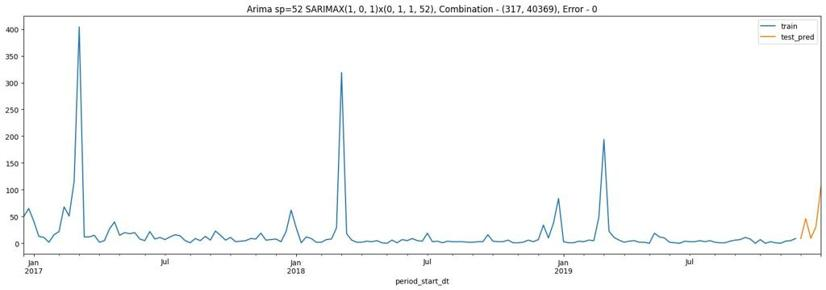

  0%|          | 1/240 [03:18<13:09:12, 198.13s/it]

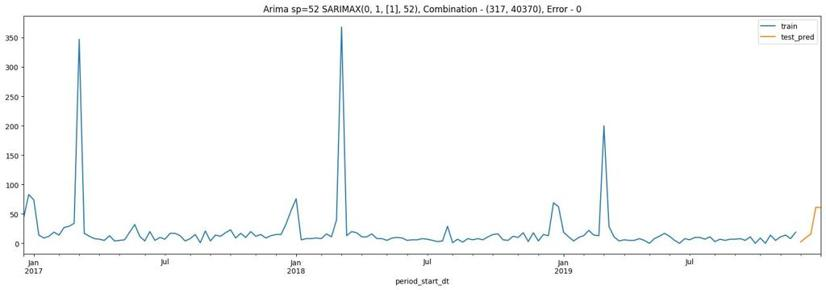

  1%|          | 2/240 [04:02<7:06:38, 107.56s/it] 

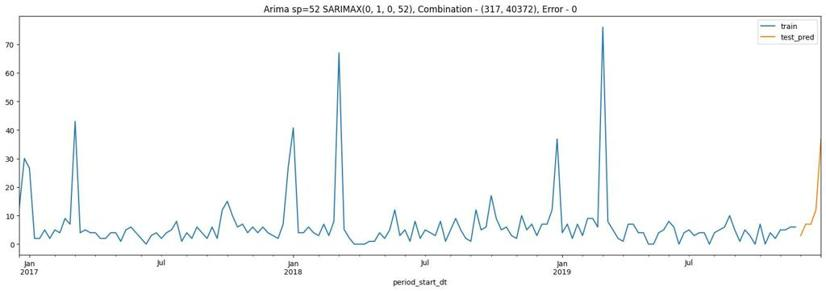

  1%|▏         | 3/240 [04:15<4:14:12, 64.36s/it] 

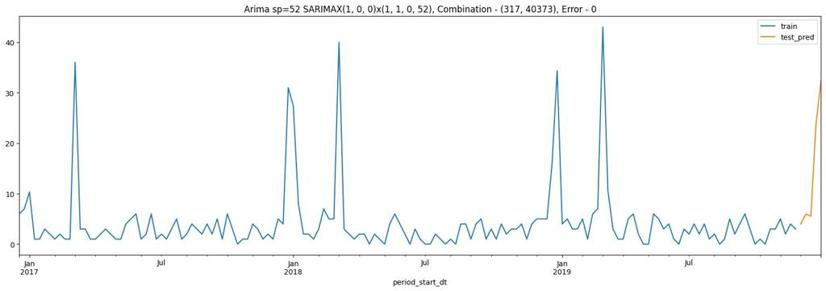

  2%|▏         | 4/240 [04:49<3:26:52, 52.60s/it]

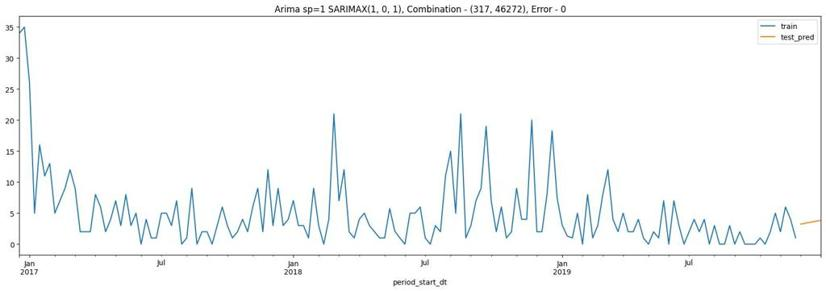

  2%|▏         | 5/240 [04:50<2:12:52, 33.92s/it]

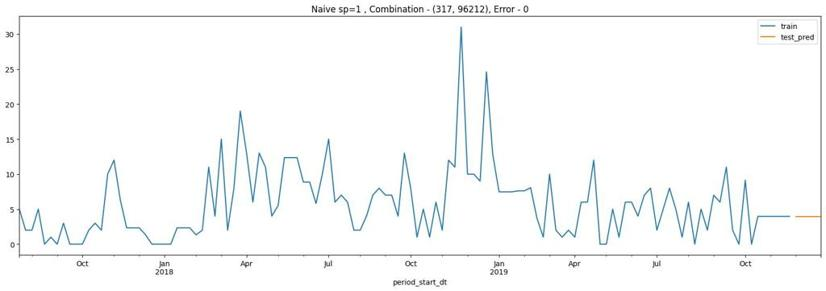

  2%|▎         | 6/240 [04:50<1:27:39, 22.48s/it]

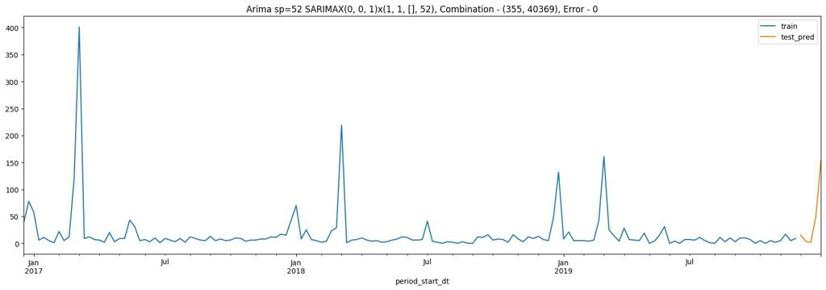

  3%|▎         | 7/240 [06:08<2:37:41, 40.61s/it]

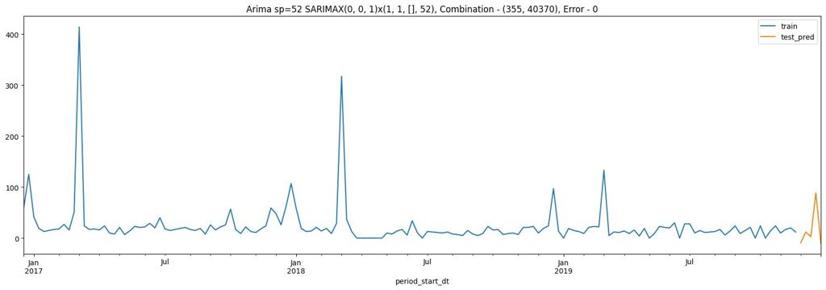

  3%|▎         | 8/240 [07:16<3:10:37, 49.30s/it]

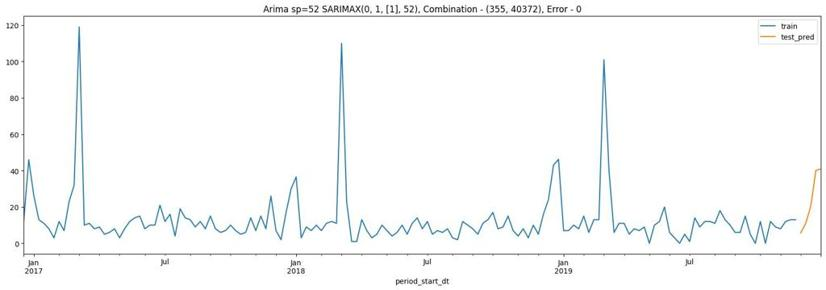

  4%|▍         | 9/240 [07:58<3:00:49, 46.97s/it]

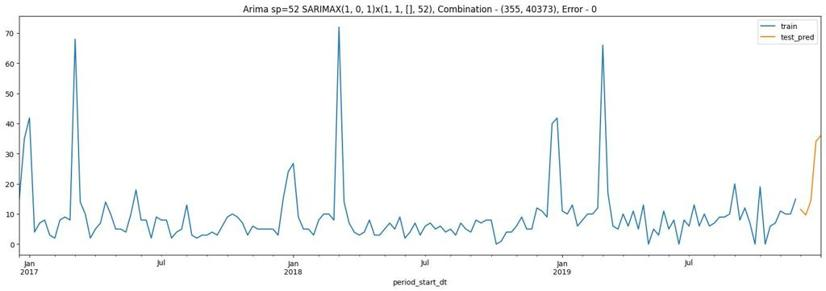

  4%|▍         | 10/240 [11:12<5:54:25, 92.46s/it]

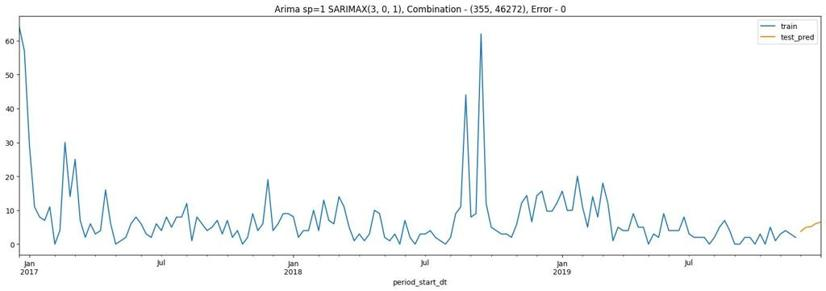

  5%|▍         | 11/240 [11:13<4:06:02, 64.46s/it]

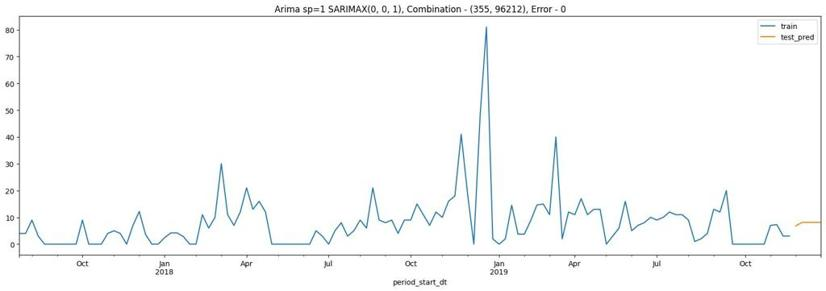

  5%|▌         | 12/240 [11:14<2:51:11, 45.05s/it]

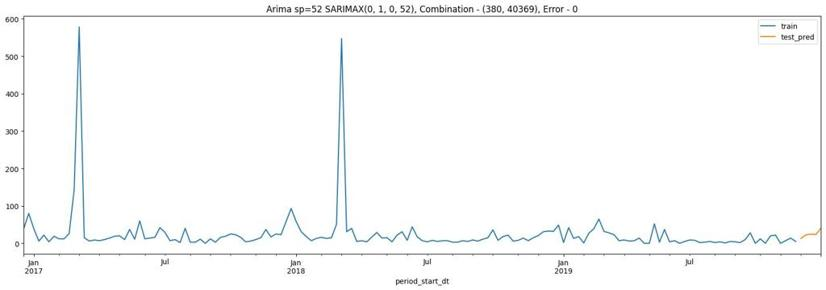

  5%|▌         | 13/240 [11:35<2:22:23, 37.64s/it]

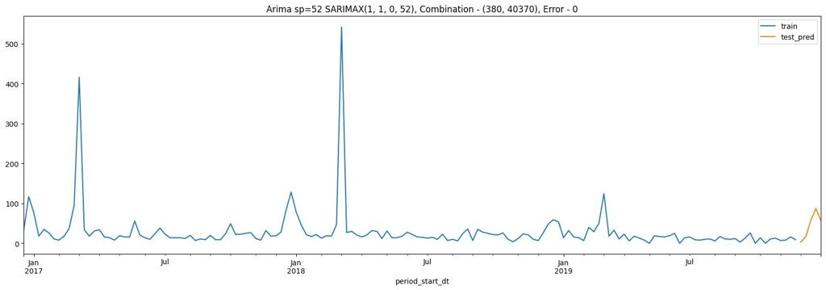

  6%|▌         | 14/240 [12:52<3:06:54, 49.62s/it]

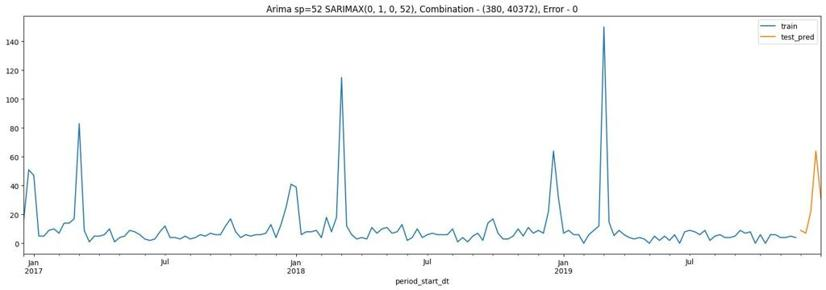

  6%|▋         | 15/240 [13:06<2:25:59, 38.93s/it]

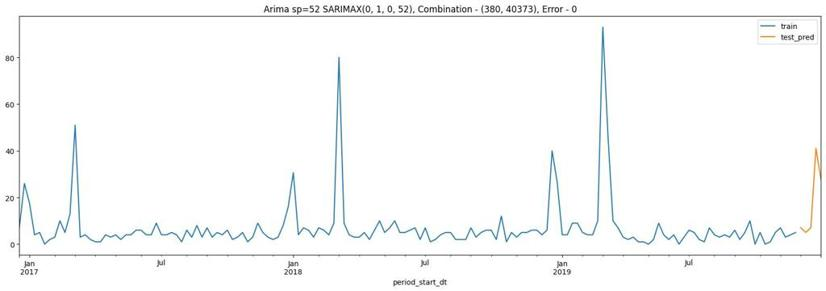

  7%|▋         | 16/240 [13:17<1:54:15, 30.61s/it]

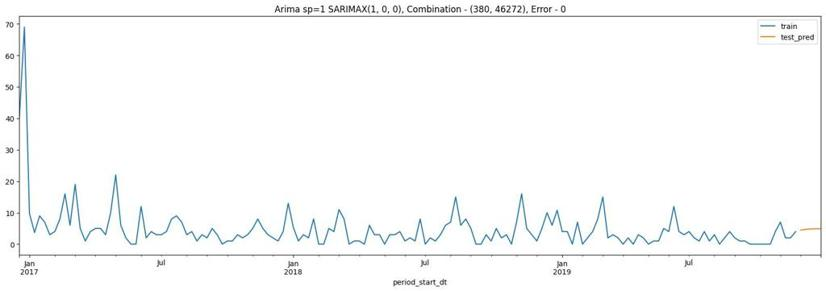

  7%|▋         | 17/240 [13:18<1:20:17, 21.60s/it]

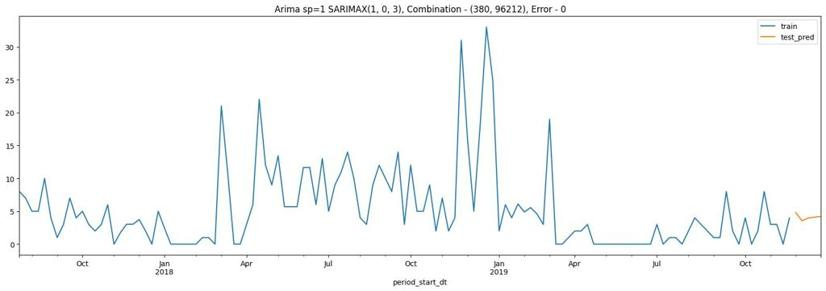

  8%|▊         | 18/240 [13:19<56:49, 15.36s/it]  

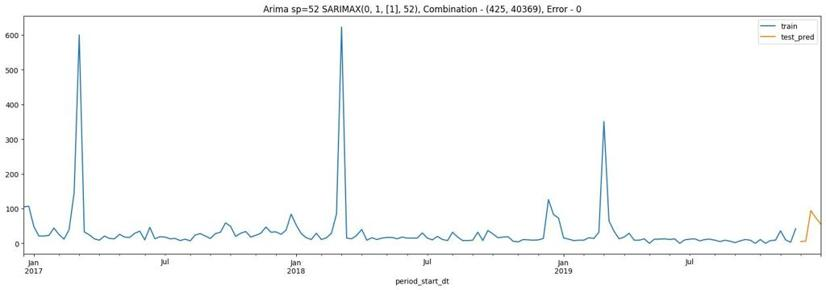

  8%|▊         | 19/240 [13:59<1:24:03, 22.82s/it]

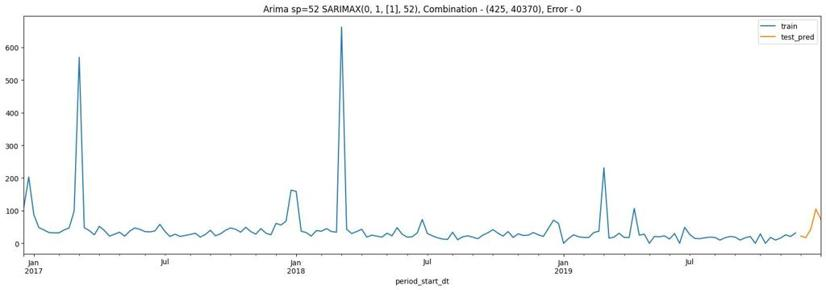

  8%|▊         | 20/240 [15:06<2:12:40, 36.18s/it]

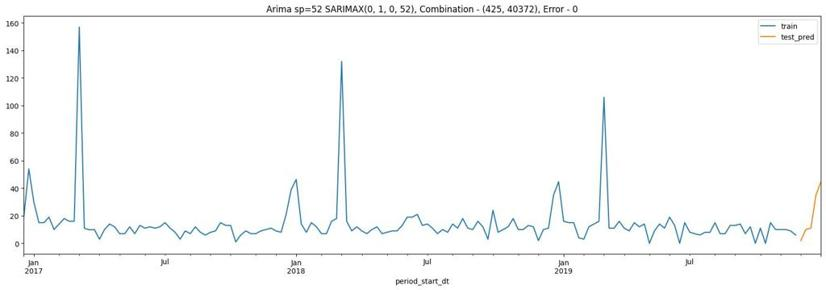

  9%|▉         | 21/240 [15:21<1:48:48, 29.81s/it]

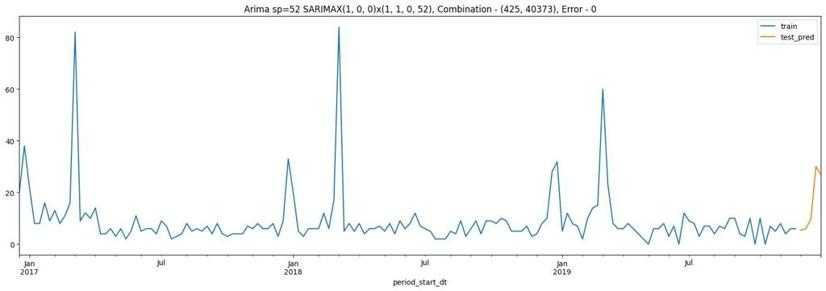

  9%|▉         | 22/240 [16:20<2:20:18, 38.62s/it]

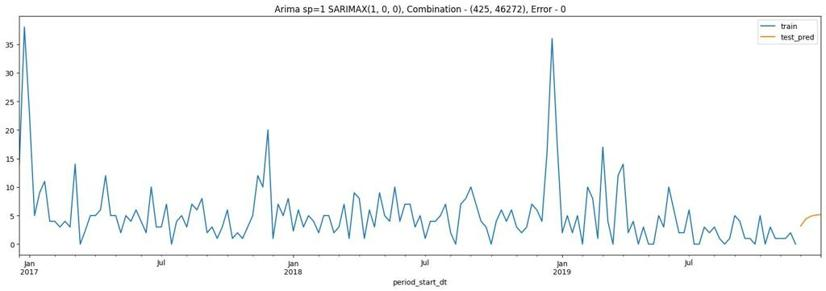

 10%|▉         | 23/240 [16:21<1:38:30, 27.24s/it]

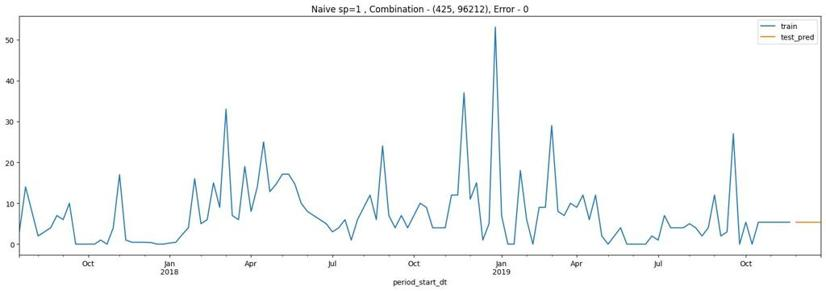

 10%|█         | 24/240 [16:21<1:08:54, 19.14s/it]

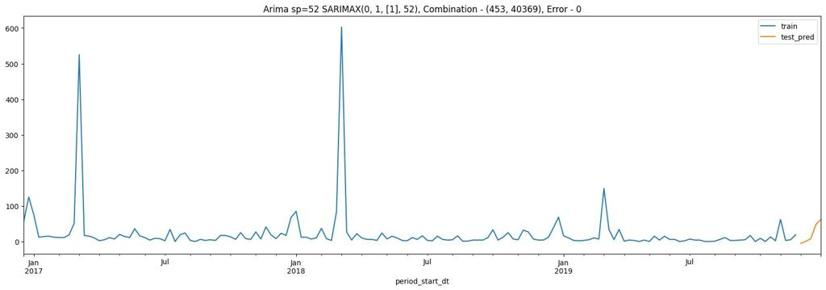

 10%|█         | 25/240 [17:27<1:58:49, 33.16s/it]

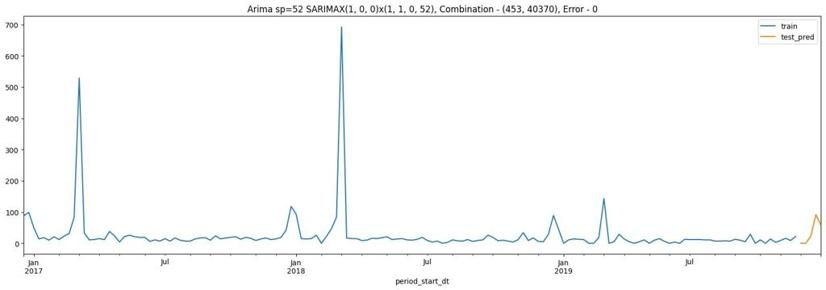

 11%|█         | 26/240 [18:52<2:52:57, 48.49s/it]

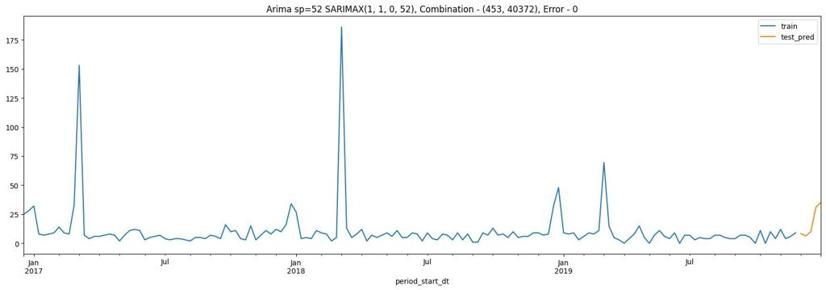

 11%|█▏        | 27/240 [19:58<3:10:52, 53.77s/it]

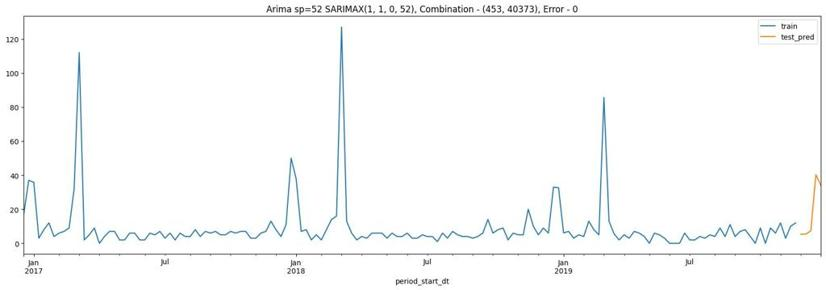

 12%|█▏        | 28/240 [20:47<3:05:43, 52.57s/it]

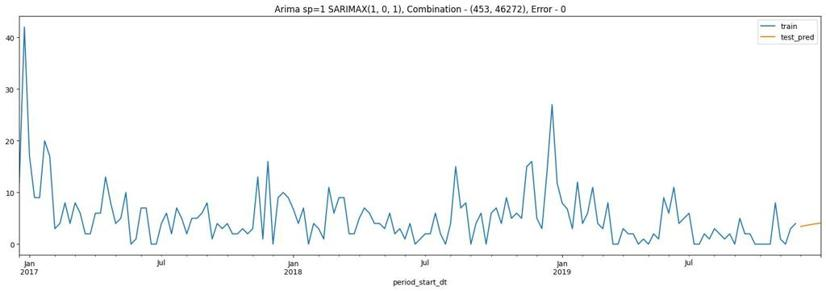

 12%|█▏        | 29/240 [20:48<2:10:22, 37.07s/it]

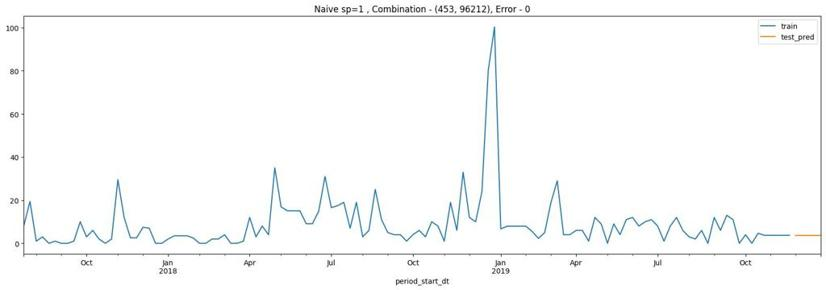

 12%|█▎        | 30/240 [20:49<1:31:04, 26.02s/it]

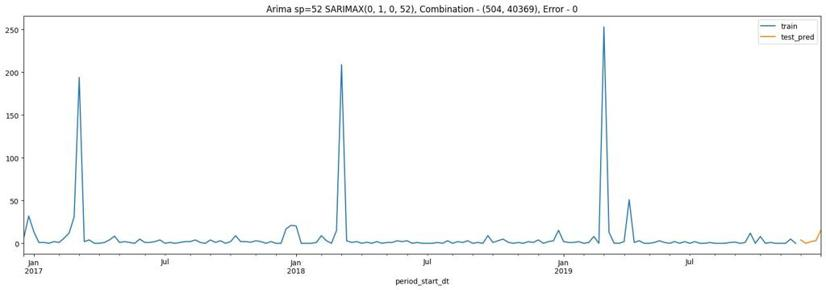

 13%|█▎        | 31/240 [21:05<1:21:00, 23.26s/it]

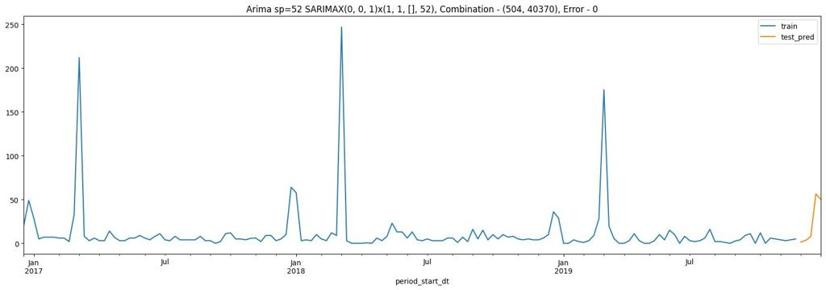

 13%|█▎        | 32/240 [22:37<2:31:53, 43.81s/it]

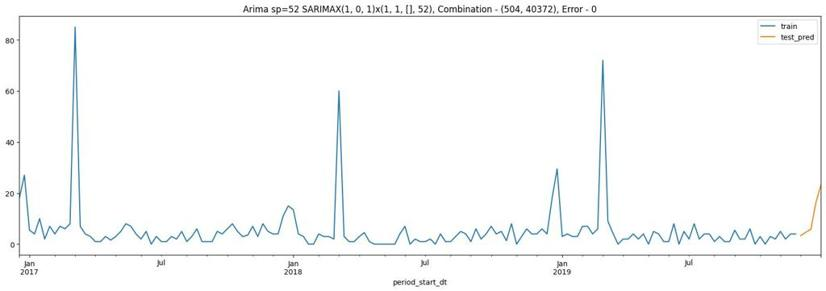

 14%|█▍        | 33/240 [24:29<3:41:33, 64.22s/it]

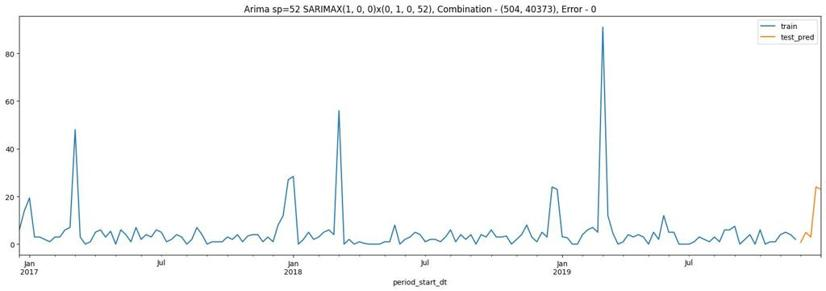

 14%|█▍        | 34/240 [24:52<2:58:24, 51.96s/it]

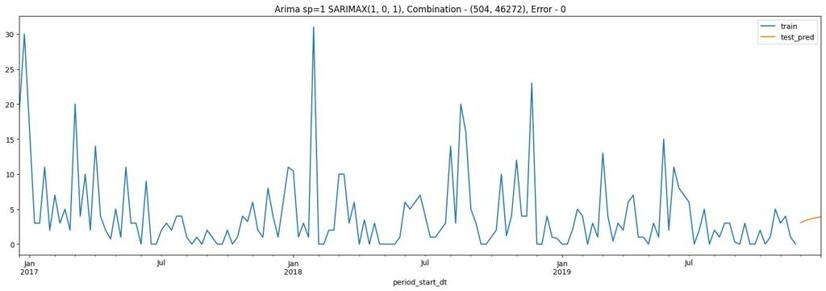

 15%|█▍        | 35/240 [24:53<2:05:13, 36.65s/it]

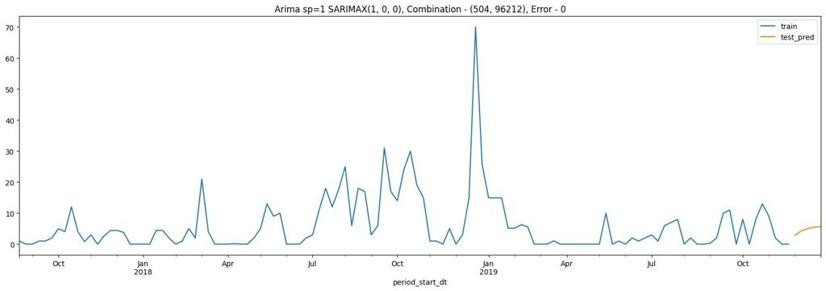

 15%|█▌        | 36/240 [24:54<1:27:55, 25.86s/it]

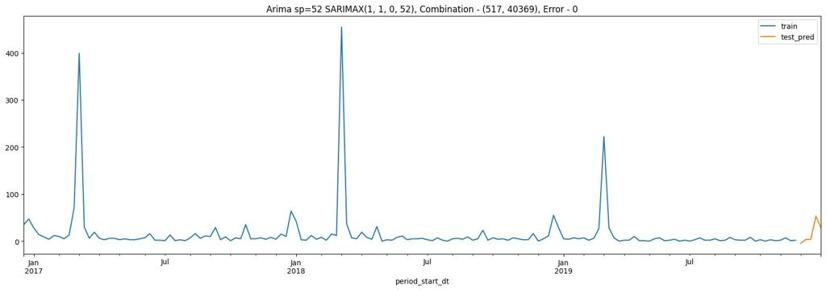

 15%|█▌        | 37/240 [26:01<2:09:12, 38.19s/it]

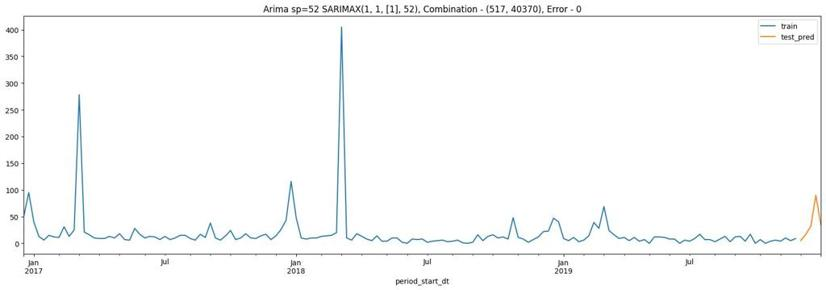

 16%|█▌        | 38/240 [27:43<3:13:17, 57.42s/it]

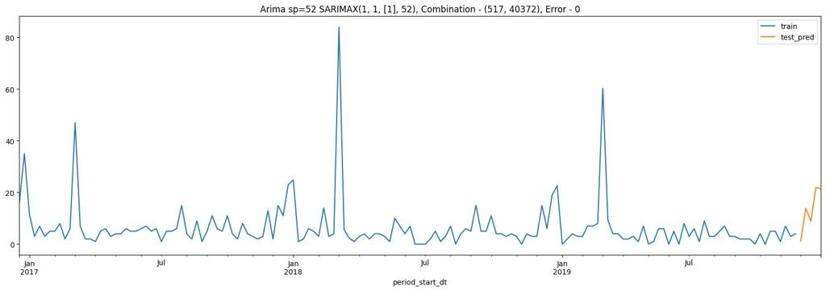

 16%|█▋        | 39/240 [28:21<2:52:11, 51.40s/it]

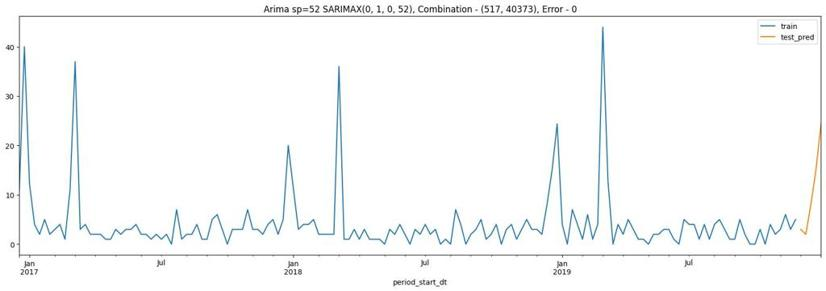

 17%|█▋        | 40/240 [28:33<2:12:26, 39.73s/it]

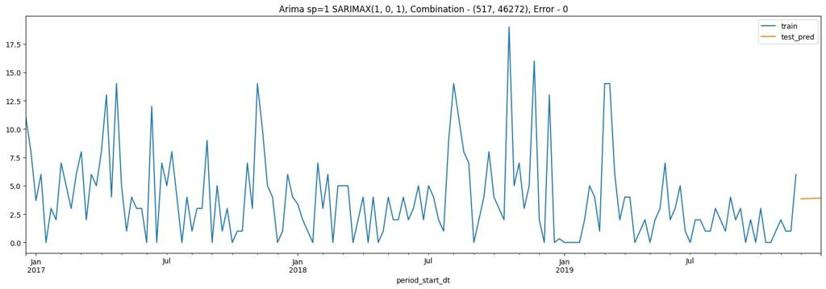

 17%|█▋        | 41/240 [28:34<1:33:04, 28.06s/it]

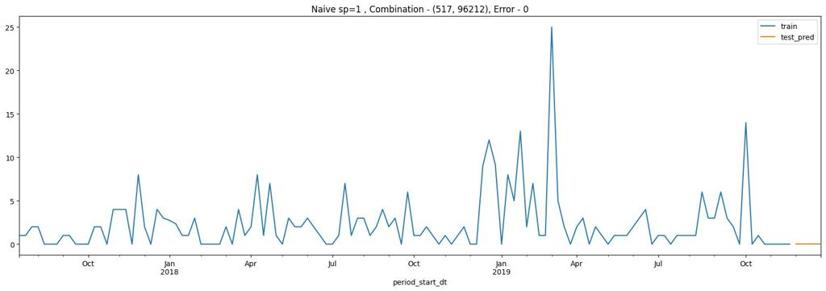

 18%|█▊        | 42/240 [28:34<1:05:03, 19.71s/it]

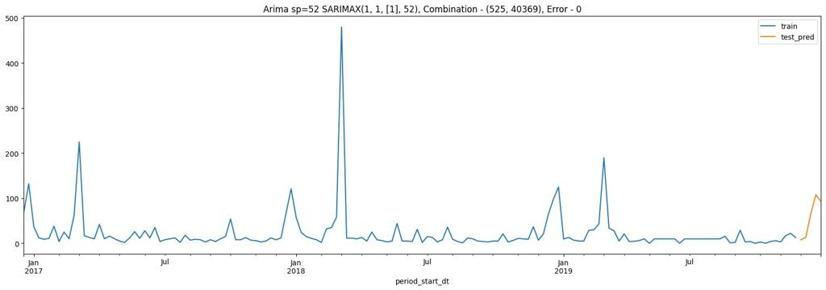

 18%|█▊        | 43/240 [30:37<2:46:00, 50.56s/it]

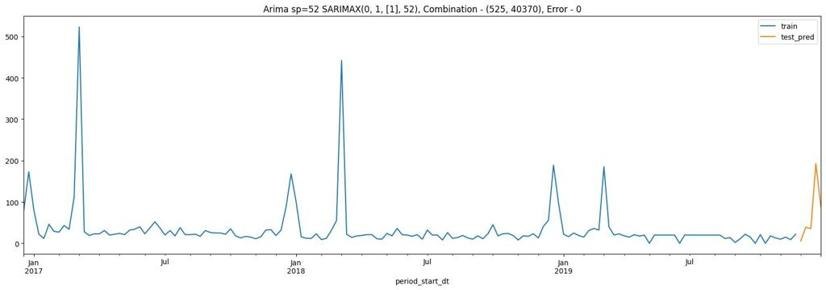

 18%|█▊        | 44/240 [31:44<3:01:44, 55.64s/it]

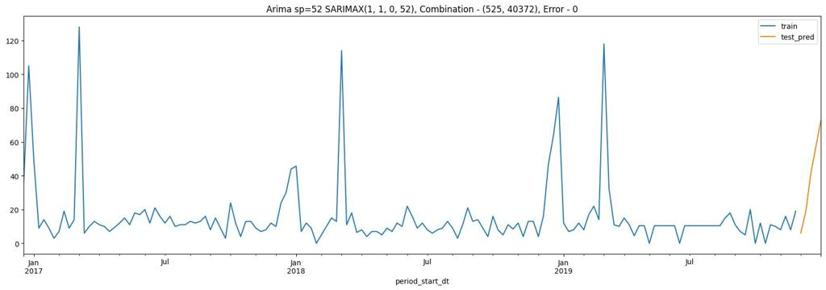

 19%|█▉        | 45/240 [32:33<2:54:11, 53.60s/it]

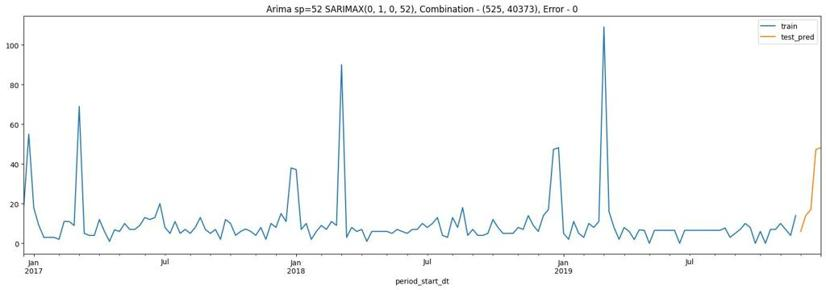

 19%|█▉        | 46/240 [32:46<2:13:34, 41.31s/it]

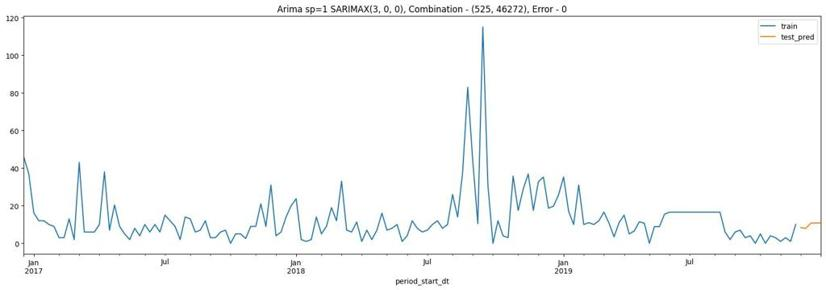

 20%|█▉        | 47/240 [32:47<1:33:57, 29.21s/it]

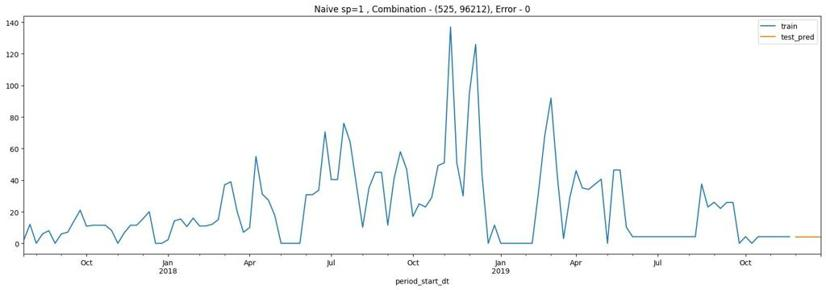

 20%|██        | 48/240 [32:47<1:05:40, 20.52s/it]

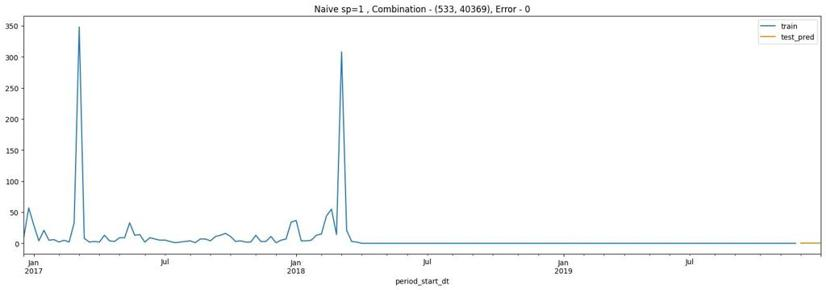

 20%|██        | 49/240 [32:47<45:59, 14.45s/it]  

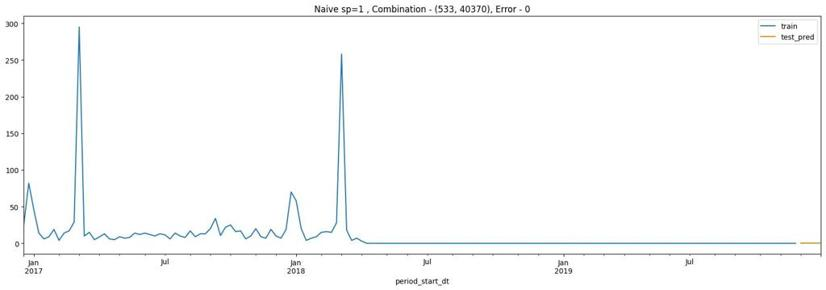

 21%|██        | 50/240 [32:47<32:15, 10.19s/it]

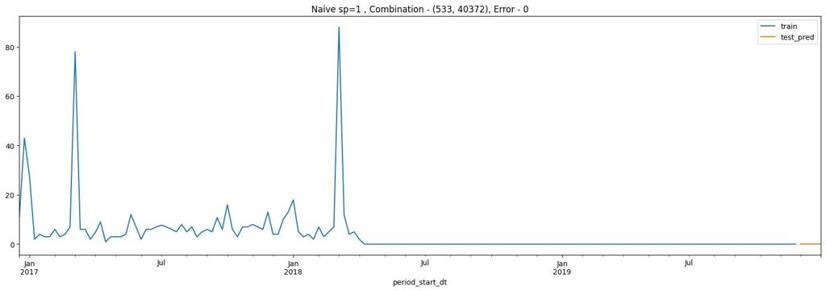

 21%|██▏       | 51/240 [32:48<22:41,  7.20s/it]

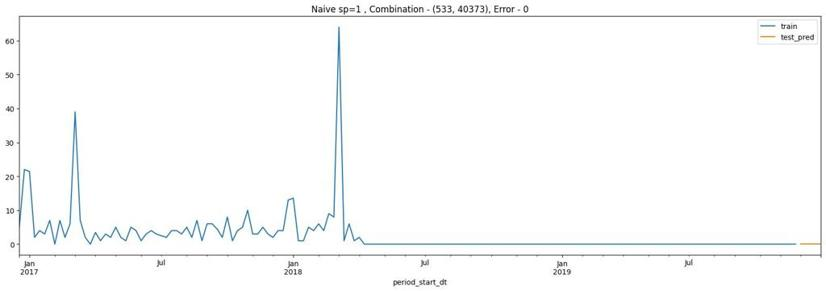

 22%|██▏       | 52/240 [32:48<16:02,  5.12s/it]

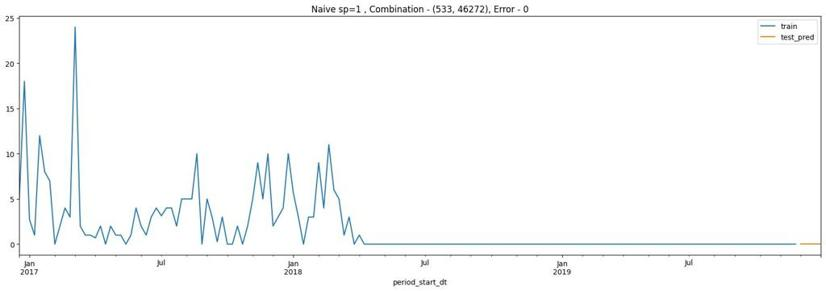

 22%|██▏       | 53/240 [32:48<11:23,  3.66s/it]

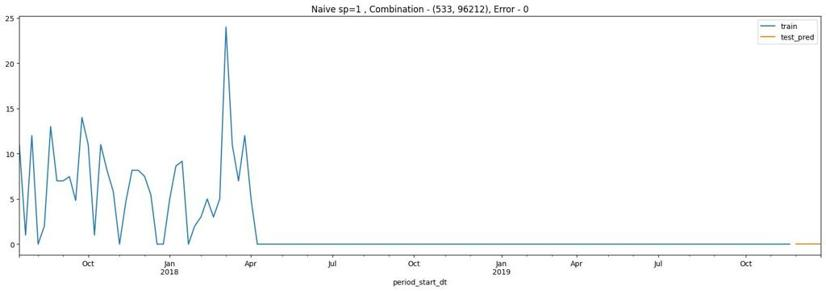

 22%|██▎       | 54/240 [32:48<08:09,  2.63s/it]

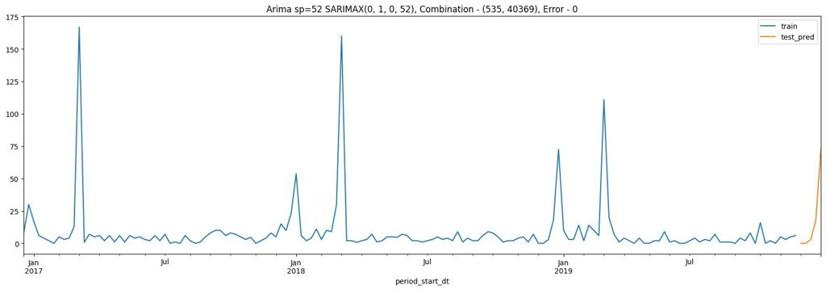

 23%|██▎       | 55/240 [33:05<20:48,  6.75s/it]

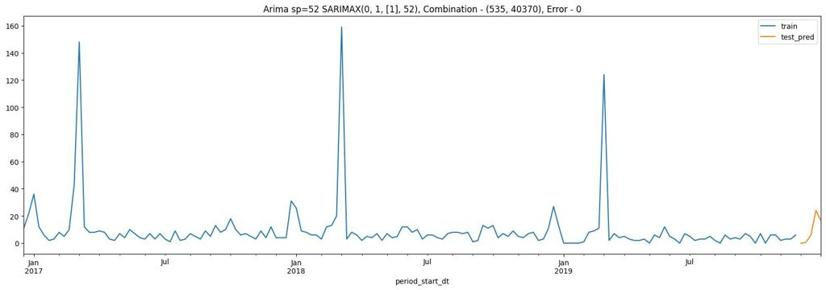

 23%|██▎       | 56/240 [33:38<44:44, 14.59s/it]

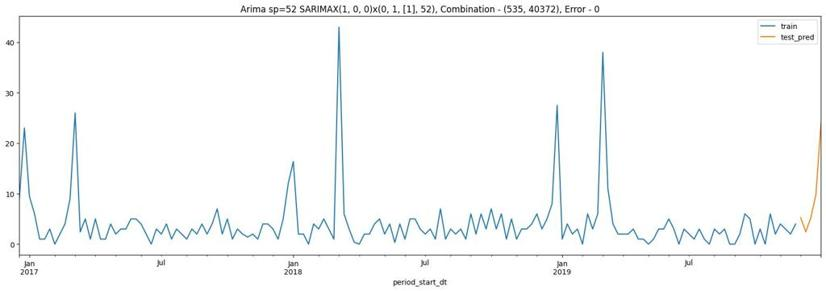

 24%|██▍       | 57/240 [34:29<1:18:13, 25.65s/it]

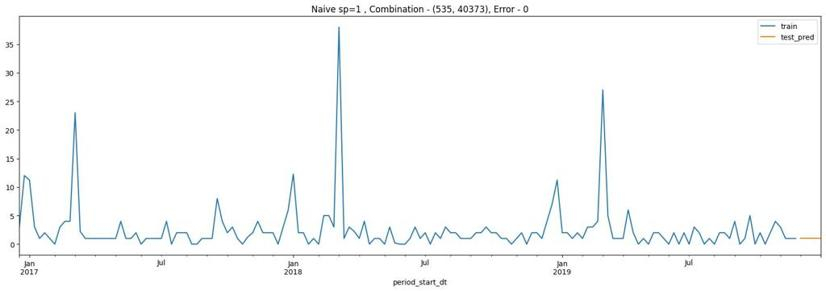

 24%|██▍       | 58/240 [34:29<54:41, 18.03s/it]  

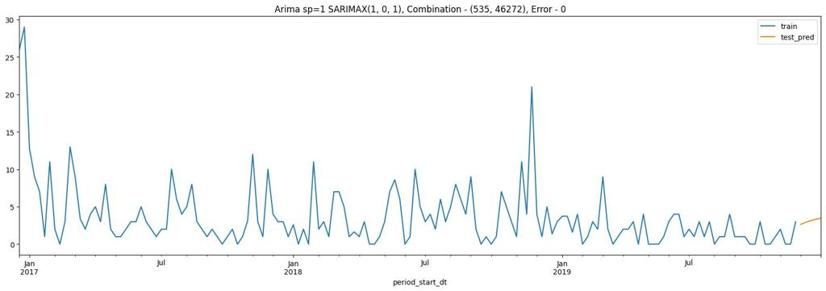

 25%|██▍       | 59/240 [34:30<38:57, 12.91s/it]

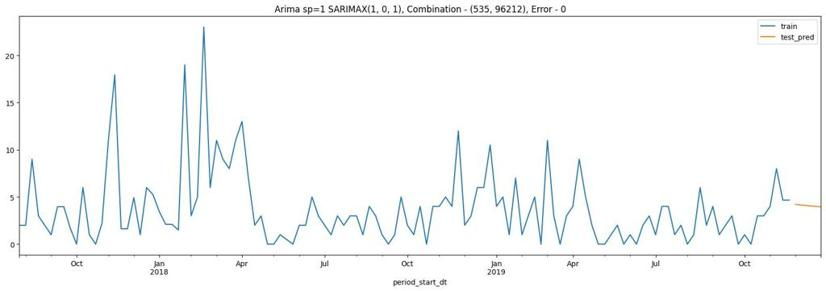

 25%|██▌       | 60/240 [34:31<27:48,  9.27s/it]

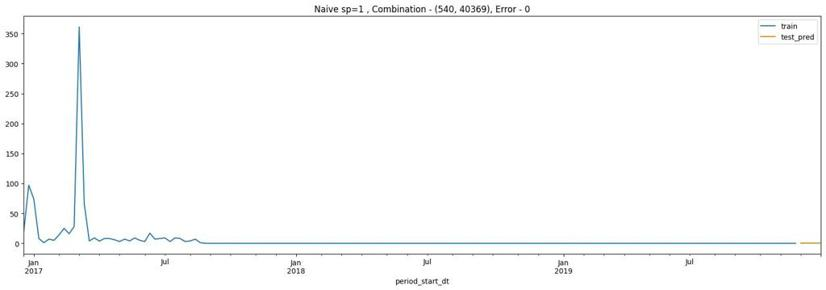

 25%|██▌       | 61/240 [34:31<19:35,  6.57s/it]

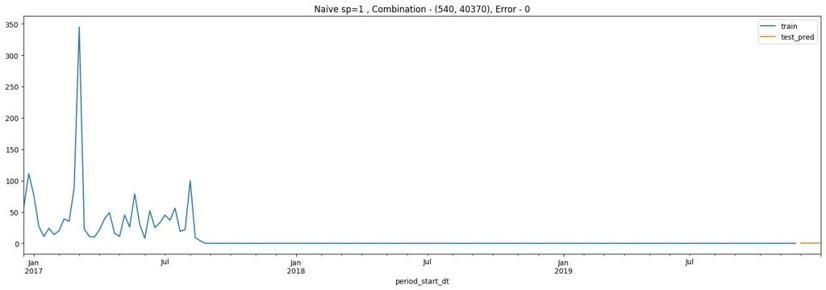

 26%|██▌       | 62/240 [34:32<13:52,  4.67s/it]

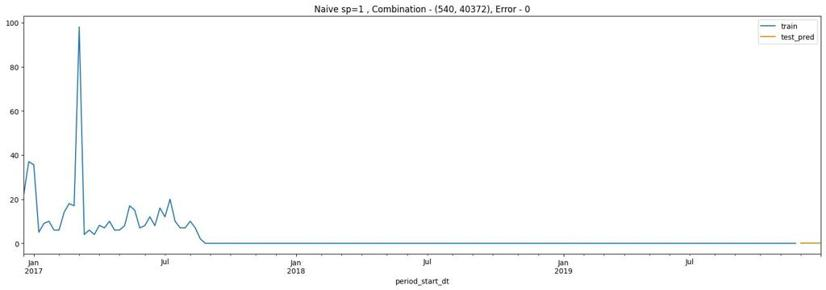

 26%|██▋       | 63/240 [34:32<10:00,  3.39s/it]

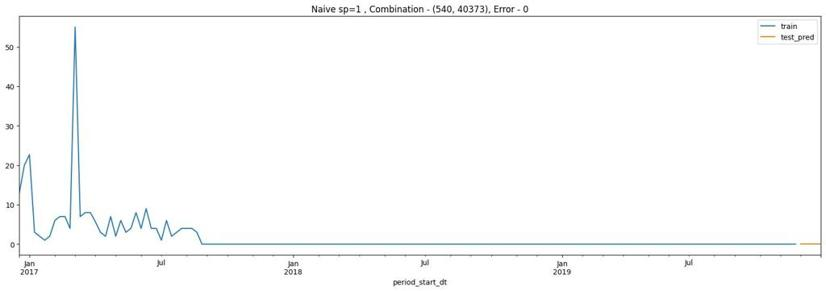

 27%|██▋       | 64/240 [34:32<07:11,  2.45s/it]

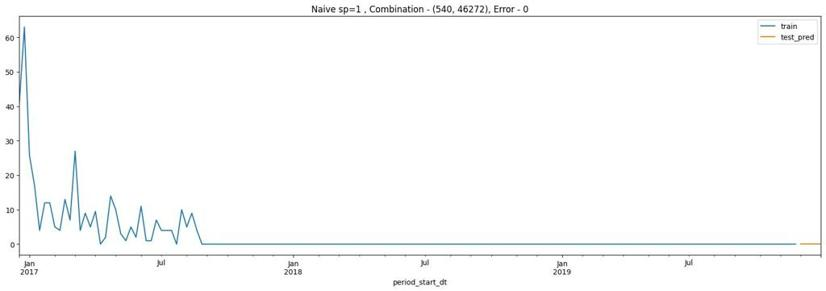

 27%|██▋       | 65/240 [34:32<05:14,  1.79s/it]

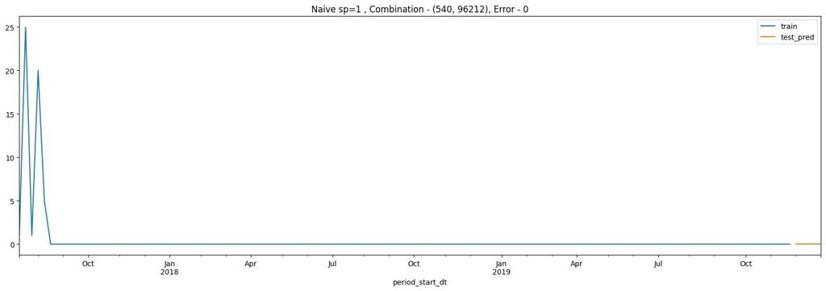

 28%|██▊       | 66/240 [34:33<03:51,  1.33s/it]

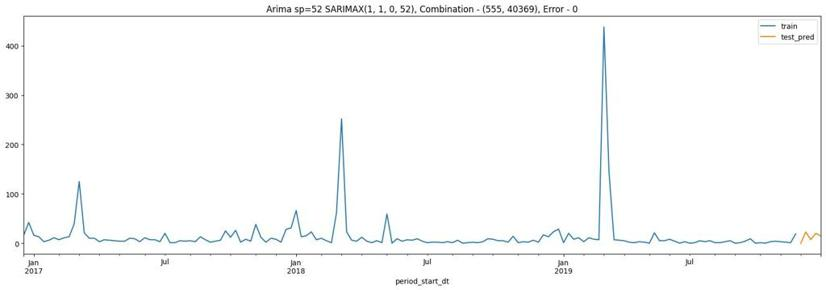

 28%|██▊       | 67/240 [35:50<1:09:27, 24.09s/it]

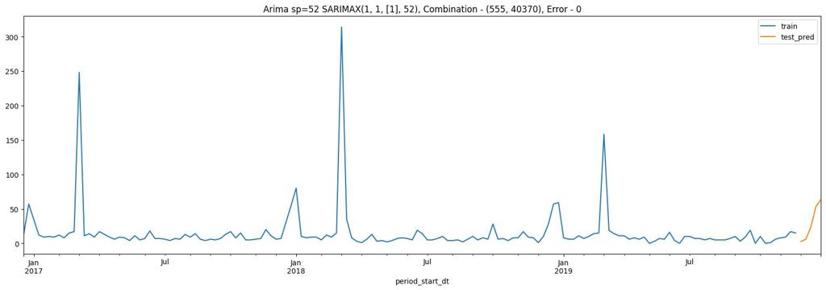

 28%|██▊       | 68/240 [37:14<2:00:36, 42.07s/it]

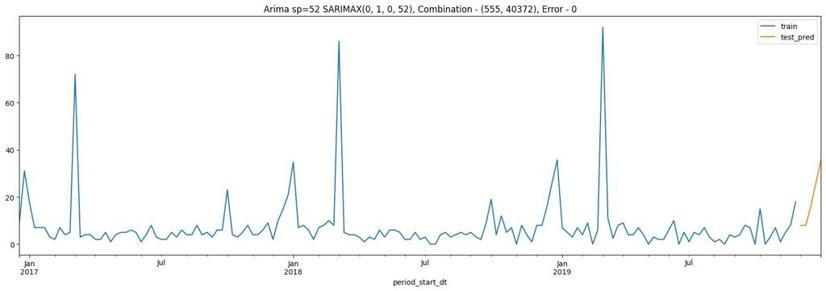

 29%|██▉       | 69/240 [37:28<1:35:44, 33.60s/it]

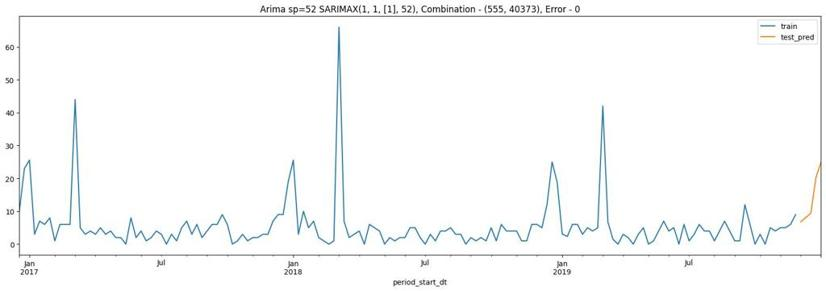

 29%|██▉       | 70/240 [38:35<2:03:29, 43.58s/it]

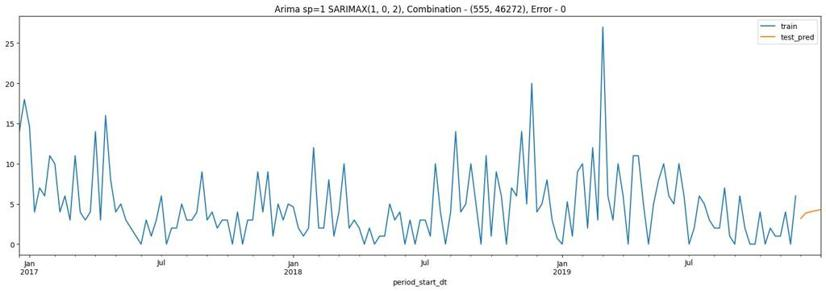

 30%|██▉       | 71/240 [38:36<1:26:52, 30.84s/it]

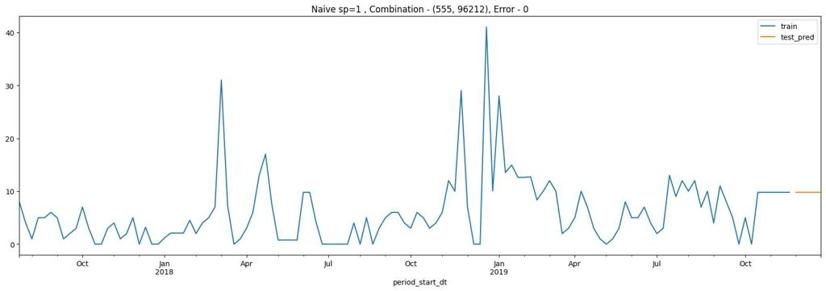

 30%|███       | 72/240 [38:36<1:00:40, 21.67s/it]

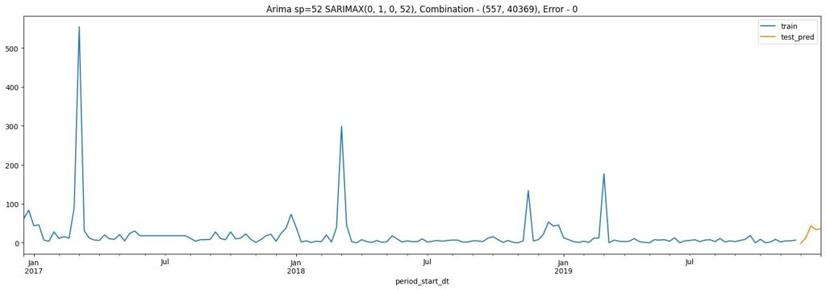

 30%|███       | 73/240 [38:57<1:00:03, 21.58s/it]

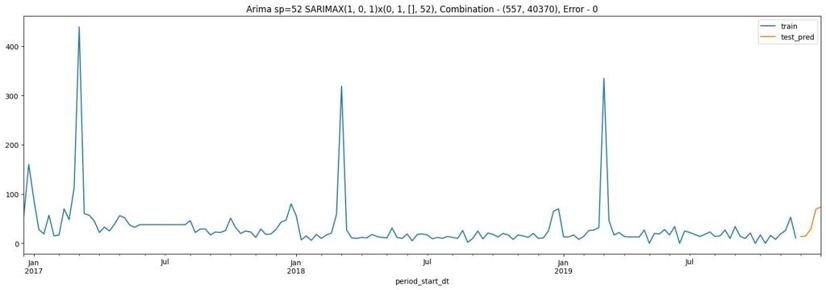

 31%|███       | 74/240 [41:50<3:05:18, 66.98s/it]

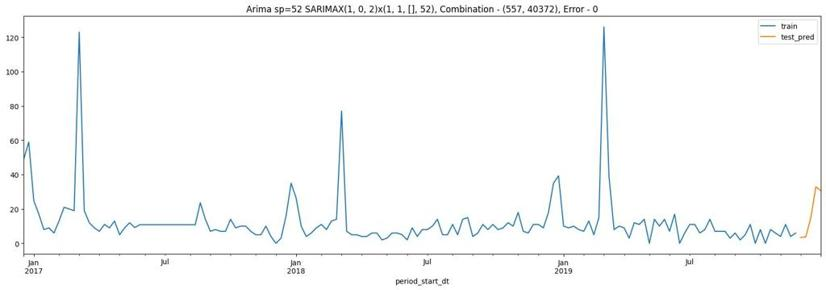

 31%|███▏      | 75/240 [46:25<5:55:29, 129.27s/it]

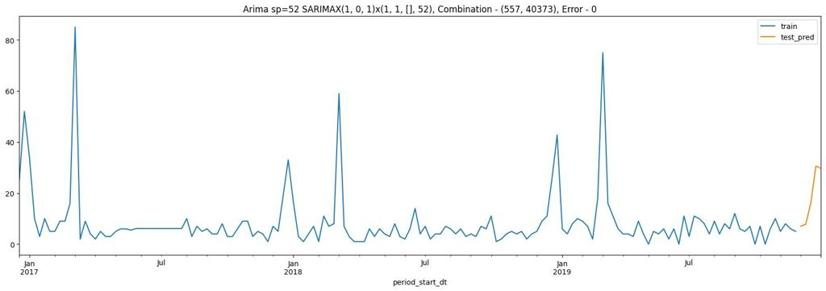

 32%|███▏      | 76/240 [49:29<6:38:30, 145.79s/it]

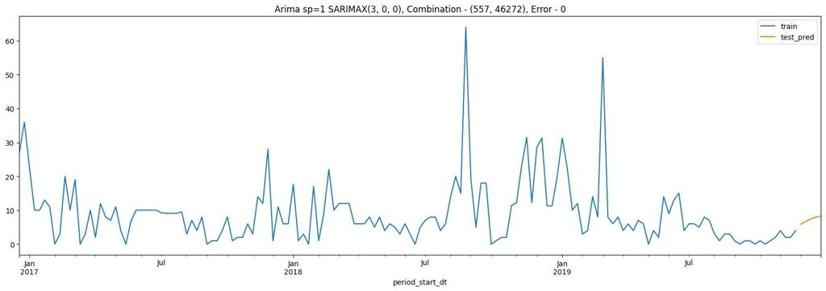

 32%|███▏      | 77/240 [49:30<4:37:59, 102.33s/it]

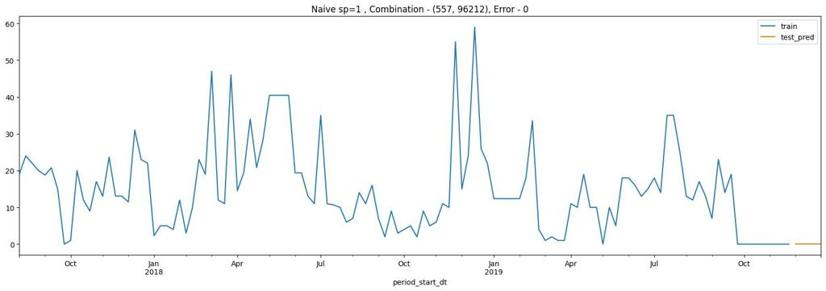

 32%|███▎      | 78/240 [49:31<3:13:41, 71.74s/it] 

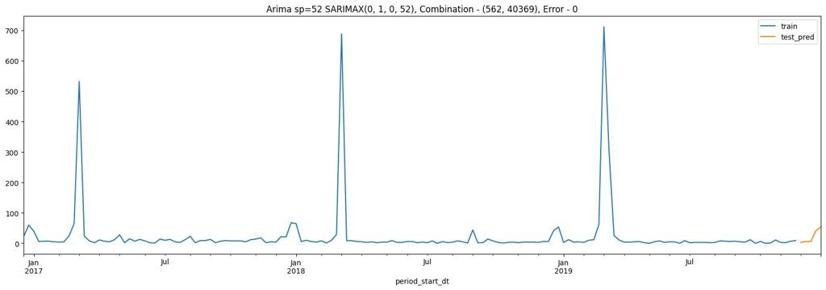

 33%|███▎      | 79/240 [49:50<2:30:45, 56.18s/it]

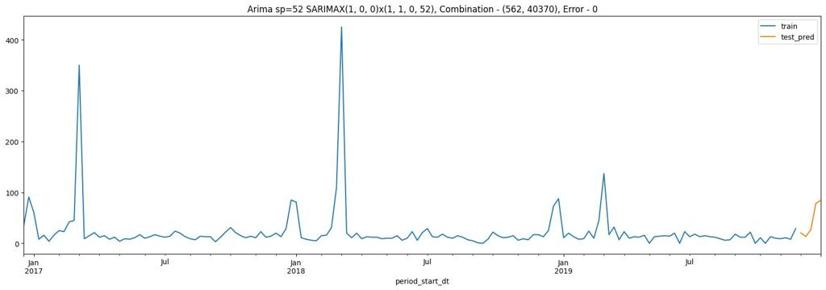

 33%|███▎      | 80/240 [52:30<3:52:26, 87.17s/it]

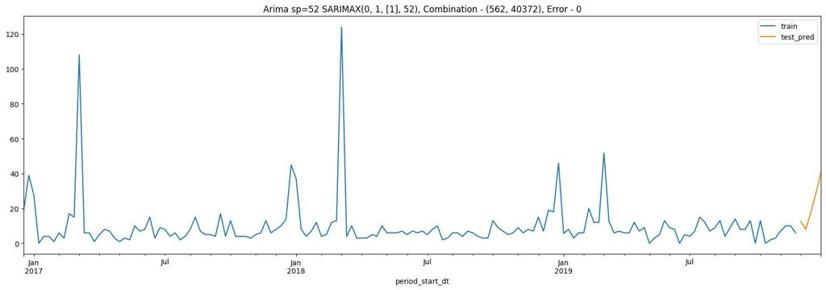

 34%|███▍      | 81/240 [53:40<3:37:27, 82.06s/it]

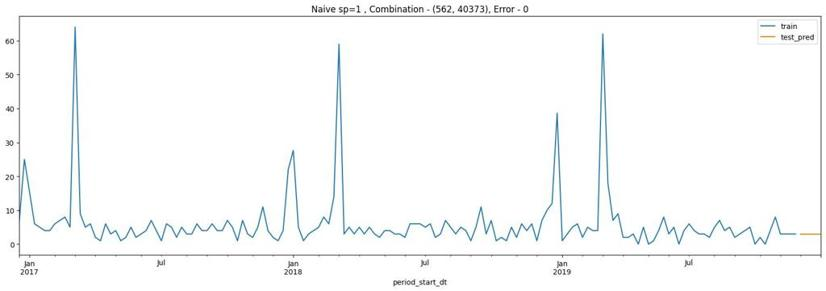

 34%|███▍      | 82/240 [53:40<2:31:28, 57.52s/it]

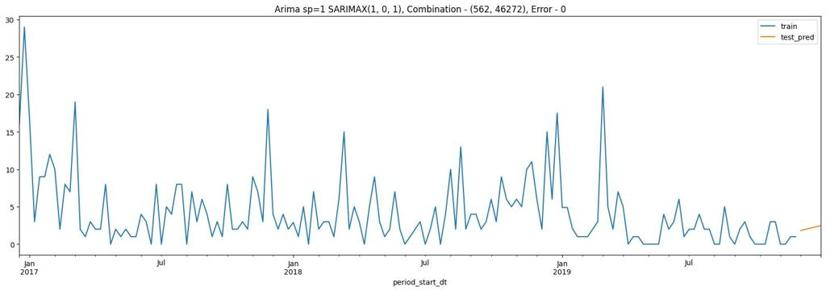

 35%|███▍      | 83/240 [53:41<1:46:13, 40.59s/it]

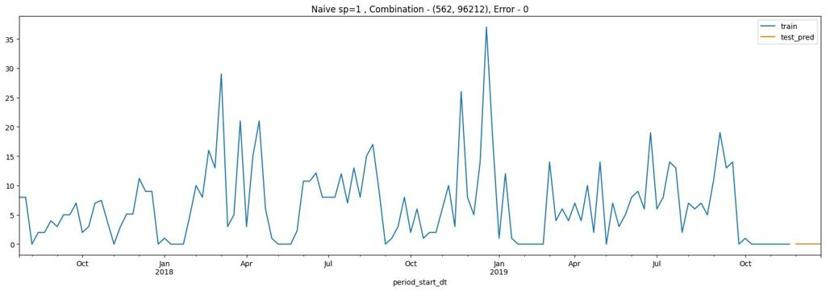

 35%|███▌      | 84/240 [53:42<1:14:05, 28.50s/it]

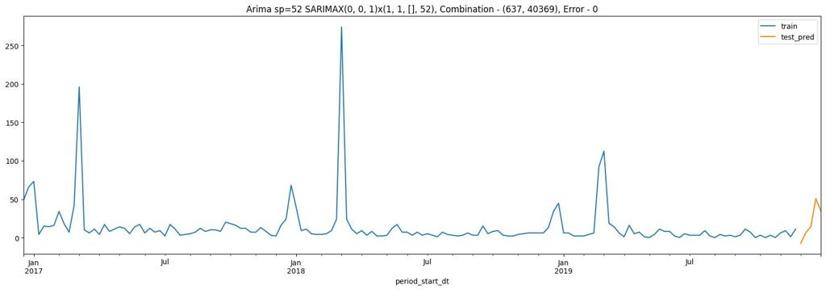

 35%|███▌      | 85/240 [55:43<2:25:39, 56.38s/it]

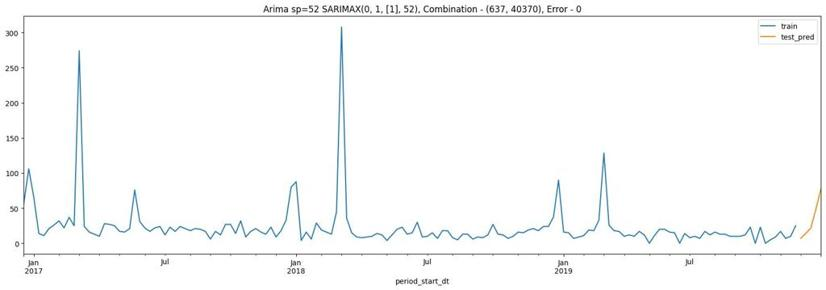

 36%|███▌      | 86/240 [56:36<2:21:55, 55.30s/it]

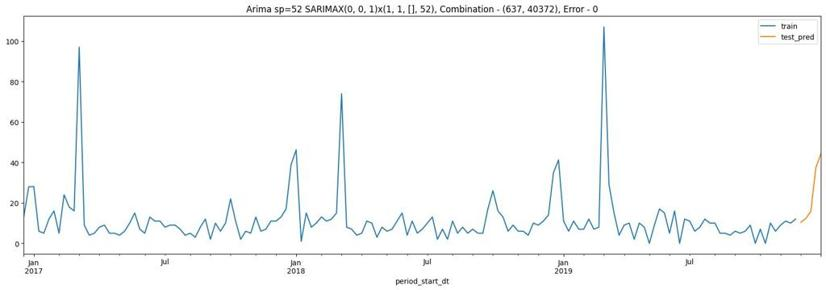

 36%|███▋      | 87/240 [57:55<2:39:13, 62.44s/it]

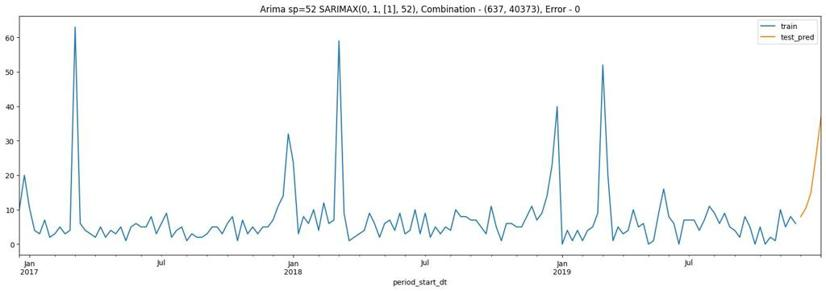

 37%|███▋      | 88/240 [58:20<2:10:02, 51.33s/it]

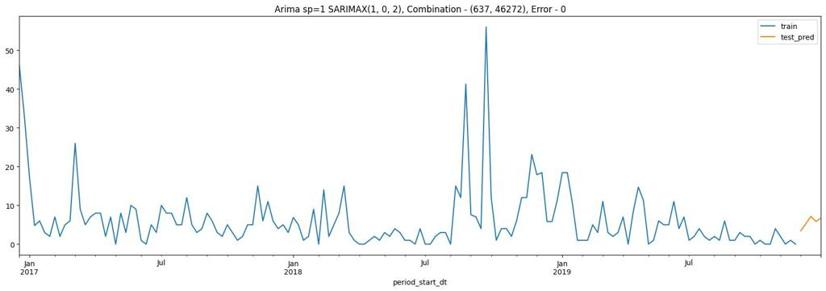

 37%|███▋      | 89/240 [58:21<1:31:14, 36.25s/it]

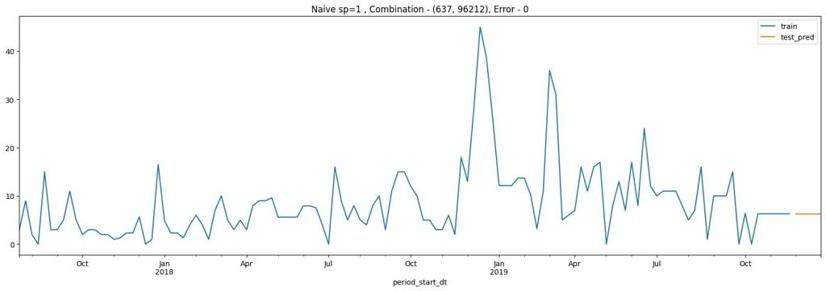

 38%|███▊      | 90/240 [58:22<1:03:37, 25.45s/it]

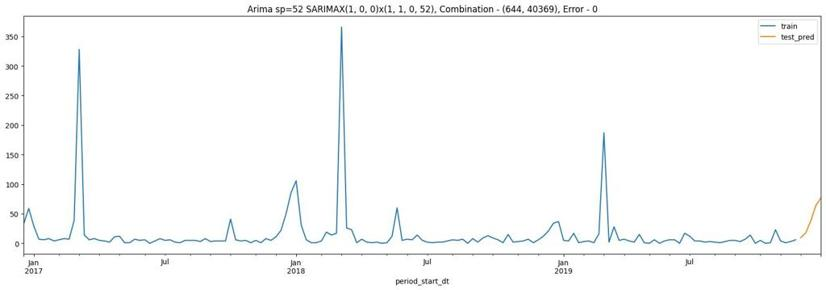

 38%|███▊      | 91/240 [1:00:27<2:17:46, 55.48s/it]

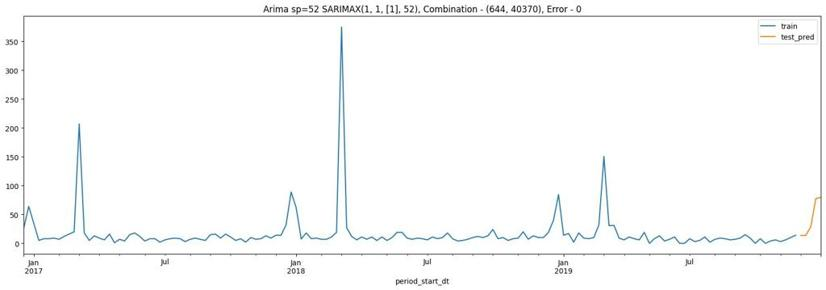

 38%|███▊      | 92/240 [1:02:07<2:49:57, 68.90s/it]

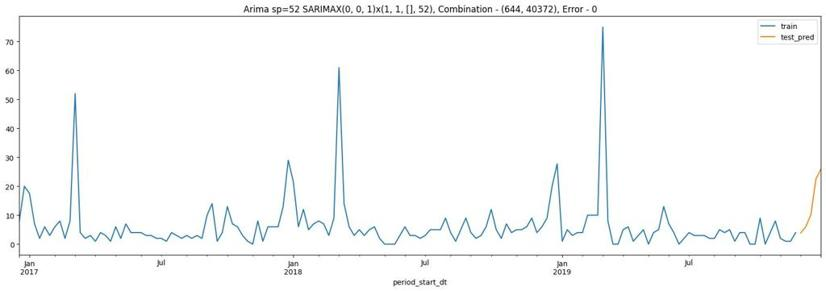

 39%|███▉      | 93/240 [1:03:08<2:42:22, 66.27s/it]

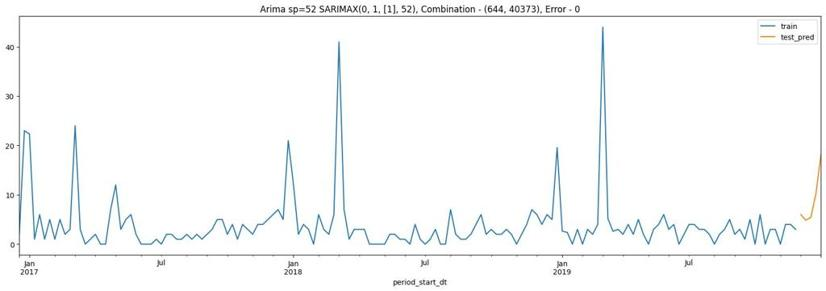

 39%|███▉      | 94/240 [1:03:40<2:16:23, 56.05s/it]

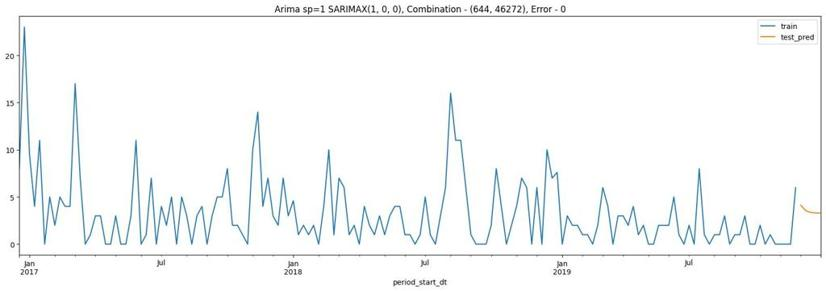

 40%|███▉      | 95/240 [1:03:40<1:35:16, 39.42s/it]

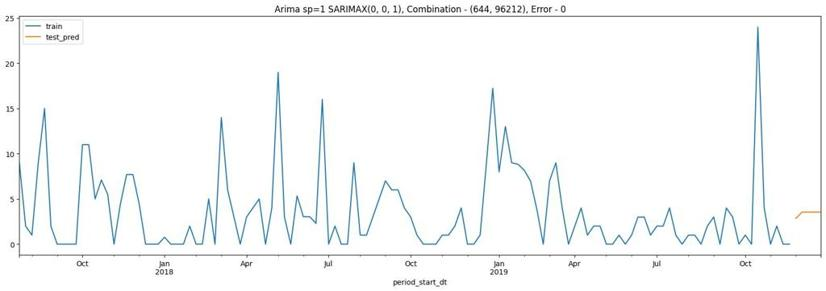

 40%|████      | 96/240 [1:03:41<1:06:40, 27.78s/it]

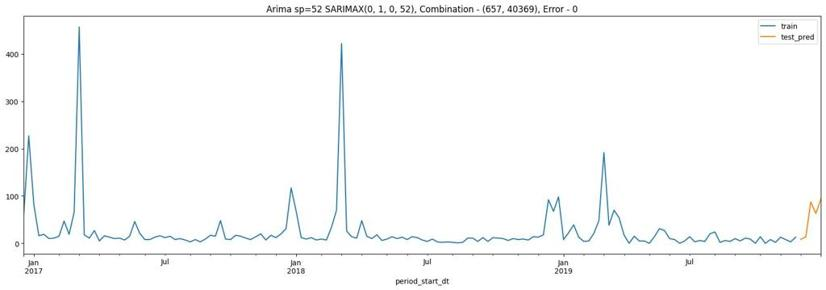

 40%|████      | 97/240 [1:04:13<1:09:19, 29.08s/it]

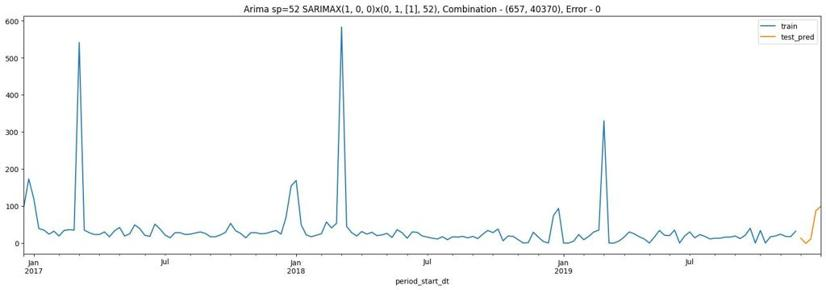

 41%|████      | 98/240 [1:05:16<1:32:47, 39.21s/it]

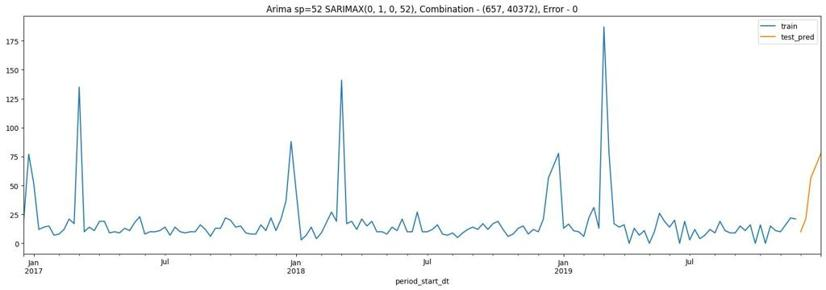

 41%|████▏     | 99/240 [1:05:32<1:15:50, 32.27s/it]

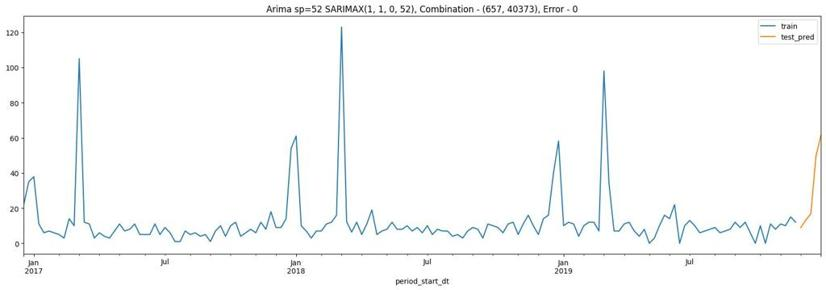

 42%|████▏     | 100/240 [1:06:20<1:26:28, 37.06s/it]

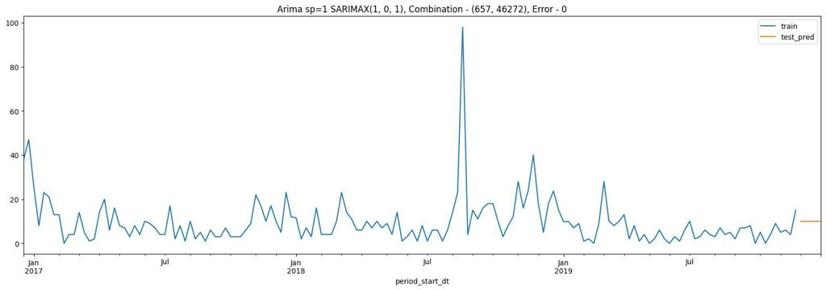

 42%|████▏     | 101/240 [1:06:21<1:00:49, 26.26s/it]

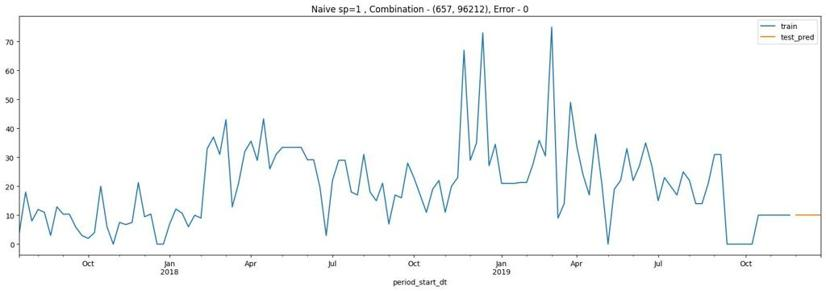

 42%|████▎     | 102/240 [1:06:22<42:27, 18.46s/it]  

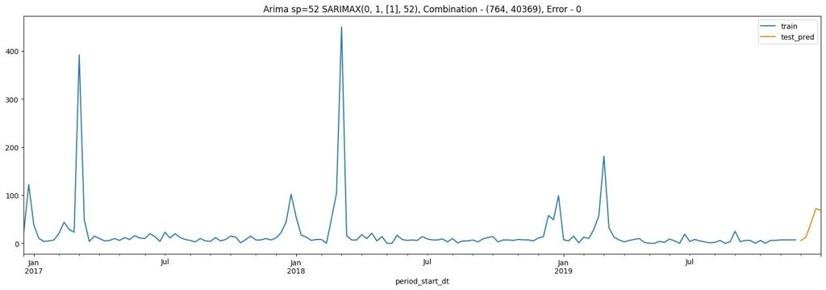

 43%|████▎     | 103/240 [1:07:29<1:15:56, 33.26s/it]

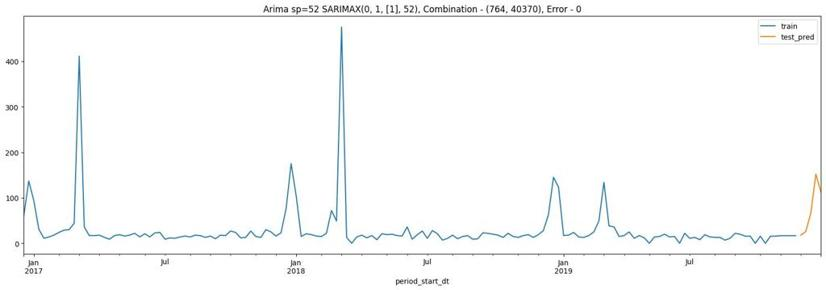

 43%|████▎     | 104/240 [1:09:11<2:01:55, 53.79s/it]

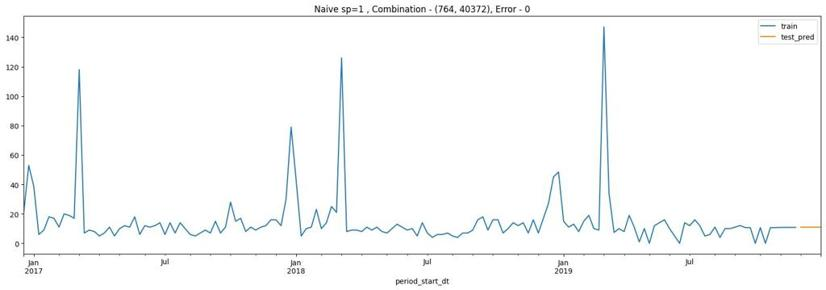

 44%|████▍     | 105/240 [1:09:11<1:24:53, 37.73s/it]

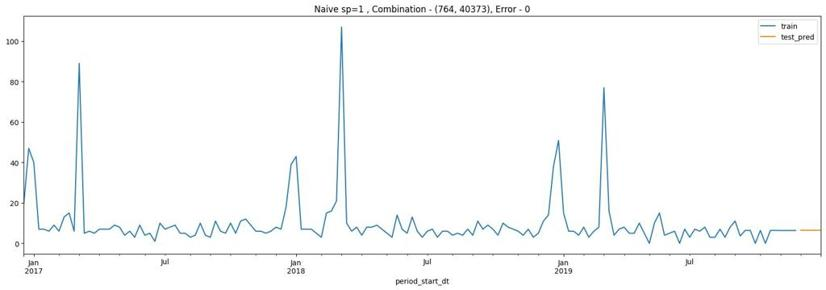

 44%|████▍     | 106/240 [1:09:12<59:09, 26.49s/it]  

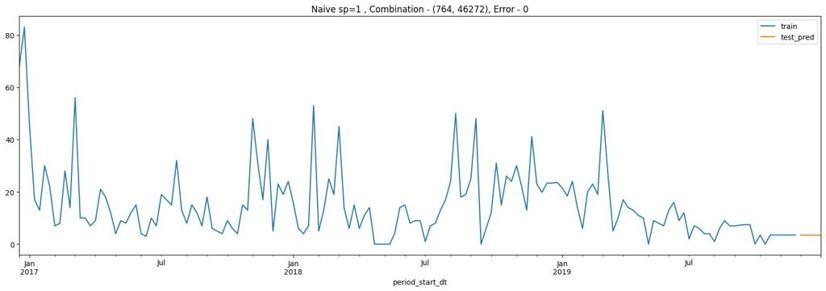

 45%|████▍     | 107/240 [1:09:12<41:15, 18.62s/it]

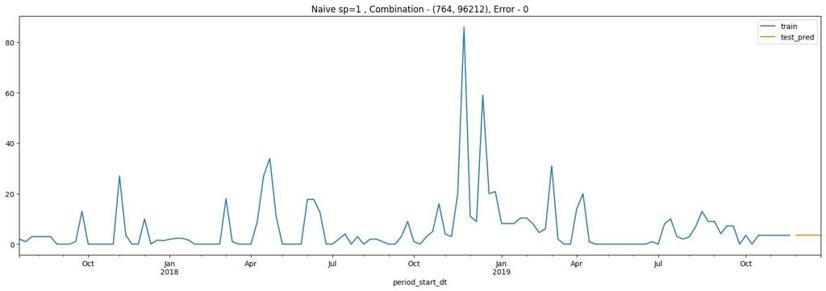

 45%|████▌     | 108/240 [1:09:12<28:50, 13.11s/it]

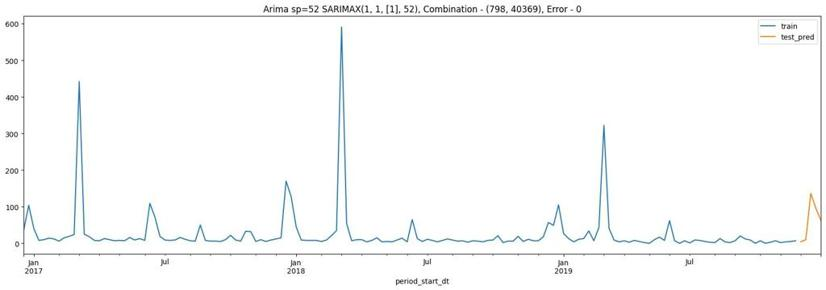

 45%|████▌     | 109/240 [1:10:47<1:22:26, 37.76s/it]

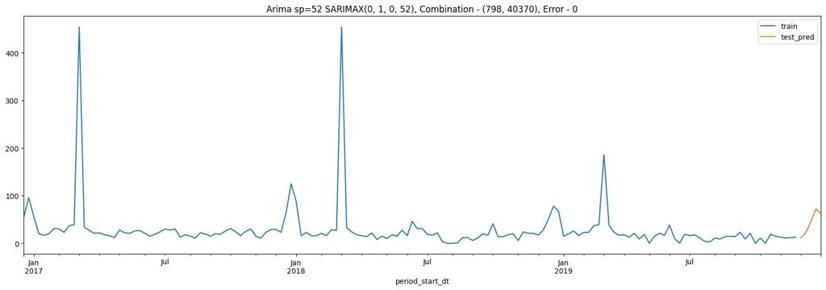

 46%|████▌     | 110/240 [1:11:08<1:10:49, 32.69s/it]

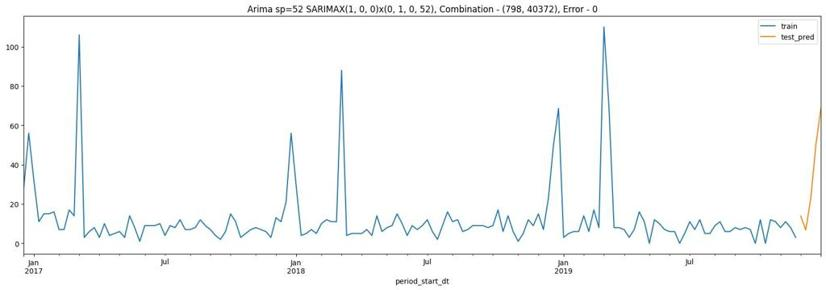

 46%|████▋     | 111/240 [1:11:43<1:11:36, 33.30s/it]

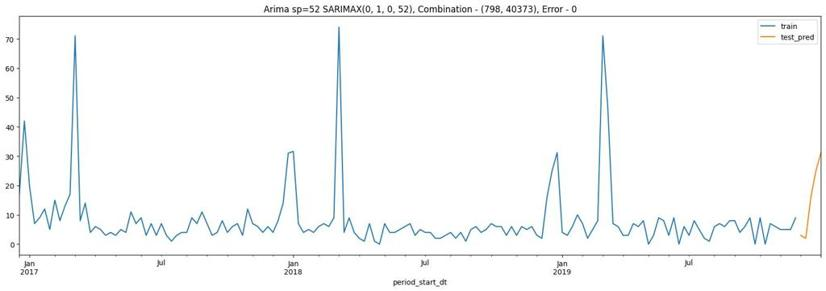

 47%|████▋     | 112/240 [1:11:58<59:13, 27.76s/it]  

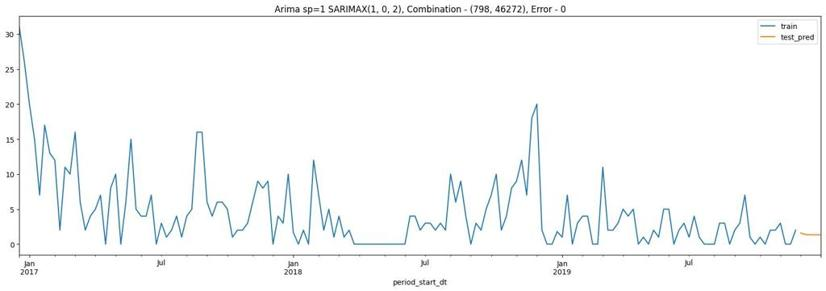

 47%|████▋     | 113/240 [1:11:59<42:05, 19.89s/it]

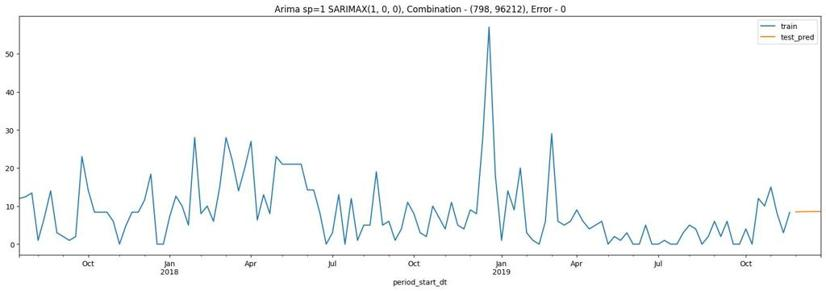

 48%|████▊     | 114/240 [1:12:00<29:38, 14.11s/it]

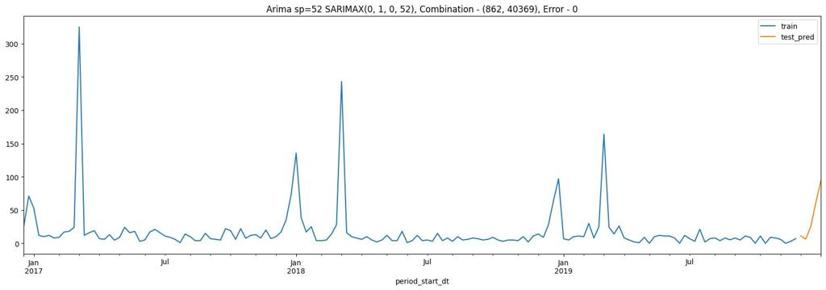

 48%|████▊     | 115/240 [1:12:20<33:07, 15.90s/it]

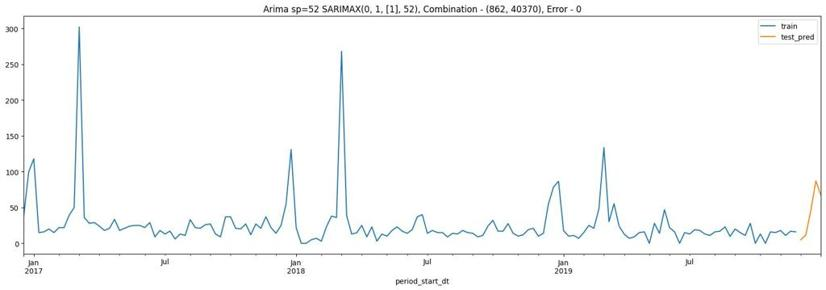

 48%|████▊     | 116/240 [1:13:19<59:46, 28.92s/it]

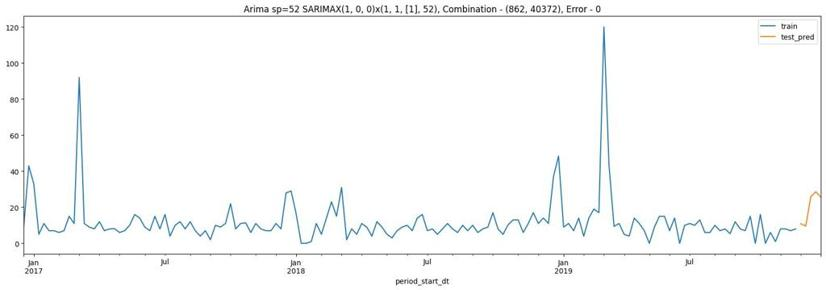

 49%|████▉     | 117/240 [1:15:27<2:00:10, 58.62s/it]

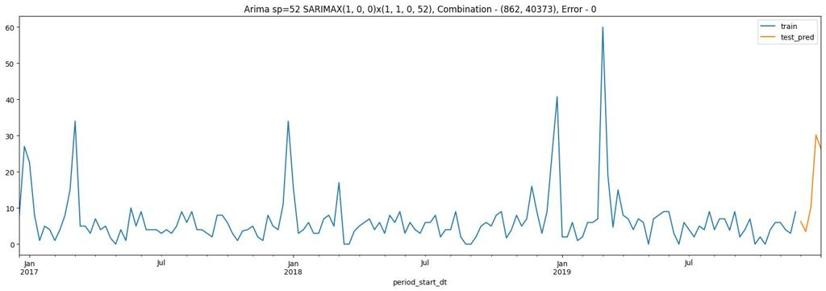

 49%|████▉     | 118/240 [1:17:16<2:29:47, 73.67s/it]

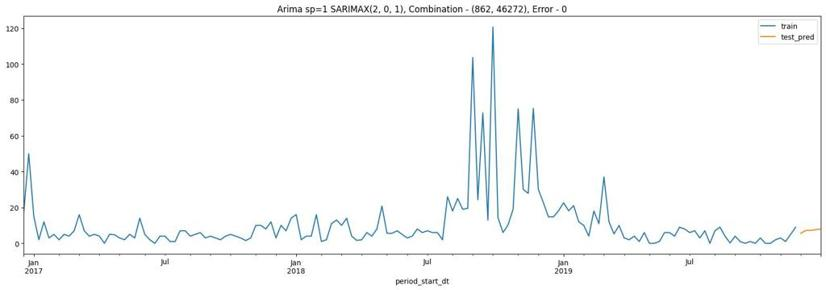

 50%|████▉     | 119/240 [1:17:17<1:44:38, 51.89s/it]

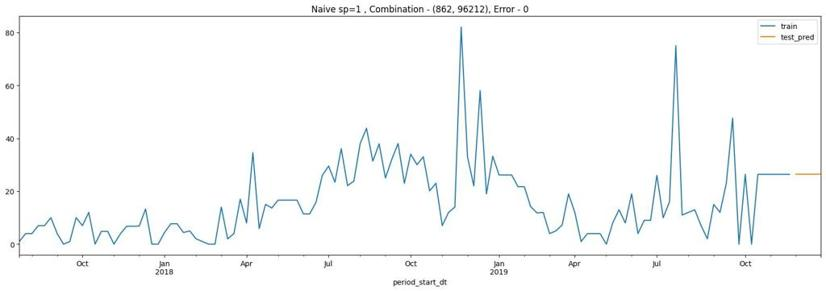

 50%|█████     | 120/240 [1:17:17<1:12:47, 36.39s/it]

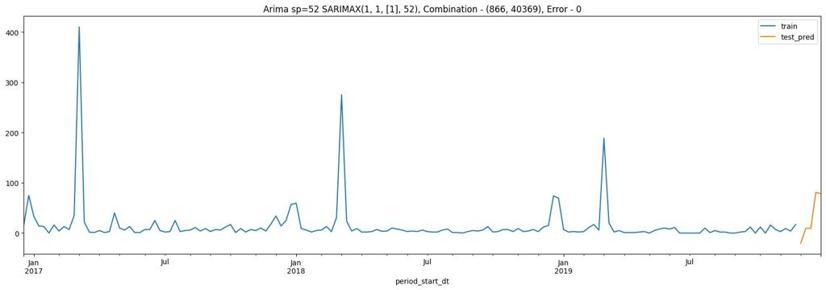

 50%|█████     | 121/240 [1:18:21<1:28:19, 44.54s/it]

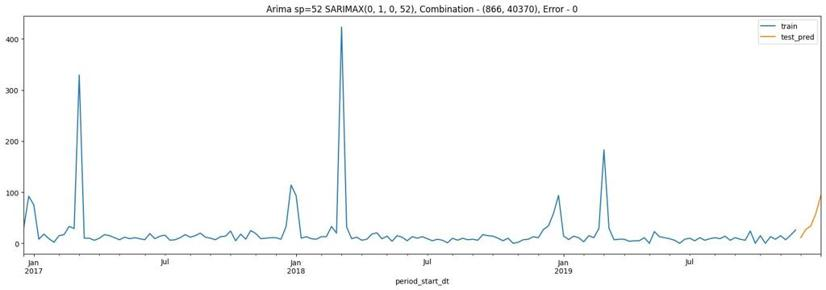

 51%|█████     | 122/240 [1:19:00<1:24:19, 42.88s/it]

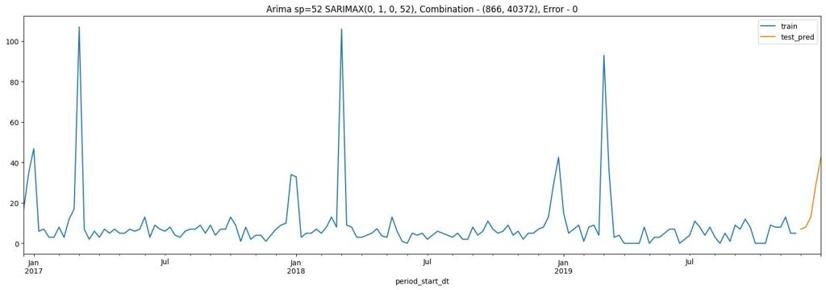

 51%|█████▏    | 123/240 [1:19:15<1:07:11, 34.46s/it]

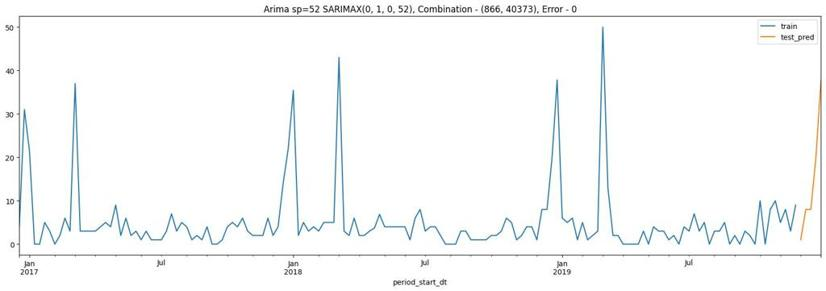

 52%|█████▏    | 124/240 [1:19:27<53:54, 27.88s/it]  

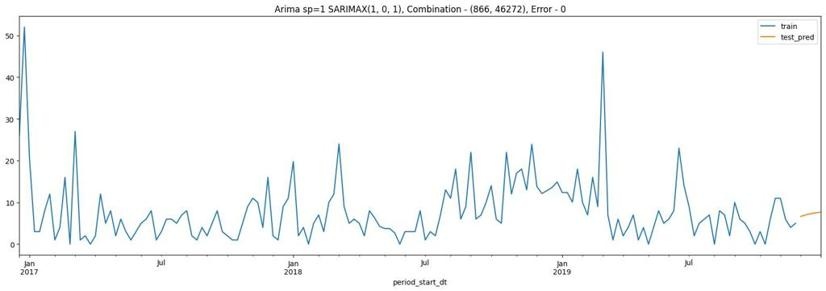

 52%|█████▏    | 125/240 [1:19:28<37:59, 19.82s/it]

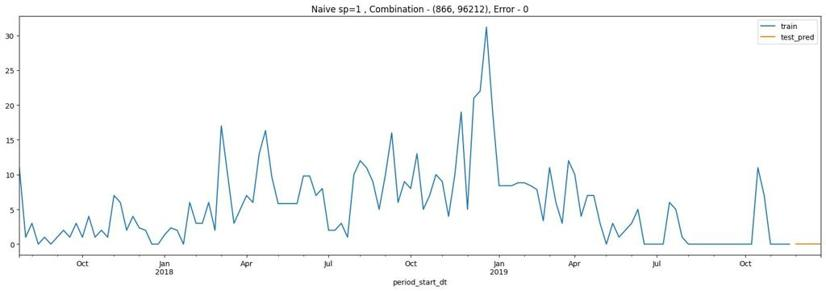

 52%|█████▎    | 126/240 [1:19:29<26:34, 13.99s/it]

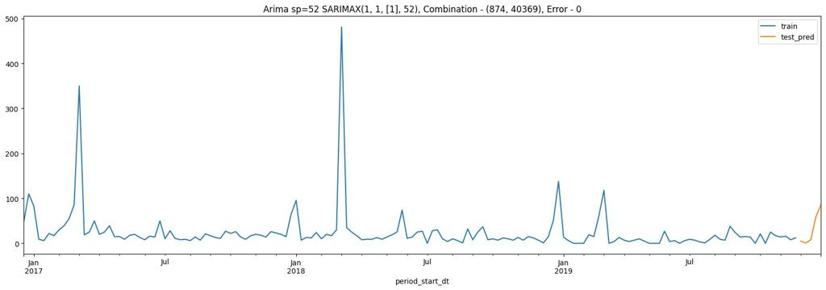

 53%|█████▎    | 127/240 [1:21:08<1:14:43, 39.67s/it]

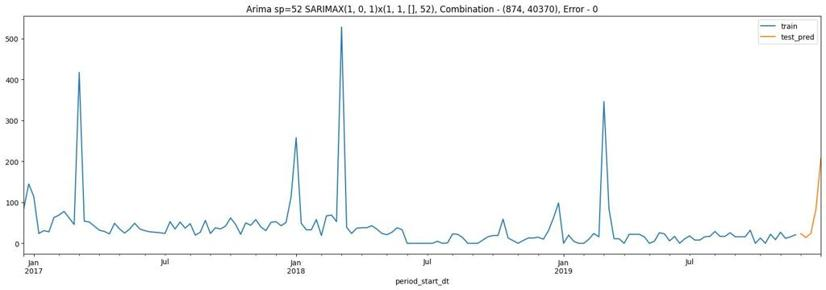

 53%|█████▎    | 128/240 [1:23:59<2:27:18, 78.92s/it]

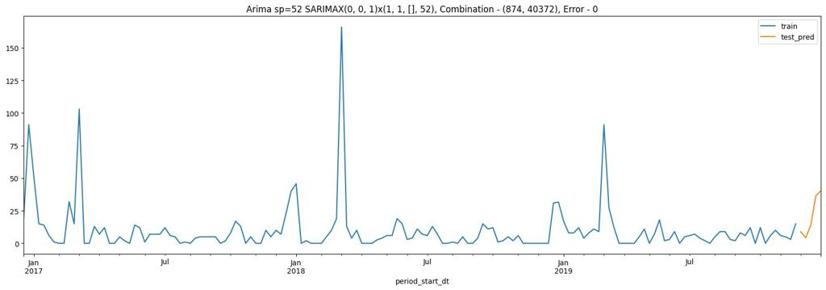

 54%|█████▍    | 129/240 [1:26:07<2:53:20, 93.70s/it]

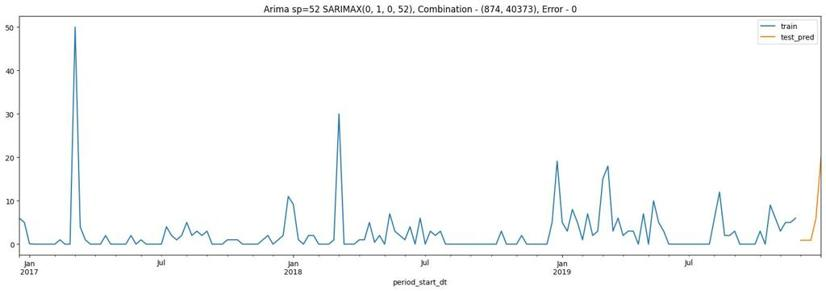

 54%|█████▍    | 130/240 [1:26:22<2:08:33, 70.12s/it]

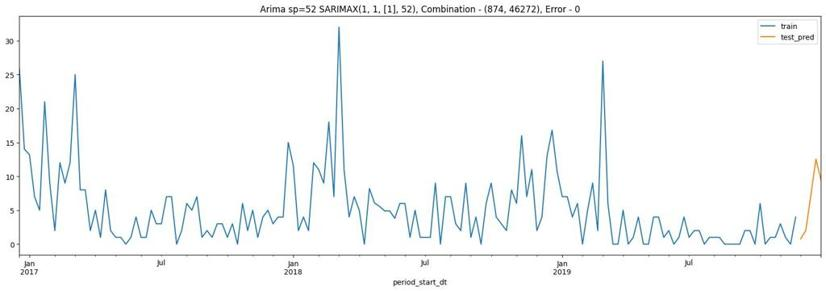

 55%|█████▍    | 131/240 [1:27:18<1:59:35, 65.83s/it]

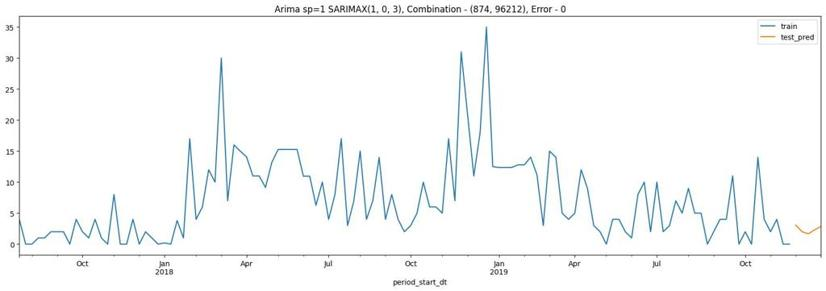

 55%|█████▌    | 132/240 [1:27:19<1:23:28, 46.38s/it]

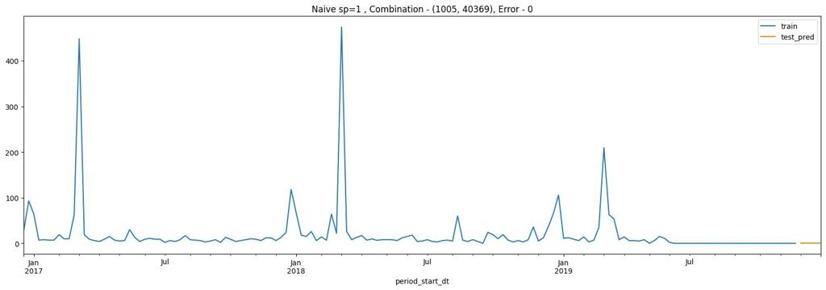

 55%|█████▌    | 133/240 [1:27:19<58:01, 32.54s/it]  

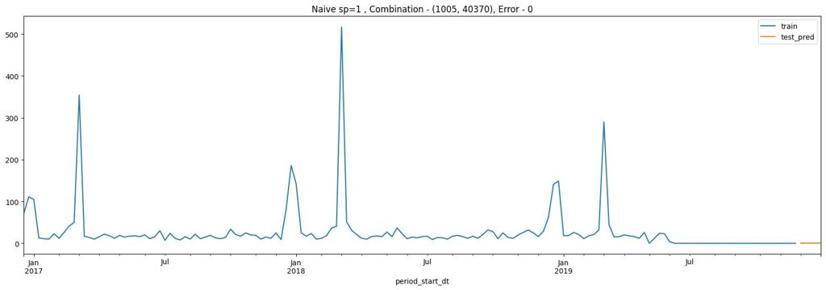

 56%|█████▌    | 134/240 [1:27:19<40:22, 22.86s/it]

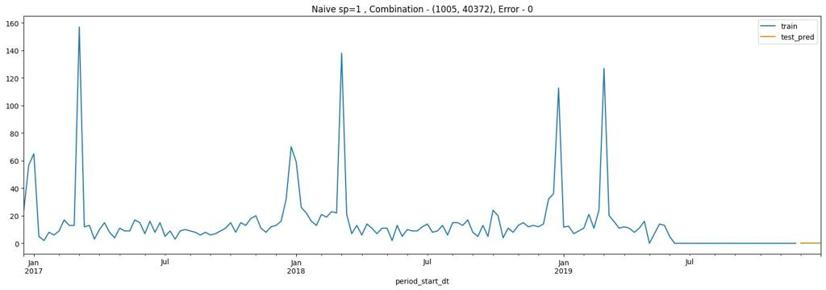

 56%|█████▋    | 135/240 [1:27:20<28:12, 16.12s/it]

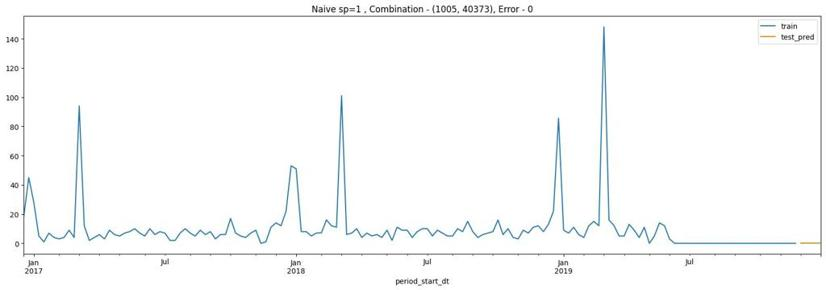

 57%|█████▋    | 136/240 [1:27:20<19:42, 11.37s/it]

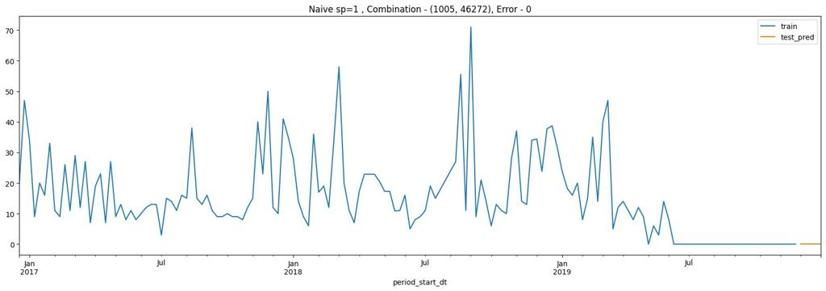

 57%|█████▋    | 137/240 [1:27:20<13:48,  8.04s/it]

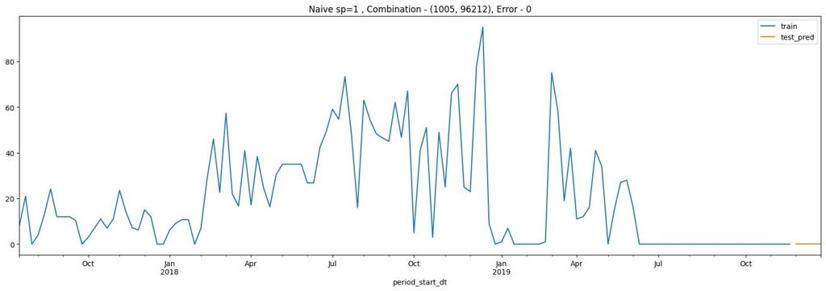

 57%|█████▊    | 138/240 [1:27:21<09:41,  5.70s/it]

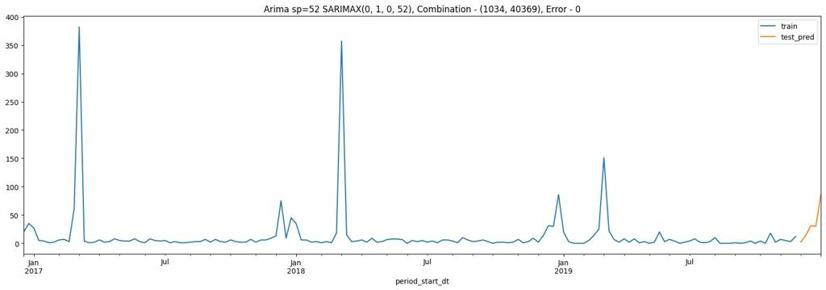

 58%|█████▊    | 139/240 [1:27:51<21:54, 13.01s/it]

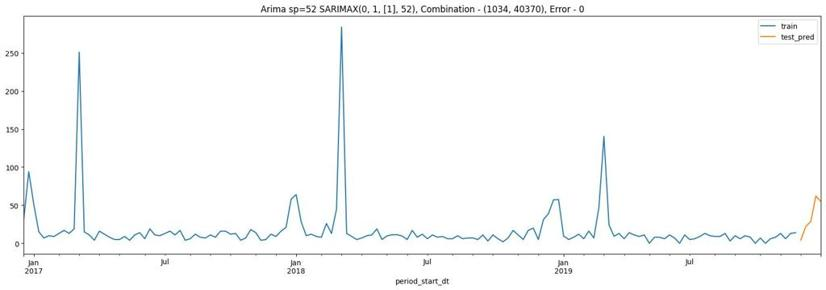

 58%|█████▊    | 140/240 [1:28:47<43:25, 26.06s/it]

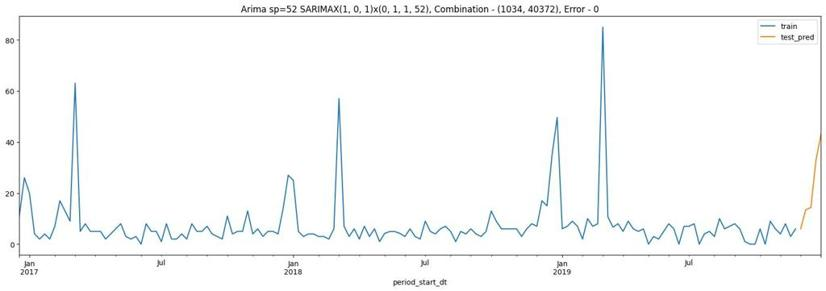

 59%|█████▉    | 141/240 [1:31:10<1:41:02, 61.23s/it]

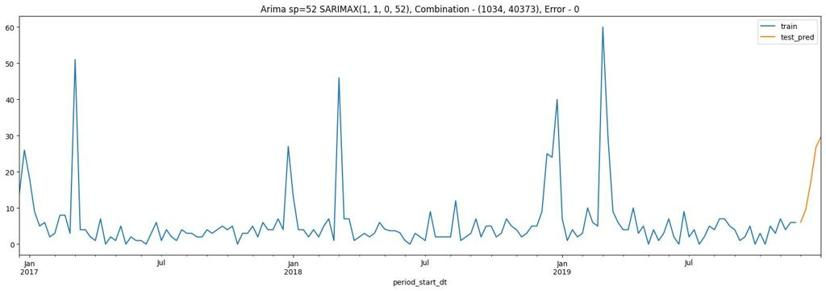

 59%|█████▉    | 142/240 [1:31:40<1:24:30, 51.74s/it]

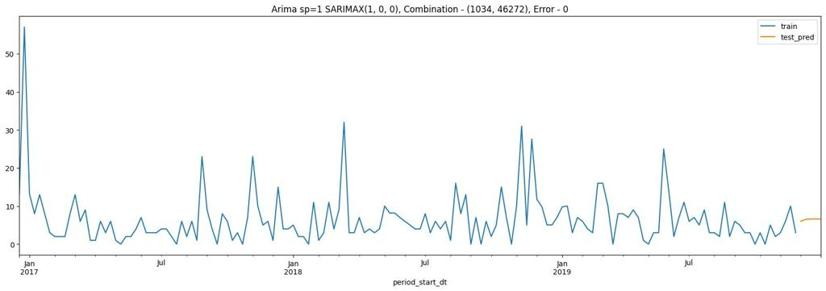

 60%|█████▉    | 143/240 [1:31:41<58:57, 36.47s/it]  

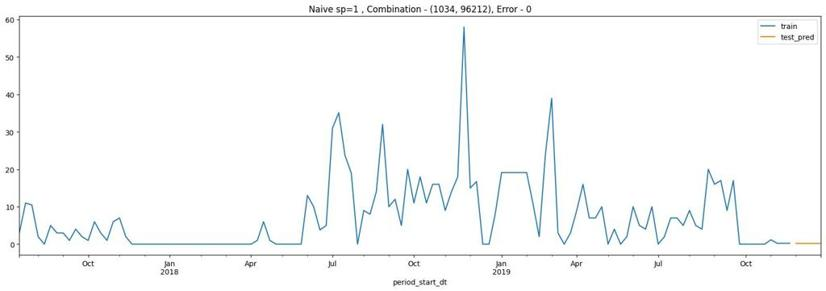

 60%|██████    | 144/240 [1:31:41<40:58, 25.61s/it]

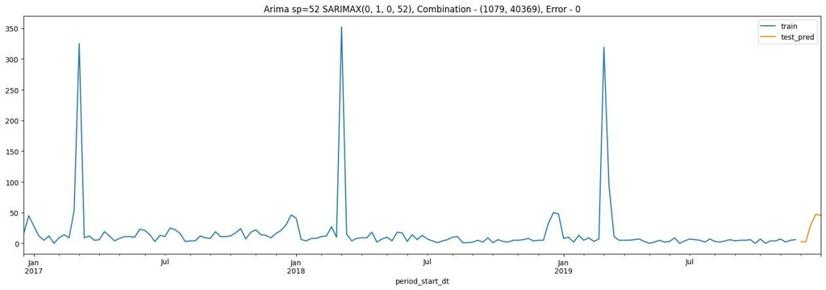

 60%|██████    | 145/240 [1:31:59<36:46, 23.22s/it]

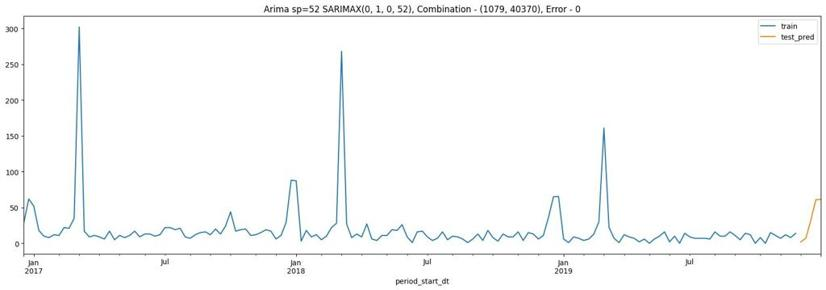

 61%|██████    | 146/240 [1:32:16<33:29, 21.38s/it]

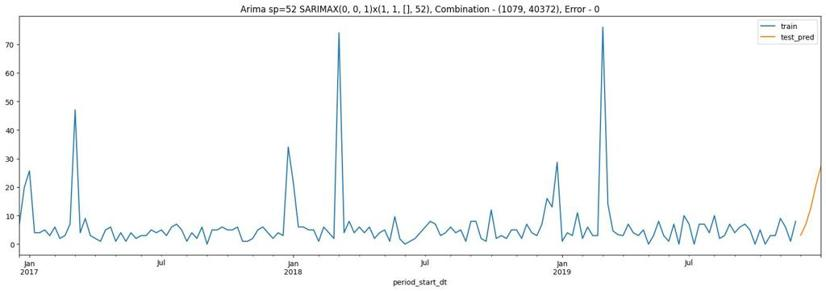

 61%|██████▏   | 147/240 [1:32:47<37:32, 24.22s/it]

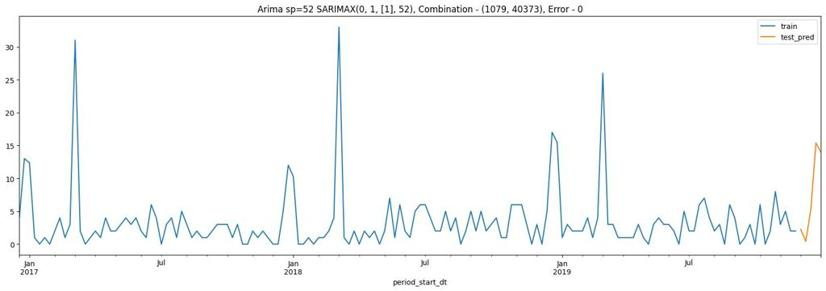

 62%|██████▏   | 148/240 [1:33:17<39:53, 26.02s/it]

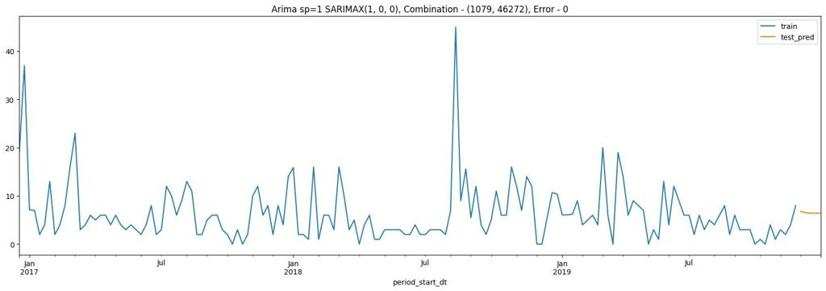

 62%|██████▏   | 149/240 [1:33:18<27:53, 18.39s/it]

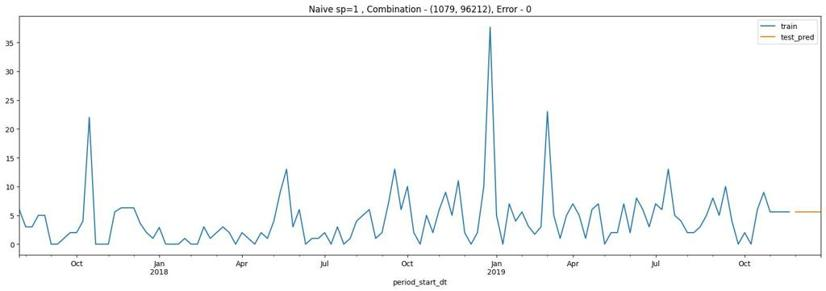

 62%|██████▎   | 150/240 [1:33:18<19:25, 12.95s/it]

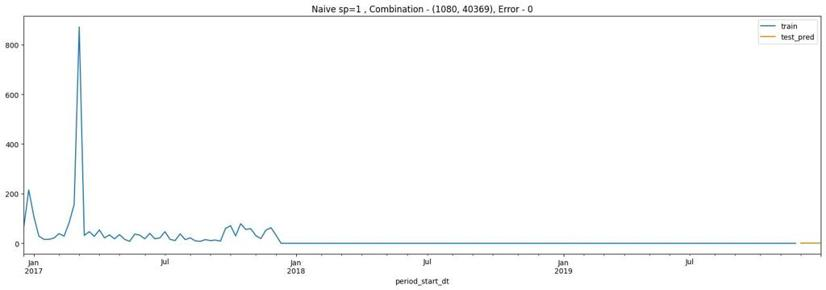

 63%|██████▎   | 151/240 [1:33:18<13:34,  9.15s/it]

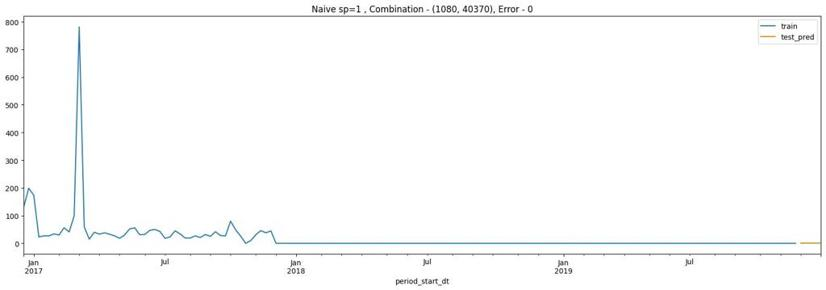

 63%|██████▎   | 152/240 [1:33:18<09:30,  6.49s/it]

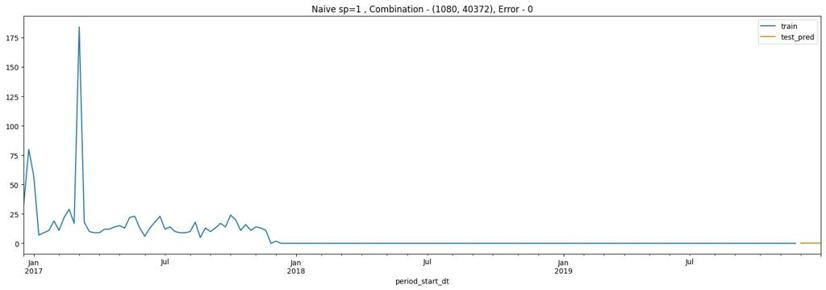

 64%|██████▍   | 153/240 [1:33:19<06:42,  4.62s/it]

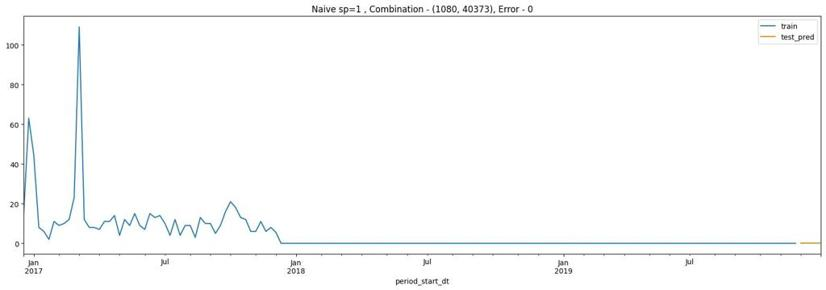

 64%|██████▍   | 154/240 [1:33:19<04:48,  3.35s/it]

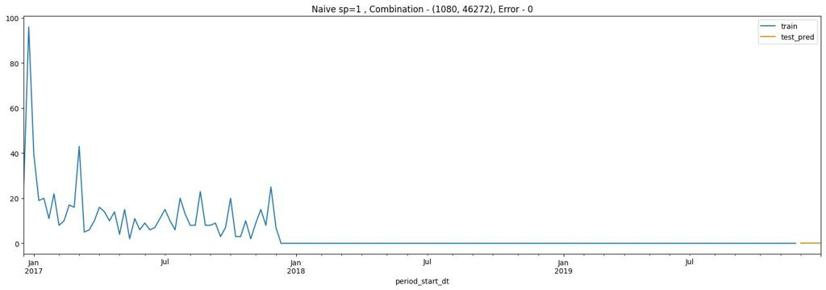

 65%|██████▍   | 155/240 [1:33:19<03:26,  2.43s/it]

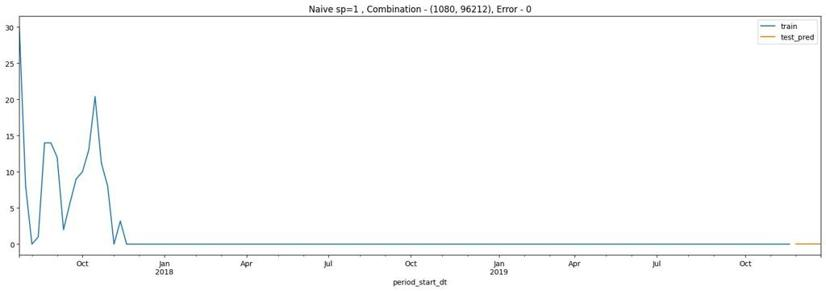

 65%|██████▌   | 156/240 [1:33:20<02:29,  1.78s/it]

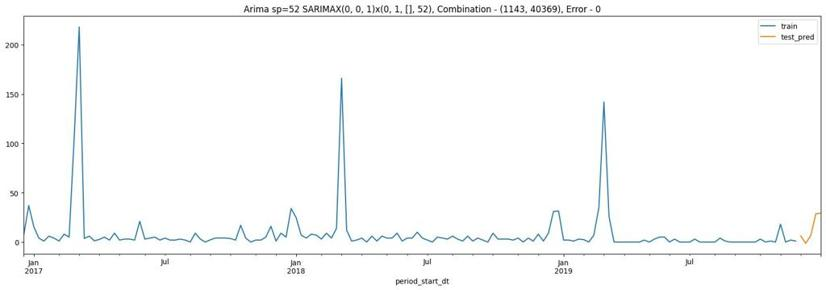

 65%|██████▌   | 157/240 [1:33:38<09:34,  6.92s/it]

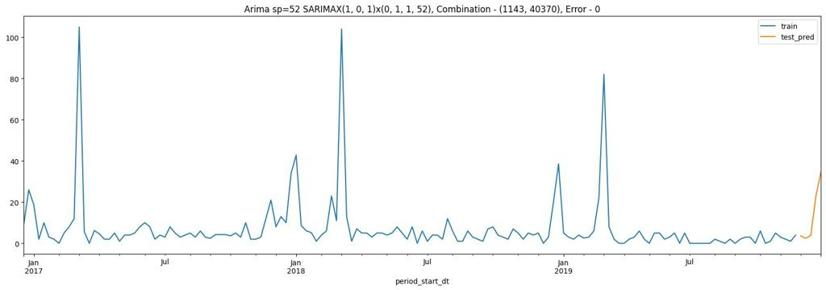

 66%|██████▌   | 158/240 [1:36:28<1:15:56, 55.56s/it]

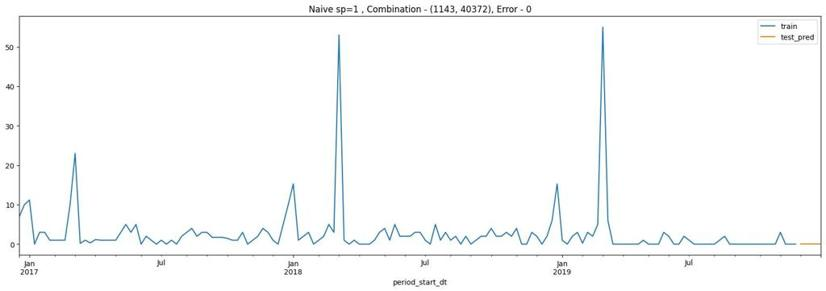

 66%|██████▋   | 159/240 [1:36:28<52:36, 38.98s/it]  

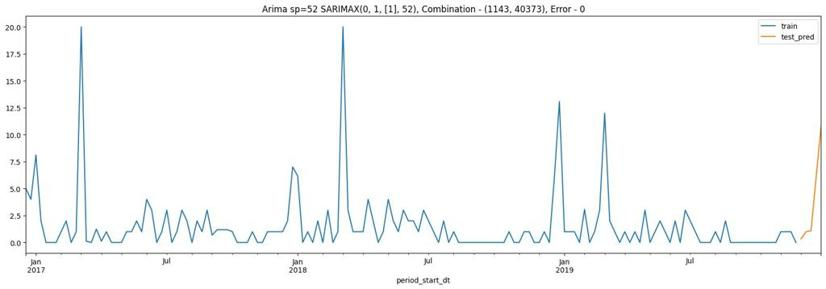

 67%|██████▋   | 160/240 [1:37:02<50:00, 37.51s/it]

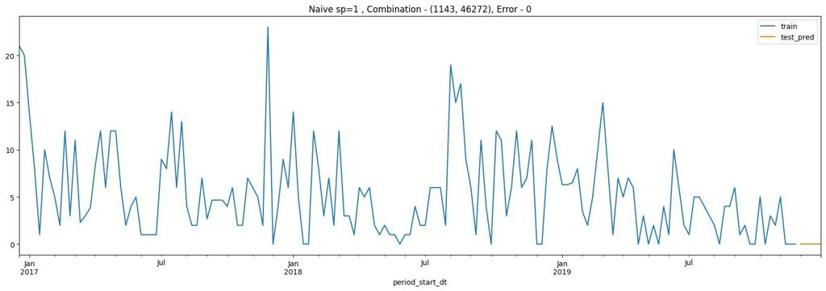

 67%|██████▋   | 161/240 [1:37:02<34:40, 26.34s/it]

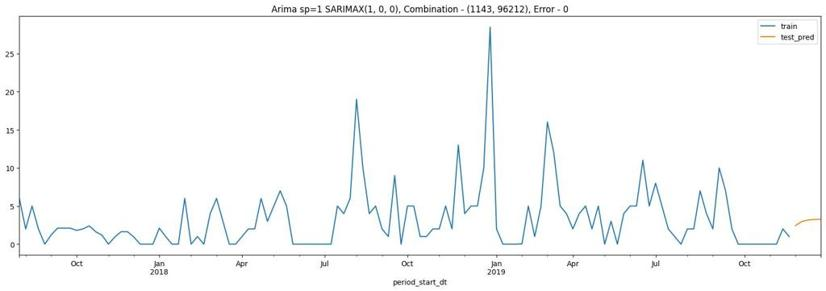

 68%|██████▊   | 162/240 [1:37:03<24:11, 18.61s/it]

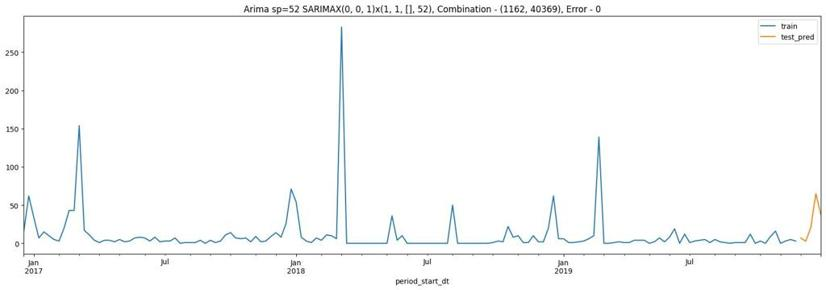

 68%|██████▊   | 163/240 [1:38:29<49:52, 38.86s/it]

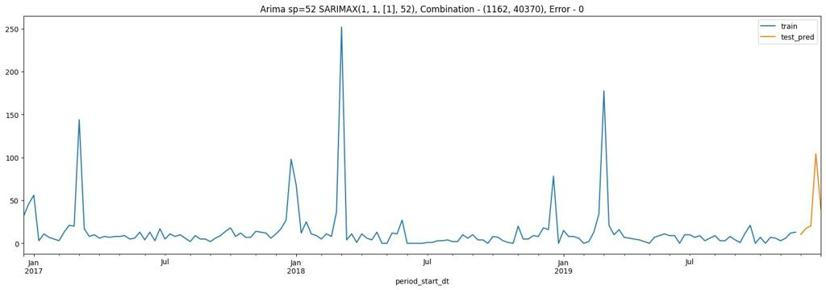

 68%|██████▊   | 164/240 [1:40:08<1:12:07, 56.95s/it]

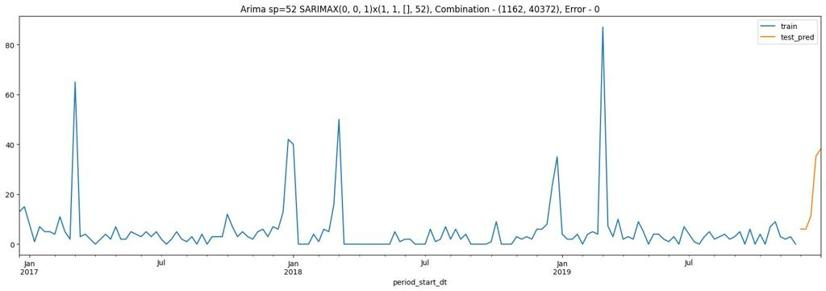

 69%|██████▉   | 165/240 [1:42:18<1:38:32, 78.84s/it]

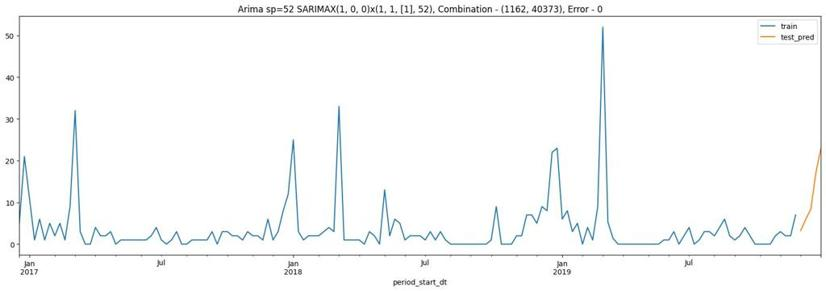

 69%|██████▉   | 166/240 [1:43:29<1:34:19, 76.48s/it]

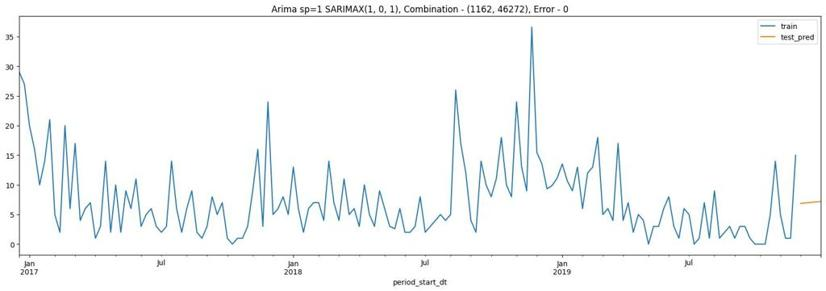

 70%|██████▉   | 167/240 [1:43:30<1:05:26, 53.79s/it]

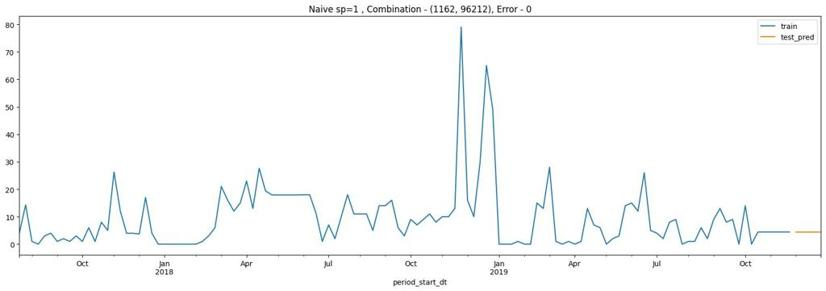

 70%|███████   | 168/240 [1:43:30<45:16, 37.74s/it]  

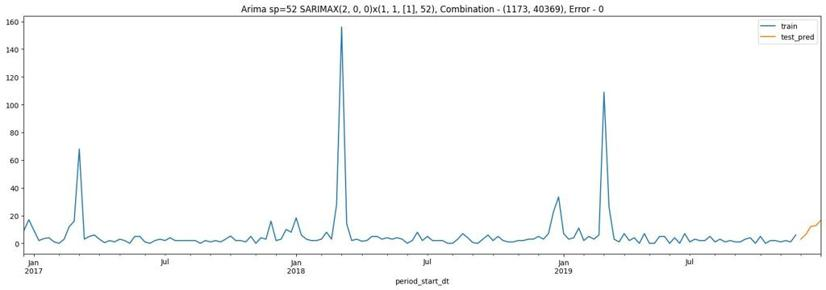

 70%|███████   | 169/240 [1:45:06<1:05:27, 55.32s/it]

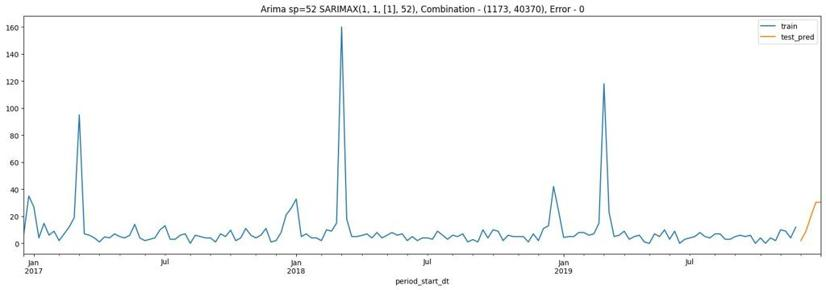

 71%|███████   | 170/240 [1:46:38<1:17:22, 66.32s/it]

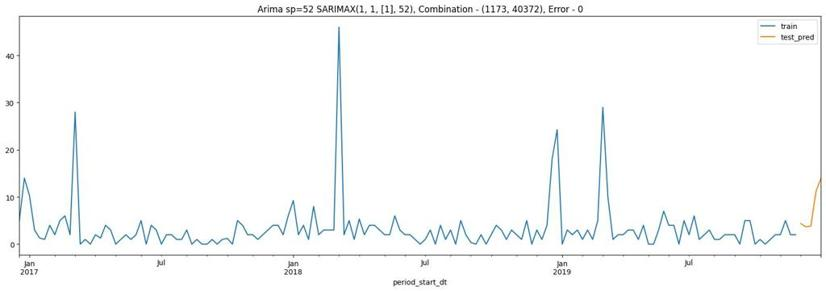

 71%|███████▏  | 171/240 [1:47:28<1:10:27, 61.27s/it]

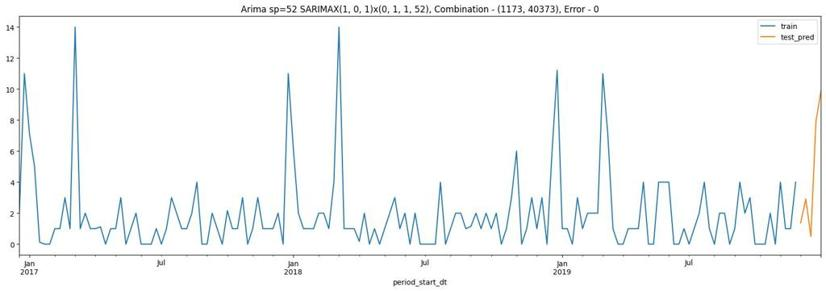

 72%|███████▏  | 172/240 [1:49:05<1:21:46, 72.15s/it]

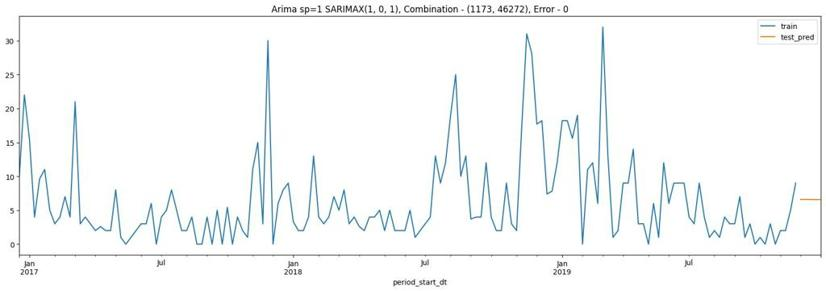

 72%|███████▏  | 173/240 [1:49:06<56:40, 50.75s/it]  

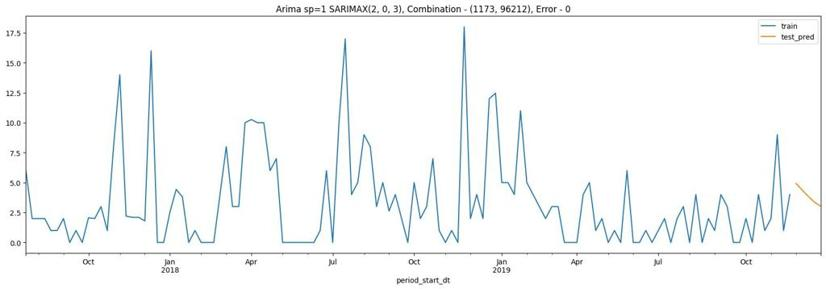

 72%|███████▎  | 174/240 [1:49:07<39:26, 35.85s/it]

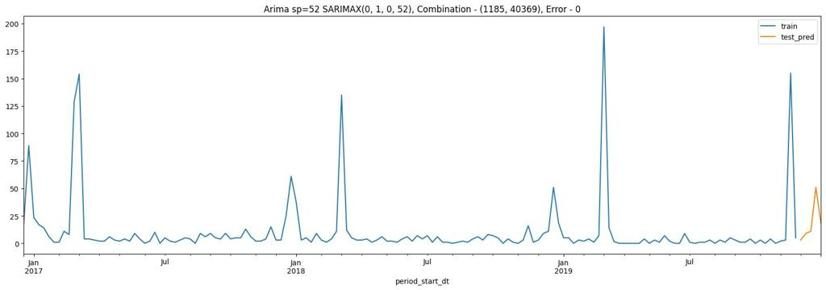

 73%|███████▎  | 175/240 [1:49:24<32:30, 30.01s/it]

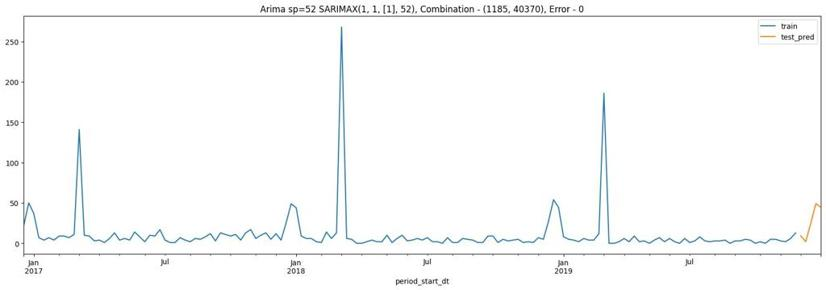

 73%|███████▎  | 176/240 [1:50:27<42:38, 39.98s/it]

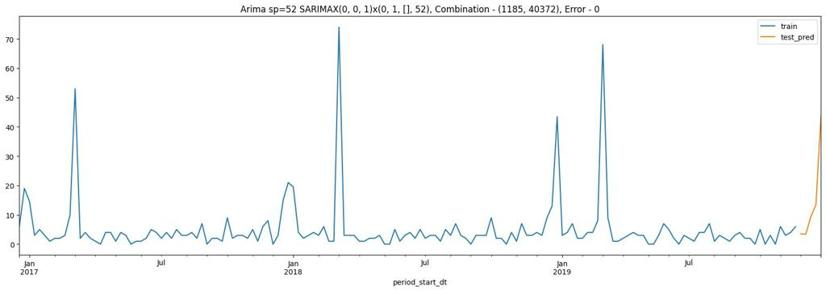

 74%|███████▍  | 177/240 [1:50:40<33:23, 31.80s/it]

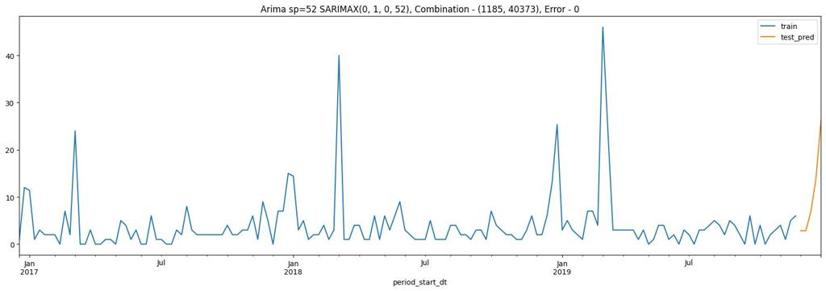

 74%|███████▍  | 178/240 [1:50:53<27:14, 26.37s/it]

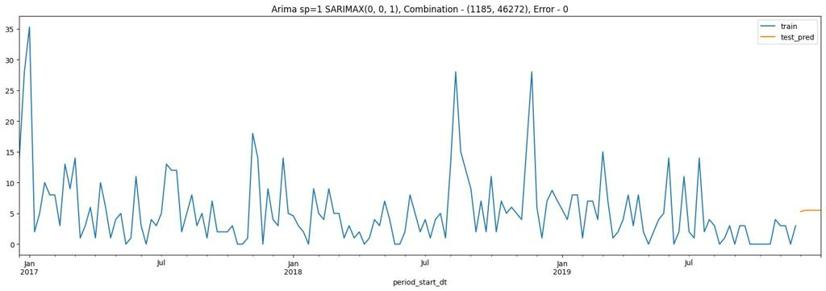

 75%|███████▍  | 179/240 [1:50:54<19:00, 18.69s/it]

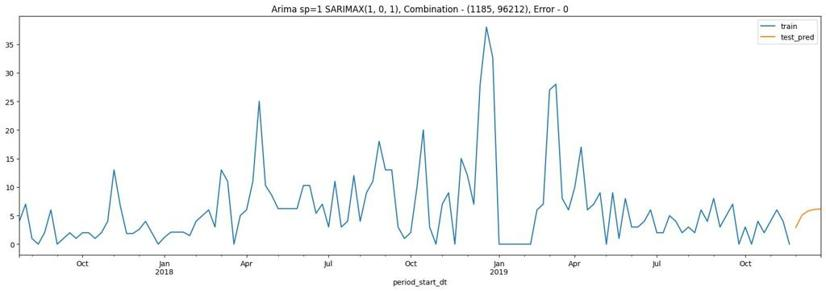

 75%|███████▌  | 180/240 [1:50:55<13:16, 13.27s/it]

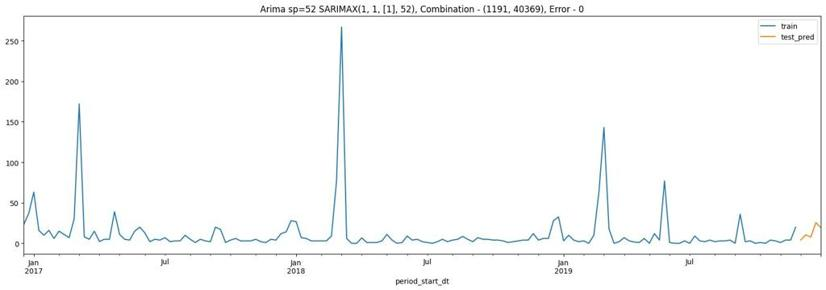

 75%|███████▌  | 181/240 [1:52:29<36:49, 37.45s/it]

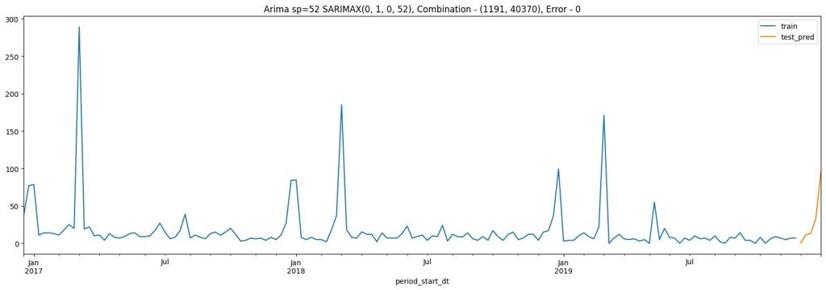

 76%|███████▌  | 182/240 [1:52:48<30:53, 31.95s/it]

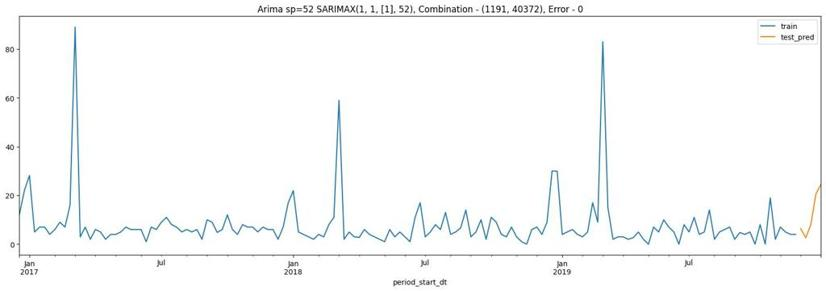

 76%|███████▋  | 183/240 [1:54:01<42:04, 44.28s/it]

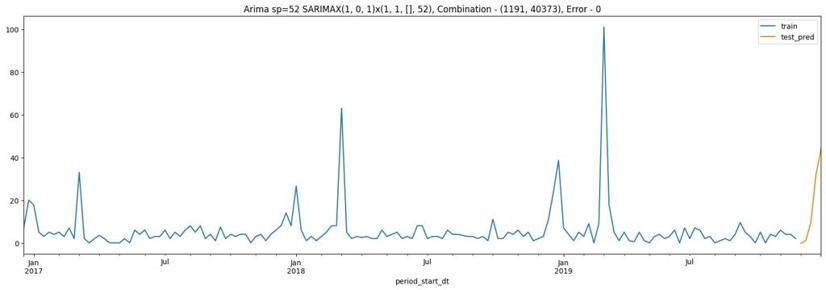

 77%|███████▋  | 184/240 [1:56:34<1:11:41, 76.82s/it]

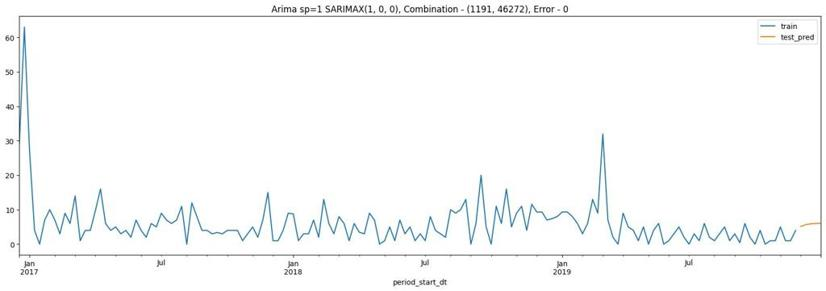

 77%|███████▋  | 185/240 [1:56:34<49:28, 53.98s/it]  

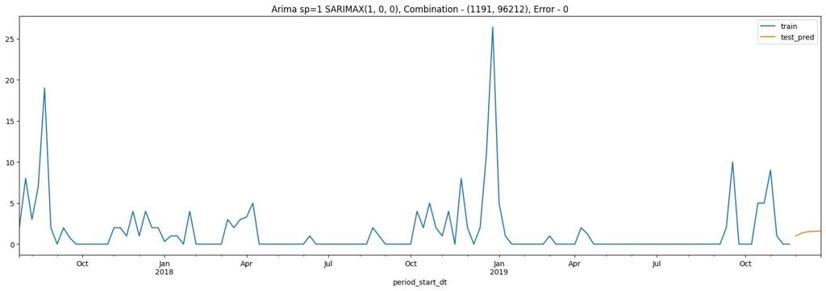

 78%|███████▊  | 186/240 [1:56:35<34:09, 37.95s/it]

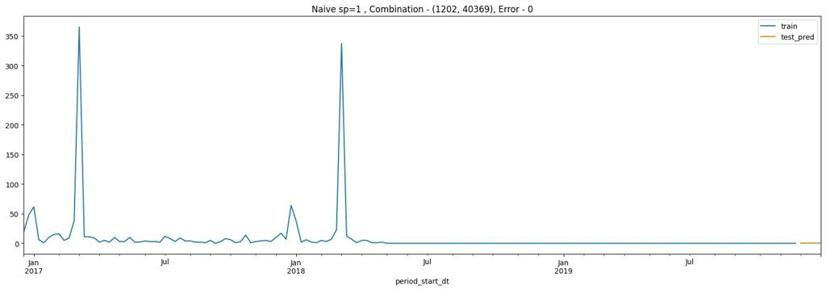

 78%|███████▊  | 187/240 [1:56:35<23:34, 26.69s/it]

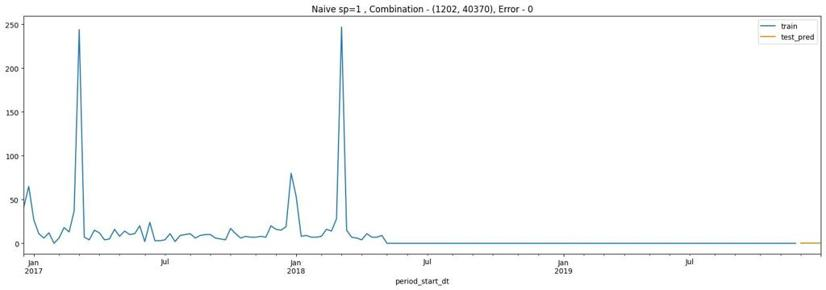

 78%|███████▊  | 188/240 [1:56:35<16:15, 18.76s/it]

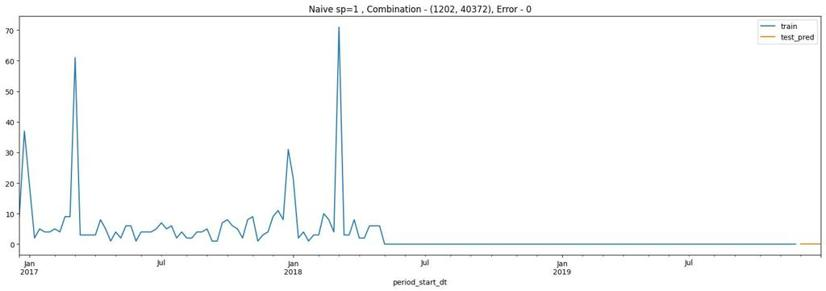

 79%|███████▉  | 189/240 [1:56:36<11:14, 13.22s/it]

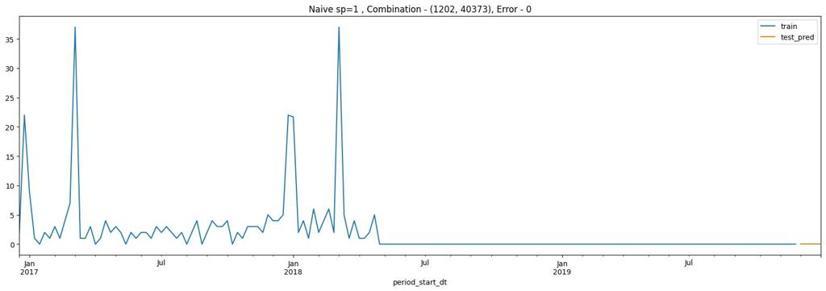

 79%|███████▉  | 190/240 [1:56:36<07:46,  9.33s/it]

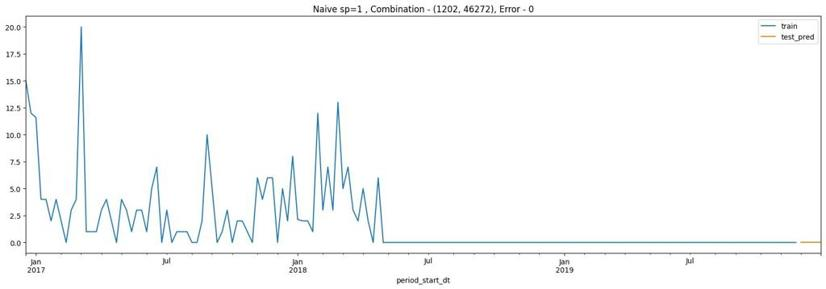

 80%|███████▉  | 191/240 [1:56:36<05:24,  6.62s/it]

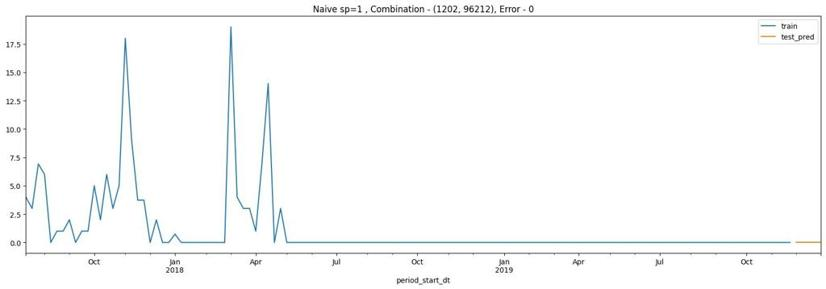

 80%|████████  | 192/240 [1:56:37<03:46,  4.71s/it]

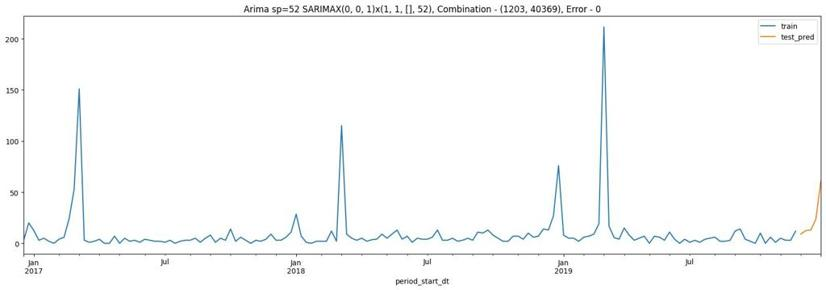

 80%|████████  | 193/240 [1:57:23<13:31, 17.27s/it]

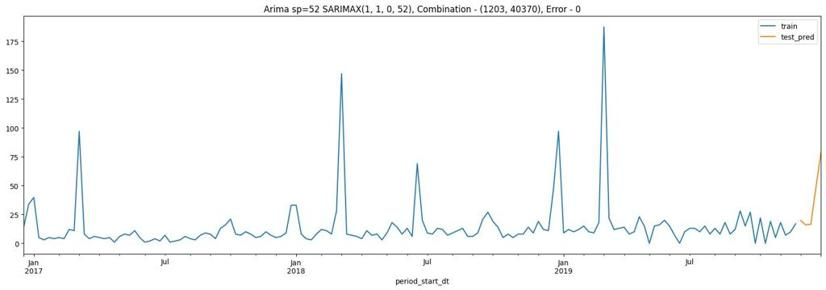

 81%|████████  | 194/240 [1:57:58<17:23, 22.68s/it]

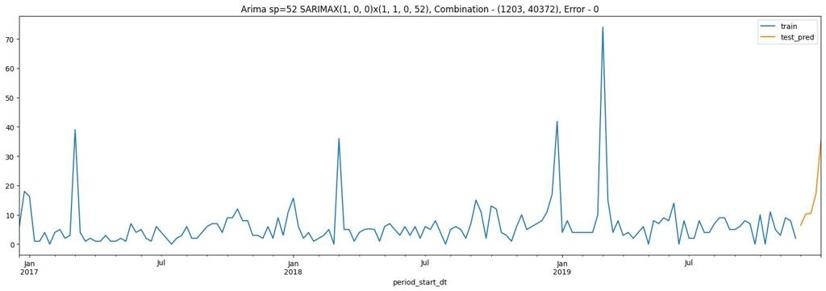

 81%|████████▏ | 195/240 [1:58:38<20:50, 27.79s/it]

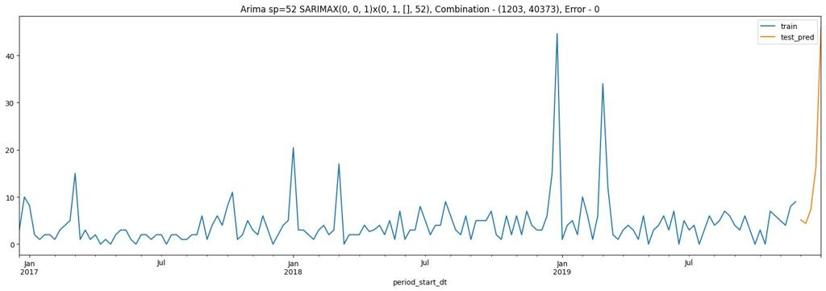

 82%|████████▏ | 196/240 [1:58:54<17:48, 24.27s/it]

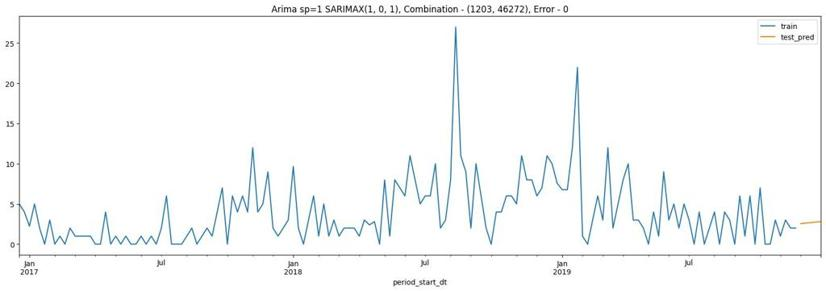

 82%|████████▏ | 197/240 [1:58:55<12:23, 17.29s/it]

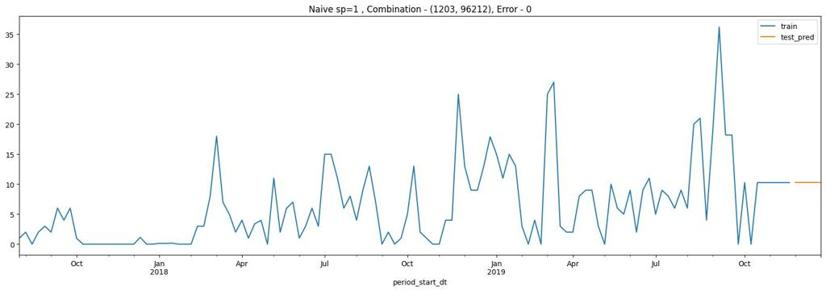

 82%|████████▎ | 198/240 [1:58:55<08:31, 12.18s/it]

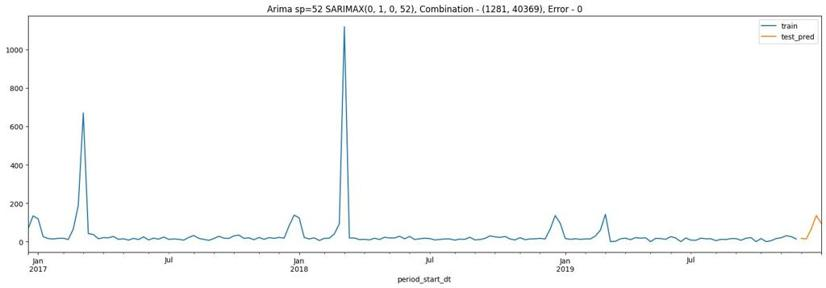

 83%|████████▎ | 199/240 [1:59:35<13:58, 20.46s/it]

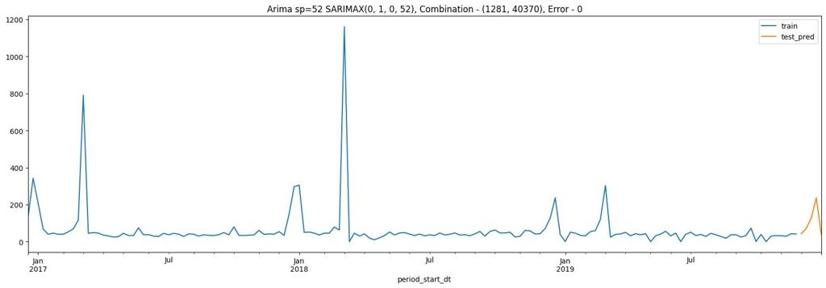

 83%|████████▎ | 200/240 [2:00:18<18:11, 27.29s/it]

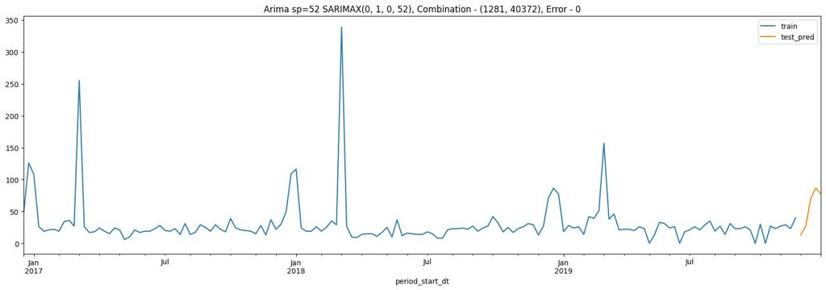

 84%|████████▍ | 201/240 [2:02:22<36:27, 56.08s/it]

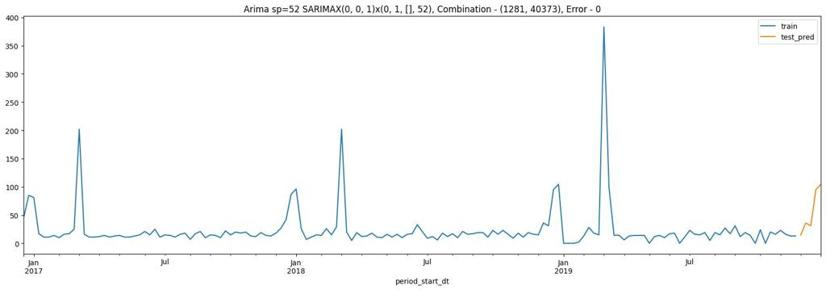

 84%|████████▍ | 202/240 [2:04:12<45:52, 72.44s/it]

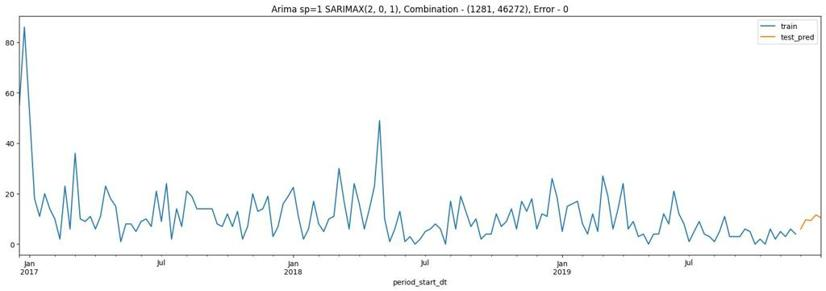

 85%|████████▍ | 203/240 [2:04:14<31:37, 51.28s/it]

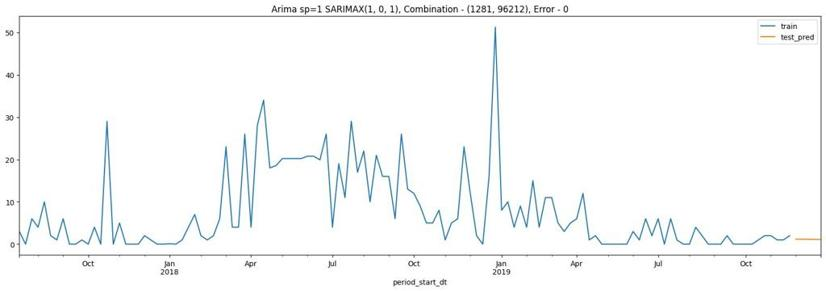

 85%|████████▌ | 204/240 [2:04:16<21:48, 36.36s/it]

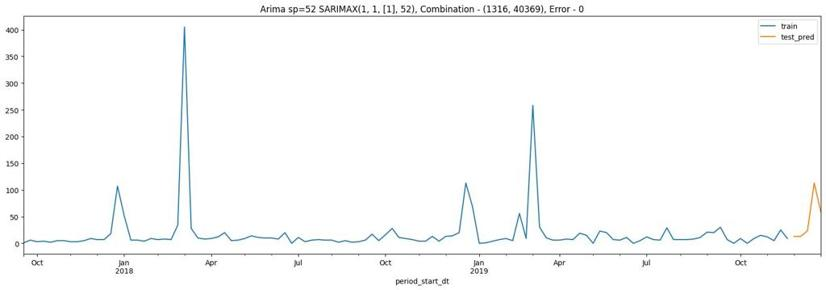

 85%|████████▌ | 205/240 [2:06:45<40:59, 70.28s/it]

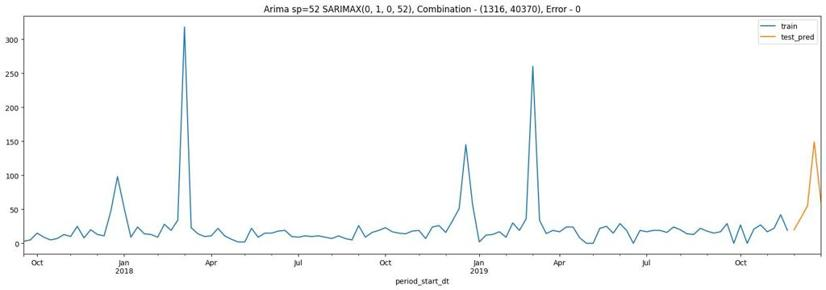

 86%|████████▌ | 206/240 [2:07:39<37:04, 65.42s/it]

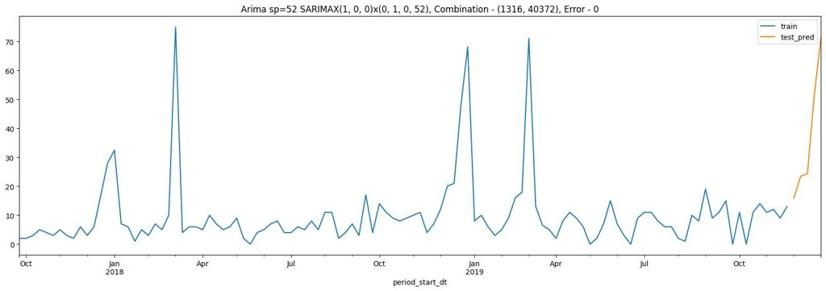

 86%|████████▋ | 207/240 [2:09:50<46:50, 85.16s/it]

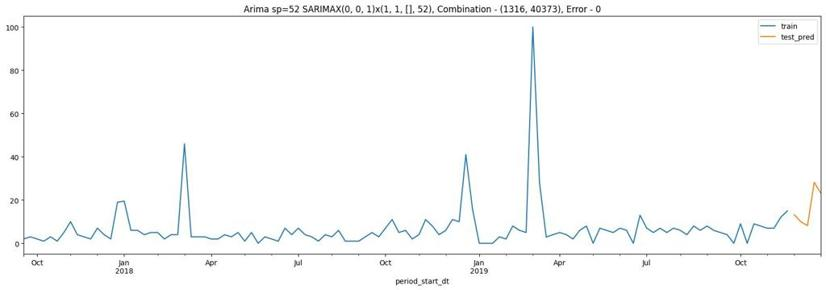

 87%|████████▋ | 208/240 [2:14:24<1:15:36, 141.77s/it]

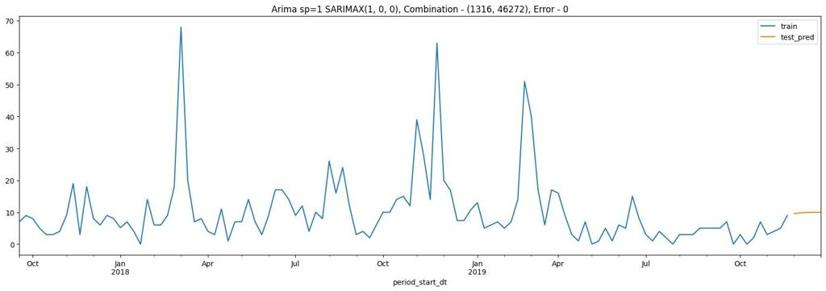

 87%|████████▋ | 209/240 [2:14:25<51:22, 99.44s/it]   

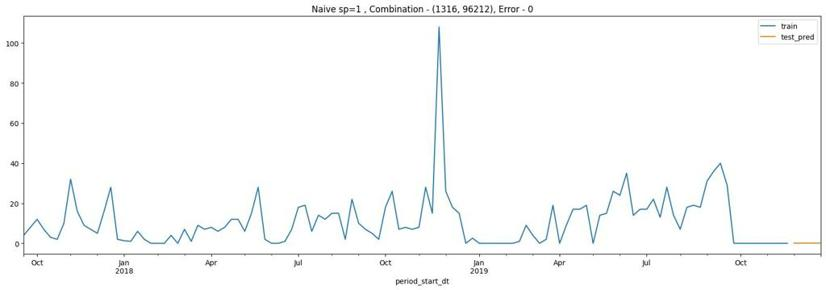

 88%|████████▊ | 210/240 [2:14:25<34:50, 69.70s/it]

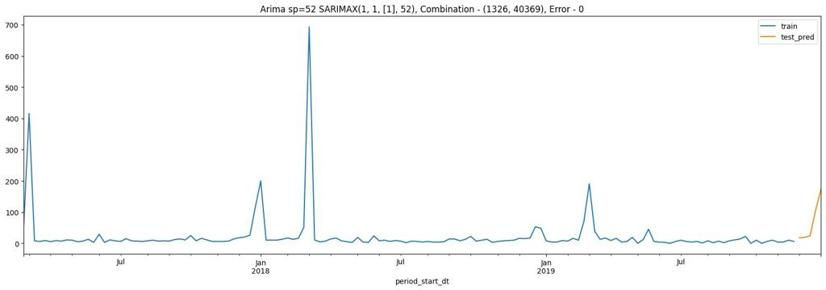

 88%|████████▊ | 211/240 [2:22:19<1:32:15, 190.87s/it]

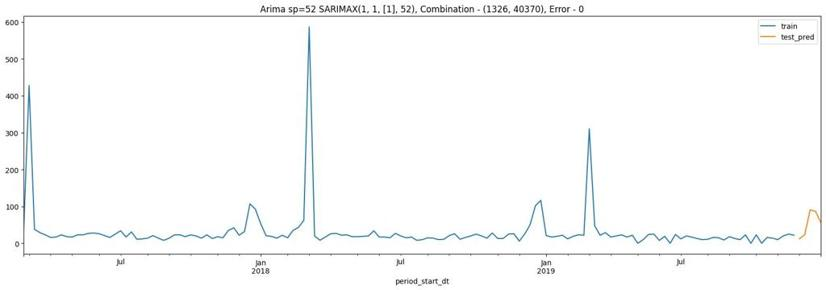

 88%|████████▊ | 212/240 [2:26:45<1:39:39, 213.54s/it]

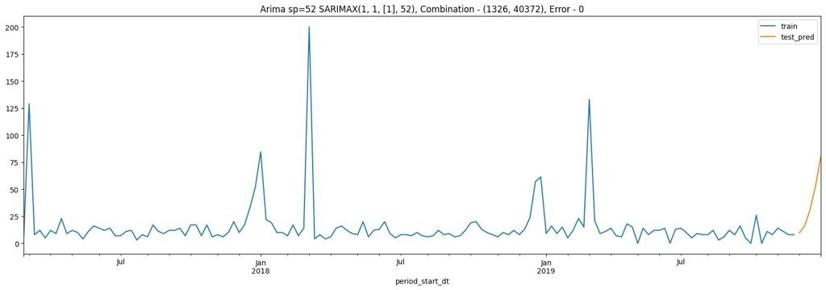

 89%|████████▉ | 213/240 [2:30:22<1:36:29, 214.44s/it]

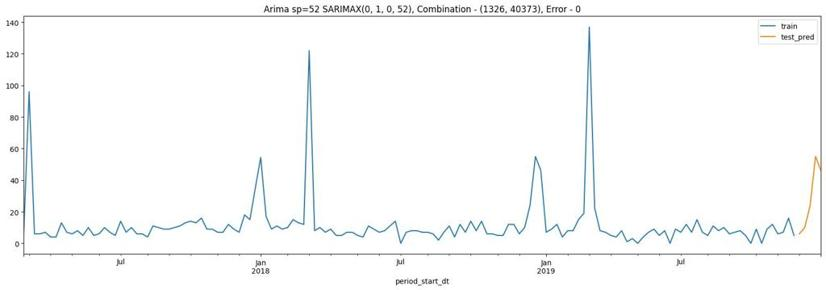

 89%|████████▉ | 214/240 [2:30:55<1:09:21, 160.07s/it]

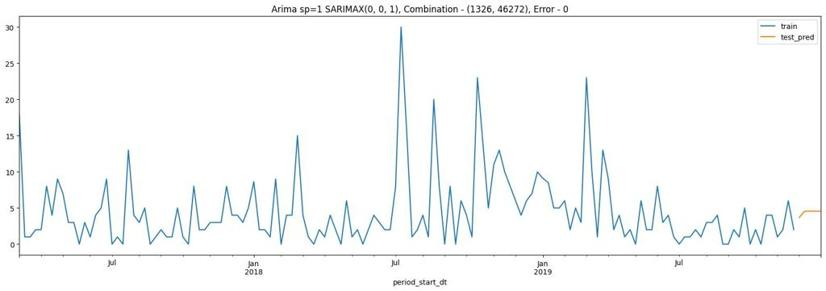

 90%|████████▉ | 215/240 [2:30:56<46:47, 112.29s/it]  

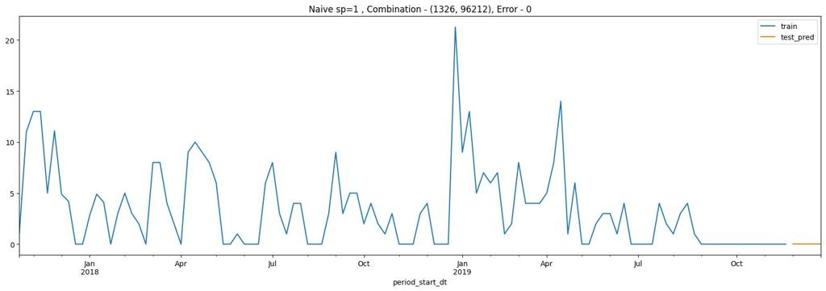

 90%|█████████ | 216/240 [2:30:56<31:28, 78.68s/it] 

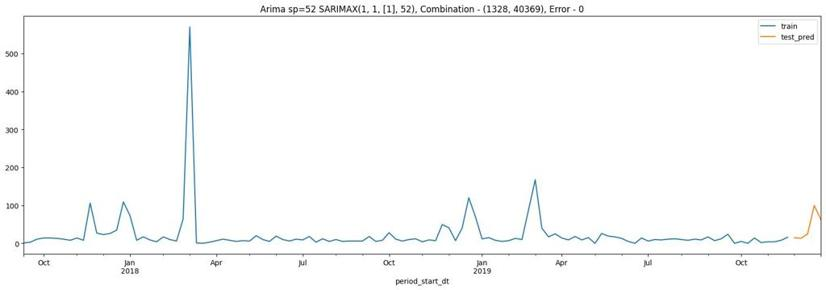

 90%|█████████ | 217/240 [2:34:40<46:53, 122.32s/it]

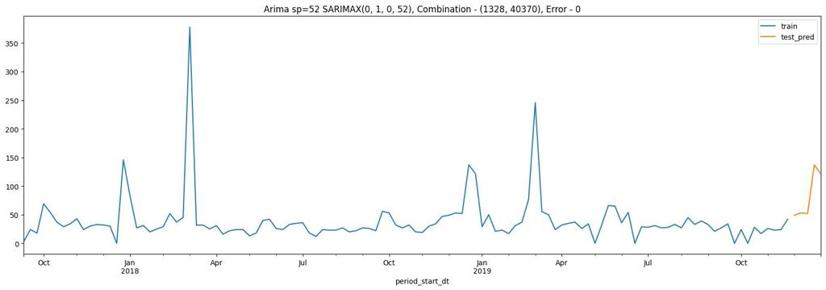

 91%|█████████ | 218/240 [2:35:25<36:21, 99.16s/it] 

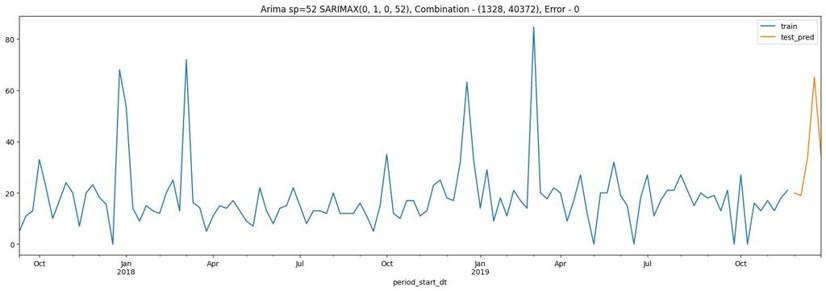

 91%|█████████▏| 219/240 [2:35:54<27:15, 77.88s/it]

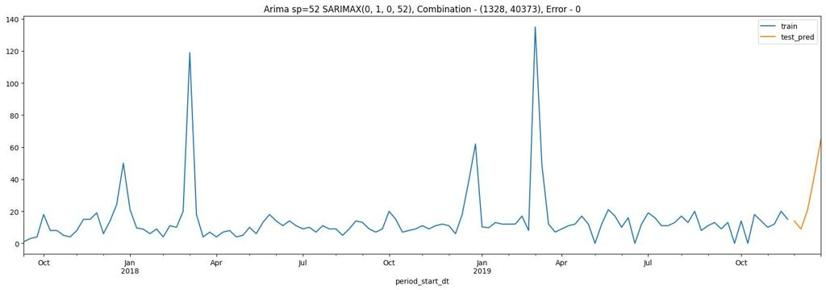

 92%|█████████▏| 220/240 [2:36:34<22:10, 66.53s/it]

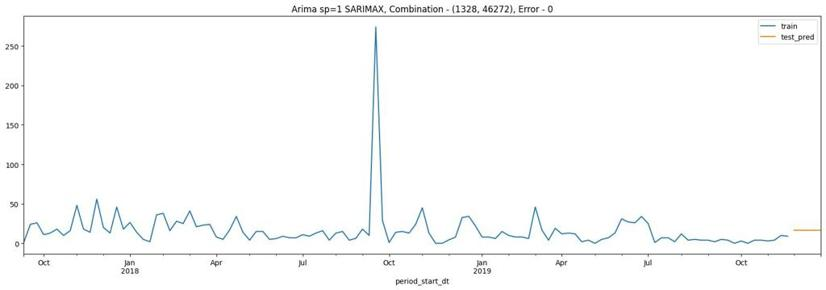

 92%|█████████▏| 221/240 [2:36:34<14:48, 46.74s/it]

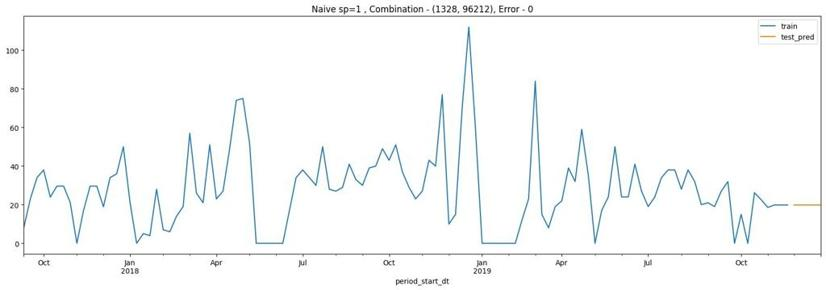

 92%|█████████▎| 222/240 [2:36:35<09:50, 32.80s/it]

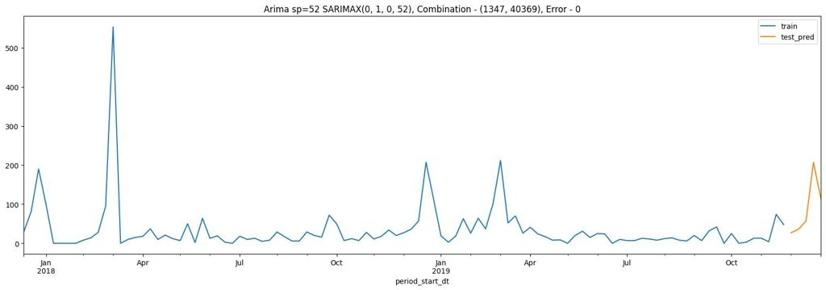

 93%|█████████▎| 223/240 [2:38:28<16:07, 56.92s/it]

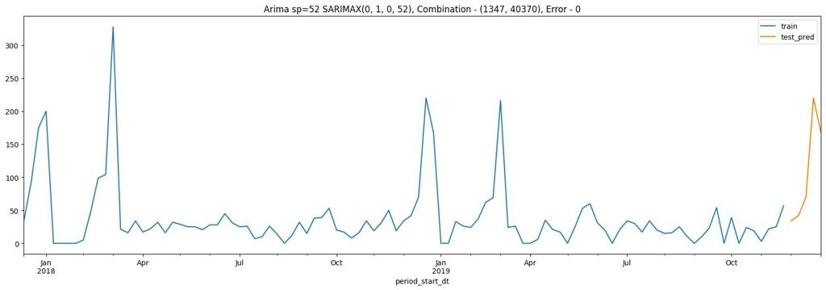

 93%|█████████▎| 224/240 [2:40:33<20:40, 77.51s/it]

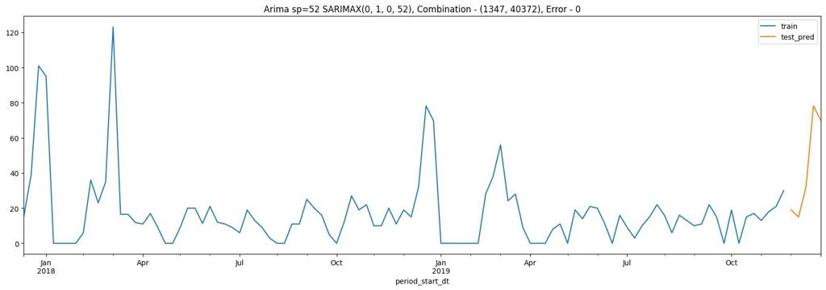

 94%|█████████▍| 225/240 [2:42:53<24:01, 96.07s/it]

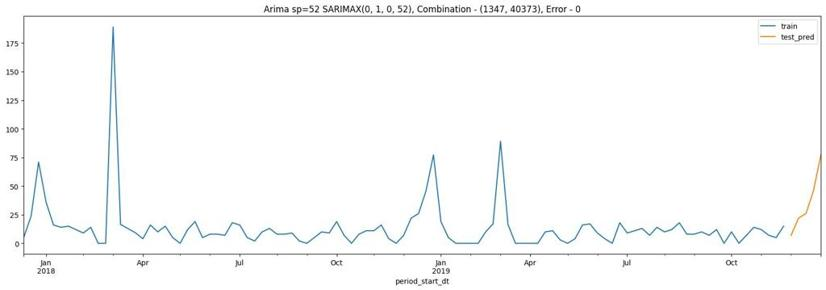

 94%|█████████▍| 226/240 [2:44:33<22:44, 97.45s/it]

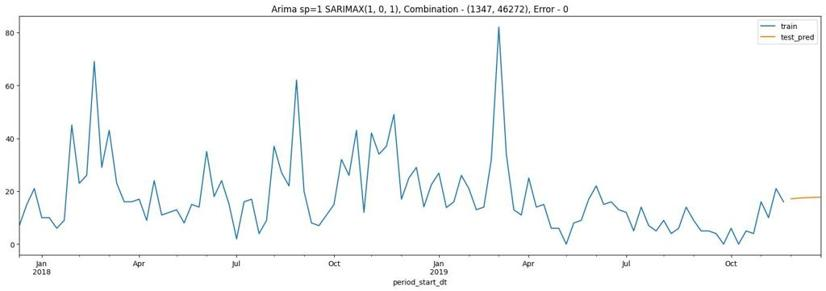

 95%|█████████▍| 227/240 [2:44:34<14:50, 68.47s/it]

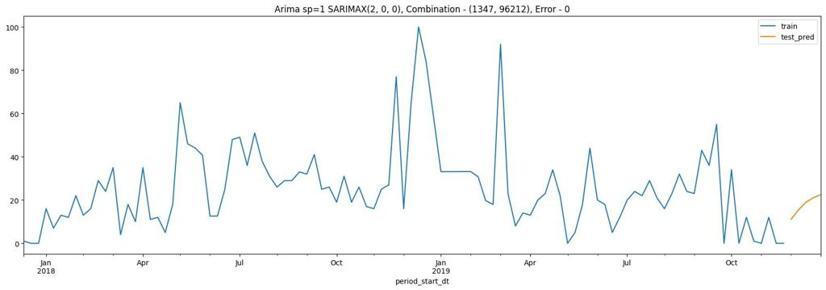

 95%|█████████▌| 228/240 [2:44:35<09:38, 48.19s/it]

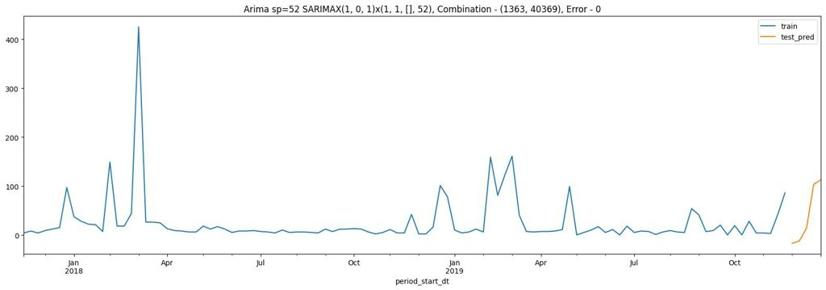

 95%|█████████▌| 229/240 [2:53:14<34:44, 189.53s/it]

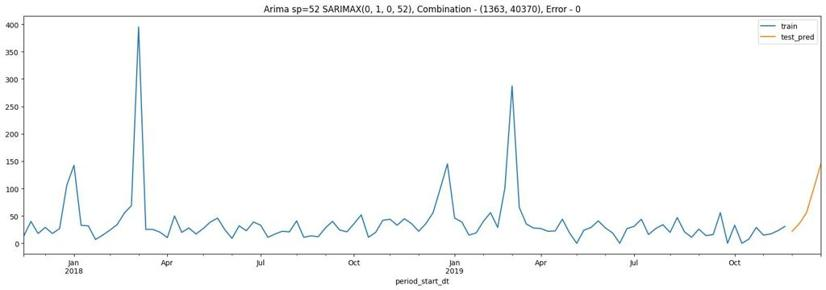

 96%|█████████▌| 230/240 [2:54:22<25:30, 153.06s/it]

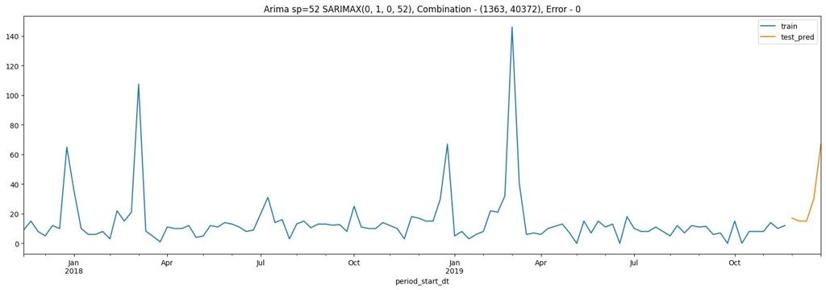

 96%|█████████▋| 231/240 [2:55:01<17:49, 118.79s/it]

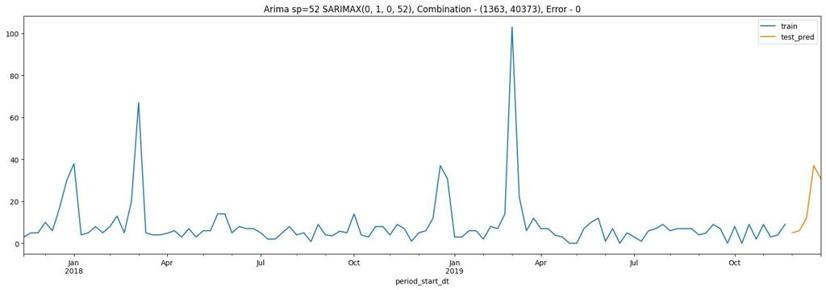

 97%|█████████▋| 232/240 [2:56:15<14:01, 105.19s/it]

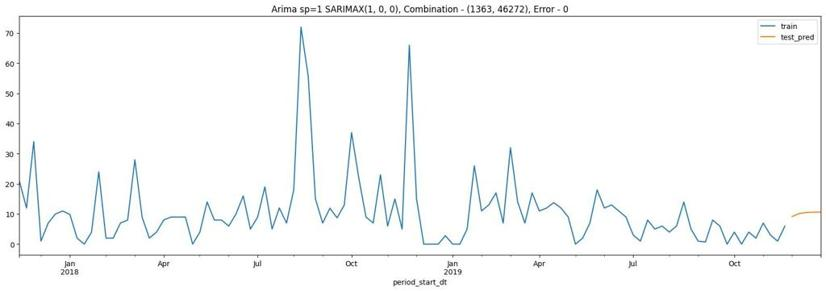

 97%|█████████▋| 233/240 [2:56:16<08:37, 73.91s/it] 

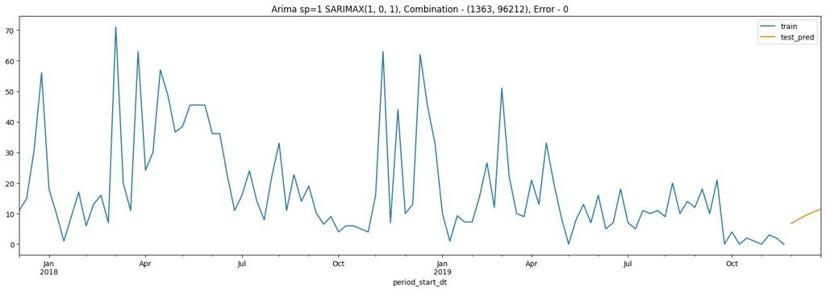

 98%|█████████▊| 234/240 [2:56:16<05:11, 51.99s/it]

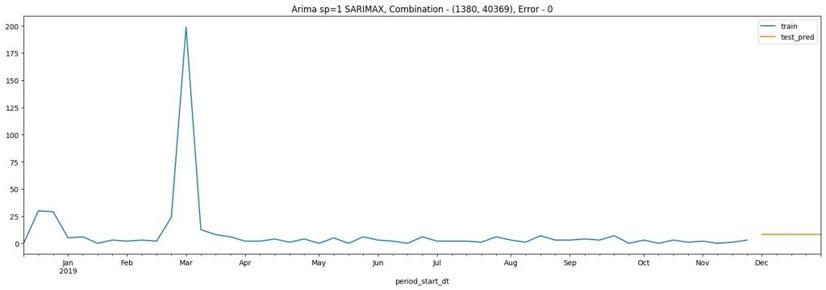

 98%|█████████▊| 235/240 [2:56:17<03:02, 36.59s/it]

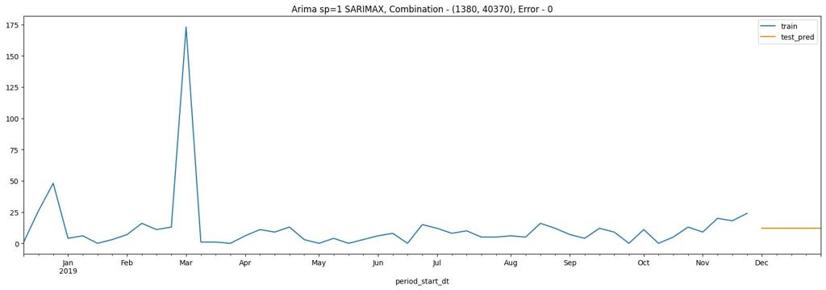

 98%|█████████▊| 236/240 [2:56:18<01:43, 25.81s/it]

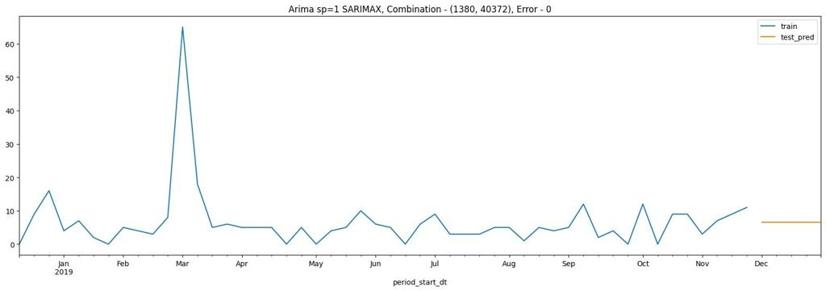

 99%|█████████▉| 237/240 [2:56:18<00:54, 18.24s/it]

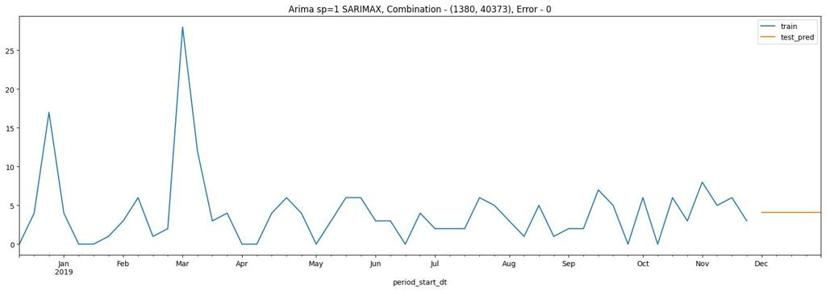

 99%|█████████▉| 238/240 [2:56:19<00:25, 12.95s/it]

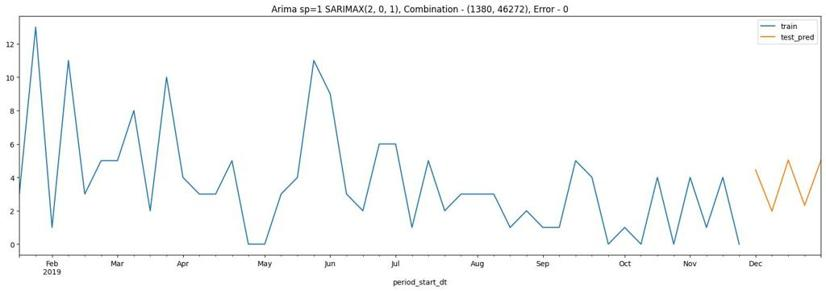

100%|█████████▉| 239/240 [2:56:20<00:09,  9.34s/it]

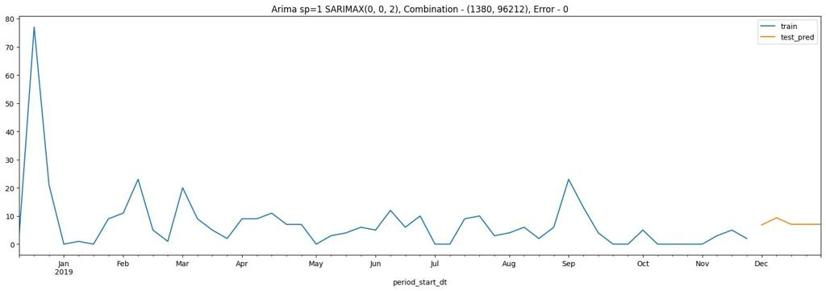

In [13]:
errors = []
submission = []
for combination in tqdm(time_series_dict.keys(), leave=False):
    prediction, error = fit_combination(combination)
    submission.append(prediction)
    errors.append(error)

# print(np.mean(errors)) # for validation

In [14]:
submission = pd.concat(submission).sort_values(by="id").set_index("id")
submission.columns = ["predicted"]
submission.to_csv("Naive flat arima seasonal arima non-seasonal ver2.csv")

In [15]:
print(combination_to_arima)

{(317, 40369): 'SARIMAX(1, 0, 1)x(0, 1, 1, 52)', (317, 40370): 'SARIMAX(0, 1, [1], 52)', (317, 40372): 'SARIMAX(0, 1, 0, 52)', (317, 40373): 'SARIMAX(1, 0, 0)x(1, 1, 0, 52)', (317, 46272): 'SARIMAX(1, 0, 1)', (355, 40369): 'SARIMAX(0, 0, 1)x(1, 1, [], 52)', (355, 40370): 'SARIMAX(0, 0, 1)x(1, 1, [], 52)', (355, 40372): 'SARIMAX(0, 1, [1], 52)', (355, 40373): 'SARIMAX(1, 0, 1)x(1, 1, [], 52)', (355, 46272): 'SARIMAX(3, 0, 1)', (355, 96212): 'SARIMAX(0, 0, 1)', (380, 40369): 'SARIMAX(0, 1, 0, 52)', (380, 40370): 'SARIMAX(1, 1, 0, 52)', (380, 40372): 'SARIMAX(0, 1, 0, 52)', (380, 40373): 'SARIMAX(0, 1, 0, 52)', (380, 46272): 'SARIMAX(1, 0, 0)', (380, 96212): 'SARIMAX(1, 0, 3)', (425, 40369): 'SARIMAX(0, 1, [1], 52)', (425, 40370): 'SARIMAX(0, 1, [1], 52)', (425, 40372): 'SARIMAX(0, 1, 0, 52)', (425, 40373): 'SARIMAX(1, 0, 0)x(1, 1, 0, 52)', (425, 46272): 'SARIMAX(1, 0, 0)', (453, 40369): 'SARIMAX(0, 1, [1], 52)', (453, 40370): 'SARIMAX(1, 0, 0)x(1, 1, 0, 52)', (453, 40372): 'SARIMAX(1, 1,